In [ ]:
# IMPORTANT: RUN THIS CELL TO MOUNT YOUR GOOGLE DRIVE AND ACCESS DATA
# Then, update the paths below to point to your specific data locations in Drive.

from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define the base directory in your Google Drive where your data is stored
# IMPORTANT: Update this path to match where you've placed your data in Drive
GOOGLE_DRIVE_DATA_BASE_DIR ="/content/drive/MyDrive/FYP/Dataset" # EXAMPLE PATH - MODIFY THIS

# --- PhysioNet Data ---
# Assuming PhysioNet data is in a zipped file
PHYSIO30_ZIP_PATH = os.path.join(GOOGLE_DRIVE_DATA_BASE_DIR, "physio30.zip") # EXAMPLE ZIP FILENAME - MODIFY THIS
PHYSIO30_EXTRACT_DIR = "/tmp/physio30_extracted/" # Temporary directory to extract to

# Create the extraction directory if it doesn't exist
os.makedirs(PHYSIO30_EXTRACT_DIR, exist_ok=True)

# Unzip the PhysioNet data
print(f"Checking for and extracting PhysioNet data from: {PHYSIO30_ZIP_PATH}")
if os.path.exists(PHYSIO30_ZIP_PATH):
    try:
        with zipfile.ZipFile(PHYSIO30_ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(PHYSIO30_EXTRACT_DIR)
        print(f"Successfully extracted PhysioNet data to: {PHYSIO30_EXTRACT_DIR}")
        # Define the path to the actual data folder *within* the extracted directory
        # You might need to inspect the zip file content to get the correct inner path
        # For example, if the zip contains a folder named 'physio3', the path would be:
        physio30_path = os.path.join(PHYSIO30_EXTRACT_DIR, "physio30") # EXAMPLE - MODIFY THIS BASED ON ZIP CONTENT
        print(f"Physio30 dataset path: {physio30_path}")

    except FileNotFoundError:
        print(f"ERROR: PhysioNet zip file not found at {PHYSIO30_ZIP_PATH}")
        physio30_path = None # Indicate that the path is not valid
    except zipfile.BadZipFile:
        print(f"ERROR: Invalid zip file at {PHYSIO30_ZIP_PATH}")
        physio30_path = None
    except Exception as e:
        print(f"An error occurred during PhysioNet extraction: {e}")
        physio30_path = None
else:
    print(f"Warning: PhysioNet zip file not found at {PHYSIO30_ZIP_PATH}. Skipping extraction.")
    physio30_path = None


# --- EEGdenoiseNet Data ---
# Assuming EEGdenoiseNet data is in a folder directly in your base data directory
# IMPORTANT: Update this path to match the folder name in your Drive
EEGdenoisenet_path = os.path.join(GOOGLE_DRIVE_DATA_BASE_DIR, "normalised") # EXAMPLE FOLDER NAME - MODIFY THIS

print(f"\nChecking for EEGdenoiseNet data folder at: {EEGdenoisenet_path}")
if os.path.exists(EEGdenoisenet_path):
    print(f"EEGdenoisenet dataset path: {EEGdenoisenet_path}")
else:
    print(f"Warning: EEGdenoiseNet data folder not found at {EEGdenoisenet_path}.")
    EEGdenoisenet_path = None # Indicate that the path is not valid

print('\nData source import process complete.')

# Now you can use 'physio30_path' and 'EEGdenoisenet_path' in subsequent cells.
# Remember to handle cases where these paths might be None if files/folders weren't found.

Mounted at /content/drive
Checking for and extracting PhysioNet data from: /content/drive/MyDrive/FYP/Dataset/physio30.zip
Successfully extracted PhysioNet data to: /tmp/physio30_extracted/
Physio30 dataset path: /tmp/physio30_extracted/physio30

Checking for EEGdenoiseNet data folder at: /content/drive/MyDrive/FYP/Dataset/normalised
EEGdenoisenet dataset path: /content/drive/MyDrive/FYP/Dataset/normalised

Data source import process complete.


### IMPORT REQUIRED LIBRARIES

In [ ]:
import pandas as pd
import os, numpy as np, torch
from torch.utils.data import DataLoader, Dataset
from scipy.signal import welch
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import random_split
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## EEGDENOISENET

### Global parameters & paths

In [ ]:
FS            = 160   # sampling rate (Hz)
SEQ_LEN       = 320   # samples per epoch
BATCH_SIZE    = 32

EEG_DATA_PATH = "/content/drive/MyDrive/FYP/Dataset/normalised/eeg_data_normalised.npy"
EOG_DATA_PATH = "/content/drive/MyDrive/FYP/Dataset/normalised/eog_data_normalised.npy"
EMG_DATA_PATH = "/content/drive/MyDrive/FYP/Dataset/normalised/emg_data_normalised.npy"



In [ ]:
# Load the numpy array from the specified path
eeg_data = np.load(EEG_DATA_PATH)
# Print the shape of the loaded numpy array
print(eeg_data.shape)

(3400, 320)


### Calculating Global Statistics

In [ ]:

def calculate_global_stats(data_paths):
    """Loads data and calculates global mean and std for each signal type."""
    stats = {}
    print("Calculating global statistics...")
    for name, path in data_paths.items():
        if not os.path.exists(path):
            raise FileNotFoundError(f"Data file not found: {path}")
        print(f"Loading {name} from {path}...")
        # Load data, expecting shape (num_samples, sequence_length)
        data = np.load(path)
        if data.ndim != 2:
             raise ValueError(f"Expected 2D array for {name}, but got shape {data.shape}")

        global_mean = np.mean(data) # Mean across all samples and time points
        global_std = np.std(data)   # Std dev across all samples and time points

        # Handle potential zero standard deviation
        if global_std < 1e-8:
             print(f"Warning: Standard deviation for {name} is very close to zero ({global_std}). Using 1.0 instead to avoid division by zero.")
             global_std = 1.0

        stats[name] = {'mean': global_mean, 'std': global_std}
        print(f"{name.upper()} - Global Mean: {global_mean:.4f}, Global Std Dev: {global_std:.4f}")

    print("Statistics calculation complete.")
    return stats

In [ ]:
data_paths_for_stats = {
    'clean_eeg': EEG_DATA_PATH,
    'eog': EOG_DATA_PATH,
    'emg': EMG_DATA_PATH
}

In [ ]:
global_stats = calculate_global_stats(data_paths_for_stats)

Calculating global statistics...
Loading clean_eeg from /content/drive/MyDrive/FYP/Dataset/normalised/eeg_data_normalised.npy...
CLEAN_EEG - Global Mean: -0.0000, Global Std Dev: 1.0000
Loading eog from /content/drive/MyDrive/FYP/Dataset/normalised/eog_data_normalised.npy...
EOG - Global Mean: 0.0000, Global Std Dev: 1.0000
Loading emg from /content/drive/MyDrive/FYP/Dataset/normalised/emg_data_normalised.npy...
EMG - Global Mean: 0.0000, Global Std Dev: 1.0000
Statistics calculation complete.


### EEGDenoiseNet dataset class and dataloader (B,C,L)

In [ ]:


# # =============================================================================
# #  PART 1: DATASET CLASS DEFINITION
# # =============================================================================
# # This class assumes that the .npy files have already been pre-processed
# # and normalized to the desired range (e.g., [-1, 1]).

# class ConditionDataset(Dataset):
#     """
#     Loads pre-normalized EEGdenoiseNet components (Clean EEG, EOG, EMG).
#     """
#     def __init__(self, eeg_path, eog_path, emg_path):
#         """
#         Initializes the dataset by loading data from three separate .npy files.
#         """
#         print("Initializing ConditionDataset with pre-normalized data...")

#         # --- Robust File Validation ---
#         for path in [eeg_path, eog_path, emg_path]:
#             if not os.path.exists(path):
#                 raise FileNotFoundError(f"Data file not found: {path}")

#         # --- Load Data ---
#         self.eeg_data = np.load(eeg_path)
#         self.eog_data = np.load(eog_path)
#         self.emg_data = np.load(emg_path)

#         # --- Validate Consistent Sample Counts ---
#         num_samples = len(self.eeg_data)
#         if not (len(self.eog_data) == num_samples and len(self.emg_data) == num_samples):
#             raise ValueError(f"Inconsistent number of samples found: "
#                              f"EEG={len(self.eeg_data)}, EOG={len(self.eog_data)}, EMG={len(self.emg_data)}")

#         self.num_samples = num_samples
#         self.sequence_length = self.eeg_data.shape[1]
#         print(f"-> ConditionDataset initialized with {self.num_samples} total samples.")

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         """
#         Fetches the sample at the given index and stacks the channels.
#         """
#         # Stack the pre-normalized signals along the channel dimension (axis=0)
#         condition_sample = np.stack([
#             self.eeg_data[idx],
#             self.eog_data[idx],
#             self.emg_data[idx]
#         ], axis=0)

#         return torch.tensor(condition_sample, dtype=torch.float32)


# # =============================================================================
# #  PART 2: DATA SPLITTING AND DATALOADER CREATION
# # =============================================================================

# # --- Configuration ---
# NUM_WORKERS = 0
# RANDOM_SEED = 42


# # --- Step 1: Instantiate the full dataset ---
# print("\n--- Creating Full Condition Dataset ---")
# condition_dataset = ConditionDataset(
#     eeg_path=EEG_DATA_PATH,
#     eog_path=EOG_DATA_PATH,
#     emg_path=EMG_DATA_PATH
# )

# # --- Step 2: Perform the 80/10/10 split for the Condition Dataset ---
# print("\n--- Splitting Condition Dataset ---")
# total_size = len(condition_dataset)
# train_size = int(0.8 * total_size)
# val_size = int(0.1 * total_size)
# test_size = total_size - train_size - val_size

# print(f"Splitting {total_size} condition samples into: {train_size} (Train), {val_size} (Val), {test_size} (Test)")

# generator = torch.Generator().manual_seed(RANDOM_SEED)
# train_subset, val_subset, test_subset = random_split(
#     condition_dataset,
#     [train_size, val_size, test_size],
#     generator=generator
# )

# # --- Step 3: Create the DataLoaders for each subset ---
# print("\n--- Creating DataLoaders ---")
# dataloaders = {}

# # Training loader uses random sampling (shuffle=True)
# dataloaders['train'] = DataLoader(
#     dataset=train_subset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=NUM_WORKERS,
#     pin_memory=True,
#     drop_last=True
# )

# # Validation loader does not shuffle
# dataloaders['val'] = DataLoader(
#     dataset=val_subset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=True
# )

# # Test loader does not shuffle
# dataloaders['test'] = DataLoader(
#     dataset=test_subset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=True
# )

# print("DataLoaders created successfully and stored in the 'dataloaders' dictionary.")
# print(f"Number of batches in training loader: {len(dataloaders['train'])}")
# print(f"Number of batches in validation loader: {len(dataloaders['val'])}")
# print(f"Number of batches in test loader: {len(dataloaders['test'])}")



--- Creating Full Condition Dataset ---
Initializing ConditionDataset with pre-normalized data...
-> ConditionDataset initialized with 3400 total samples.

--- Splitting Condition Dataset ---
Splitting 3400 condition samples into: 2720 (Train), 340 (Val), 340 (Test)

--- Creating DataLoaders ---
DataLoaders created successfully and stored in the 'dataloaders' dictionary.
Number of batches in training loader: 85
Number of batches in validation loader: 11
Number of batches in test loader: 11


In [ ]:
dataloaders['train'].shape

Shape of a batch from the test dataloader: torch.Size([32, 3, 320])


### EEGDenoiseNet dataset class and dataloader (B,L,C)

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# =============================================================================
#  PART 1: DATASET CLASS DEFINITION (channels-last)
# =============================================================================
class ConditionDataset(Dataset):
    """
    Loads pre-normalized EEGdenoiseNet components (Clean EEG, EOG, EMG).

    Returns samples shaped (L, C) = (sequence_length, num_channels=3),
    so DataLoader batches are (B, L, C), as required by your model.
    """
    def __init__(self, eeg_path, eog_path, emg_path):
        print("Initializing ConditionDataset with pre-normalized data (channels-last)...")

        # --- Robust File Validation ---
        for path in [eeg_path, eog_path, emg_path]:
            if not os.path.exists(path):
                raise FileNotFoundError(f"Data file not found: {path}")

        # --- Load Data (ensure float32 for PyTorch) ---
        self.eeg_data = np.asarray(np.load(eeg_path), dtype=np.float32)
        self.eog_data = np.asarray(np.load(eog_path), dtype=np.float32)
        self.emg_data = np.asarray(np.load(emg_path), dtype=np.float32)

        # --- Validate Shapes ---
        if self.eeg_data.ndim != 2 or self.eog_data.ndim != 2 or self.emg_data.ndim != 2:
            raise ValueError("All input arrays must be 2D with shape (N, L).")

        num_samples = self.eeg_data.shape[0]
        if not (self.eog_data.shape[0] == num_samples and self.emg_data.shape[0] == num_samples):
            raise ValueError(f"Inconsistent number of samples: "
                             f"EEG={self.eeg_data.shape[0]}, EOG={self.eog_data.shape[0]}, EMG={self.emg_data.shape[0]}")

        # All should have same sequence length
        L_eeg, L_eog, L_emg = self.eeg_data.shape[1], self.eog_data.shape[1], self.emg_data.shape[1]
        if not (L_eeg == L_eog == L_emg):
            raise ValueError(f"Inconsistent sequence lengths: EEG={L_eeg}, EOG={L_eog}, EMG={L_emg}")

        self.num_samples = num_samples
        self.sequence_length = L_eeg
        print(f"-> ConditionDataset initialized with {self.num_samples} samples, sequence length {self.sequence_length}.")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Returns a single sample with shape (L, C) = (sequence_length, 3),
        i.e., channels-last: [EEG, EOG, EMG] along the last axis.
        """
        # Shape: (L, 3)
        condition_sample = np.stack([
            self.eeg_data[idx],  # (L,)
            self.eog_data[idx],  # (L,)
            self.emg_data[idx],  # (L,)
        ], axis=-1)

        return torch.from_numpy(condition_sample)

In [ ]:
# =============================================================================
#  PART 2: DATA SPLITTING AND DATALOADER CREATION
# =============================================================================

# --- Configuration ---
NUM_WORKERS = 0
RANDOM_SEED = 42


# --- Step 1: Instantiate the full dataset ---
print("\n--- Creating Full Condition Dataset ---")
condition_dataset = ConditionDataset(
    eeg_path=EEG_DATA_PATH,
    eog_path=EOG_DATA_PATH,
    emg_path=EMG_DATA_PATH
)

# --- Step 2: Perform the 80/10/10 split for the Condition Dataset ---
print("\n--- Splitting Condition Dataset ---")
total_size = len(condition_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Splitting {total_size} condition samples into: {train_size} (Train), {val_size} (Val), {test_size} (Test)")

generator = torch.Generator().manual_seed(RANDOM_SEED)
train_subset, val_subset, test_subset = random_split(
    condition_dataset,
    [train_size, val_size, test_size],
    generator=generator
)

# --- Step 3: Create the DataLoaders for each subset ---
print("\n--- Creating DataLoaders ---")
dataloaders = {}

# Training loader uses random sampling (shuffle=True)
dataloaders['train'] = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

# Validation loader does not shuffle
dataloaders['val'] = DataLoader(
    dataset=val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Test loader does not shuffle
dataloaders['test'] = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("DataLoaders created successfully and stored in the 'dataloaders' dictionary.")
print(f"Number of batches in training loader: {len(dataloaders['train'])}")
print(f"Number of batches in validation loader: {len(dataloaders['val'])}")
print(f"Number of batches in test loader: {len(dataloaders['test'])}")



--- Creating Full Condition Dataset ---
Initializing ConditionDataset with pre-normalized data (channels-last)...
-> ConditionDataset initialized with 3400 samples, sequence length 320.

--- Splitting Condition Dataset ---
Splitting 3400 condition samples into: 2720 (Train), 340 (Val), 340 (Test)

--- Creating DataLoaders ---
DataLoaders created successfully and stored in the 'dataloaders' dictionary.
Number of batches in training loader: 85
Number of batches in validation loader: 11
Number of batches in test loader: 11


In [ ]:
# Get a batch from the test dataloader and check its shape
try:
    test_batch = next(iter(dataloaders['train']))
    print(f"Shape of a batch from the test dataloader: {test_batch.shape}")
except StopIteration:
    print("Test dataloader is empty.")
except NameError:
    print("Dataloaders not initialized. Please run the cell that creates the dataloaders.")

Shape of a batch from the test dataloader: torch.Size([32, 320, 3])


### Visualize dataloader (EEGDENOISENET)


--- Visualizing Training Set ---
Batch shape: torch.Size([32, 3, 320])
Batch stats: min=-10.689, max=18.977, mean=0.008, std=1.024


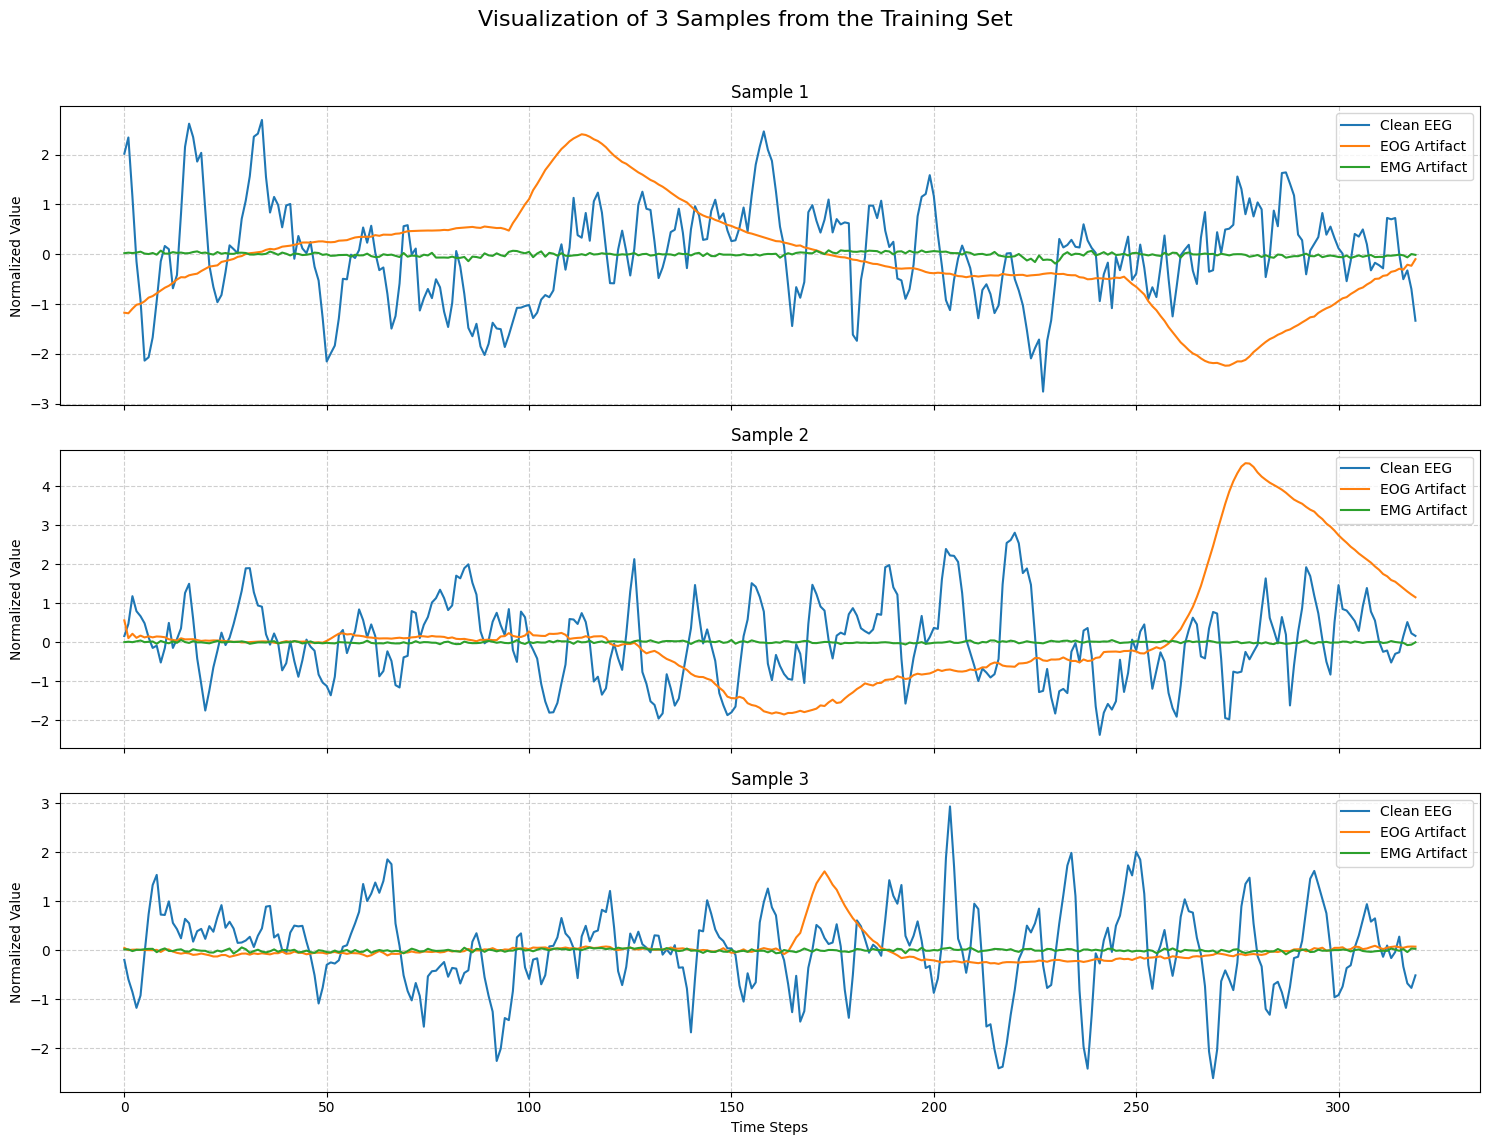


--- Visualizing Validation Set ---
Batch shape: torch.Size([32, 3, 320])
Batch stats: min=-4.902, max=5.764, mean=0.001, std=0.772


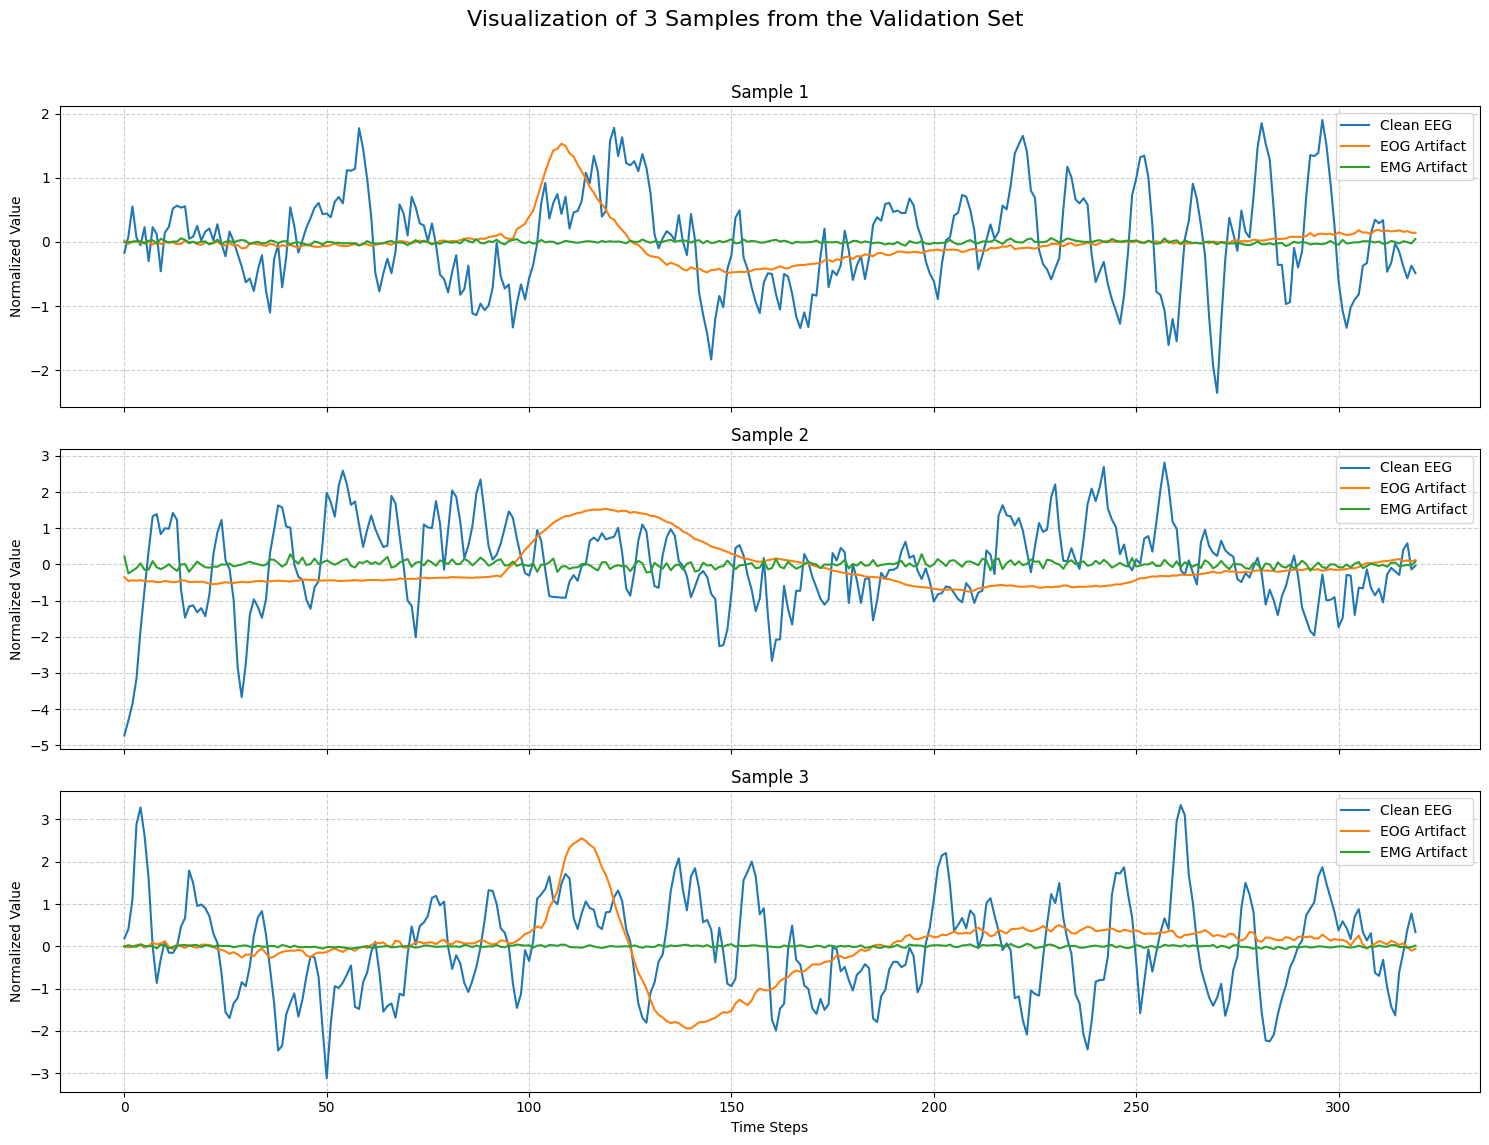


--- Visualizing Test Set ---
Batch shape: torch.Size([32, 3, 320])
Batch stats: min=-8.981, max=17.016, mean=-0.003, std=0.965


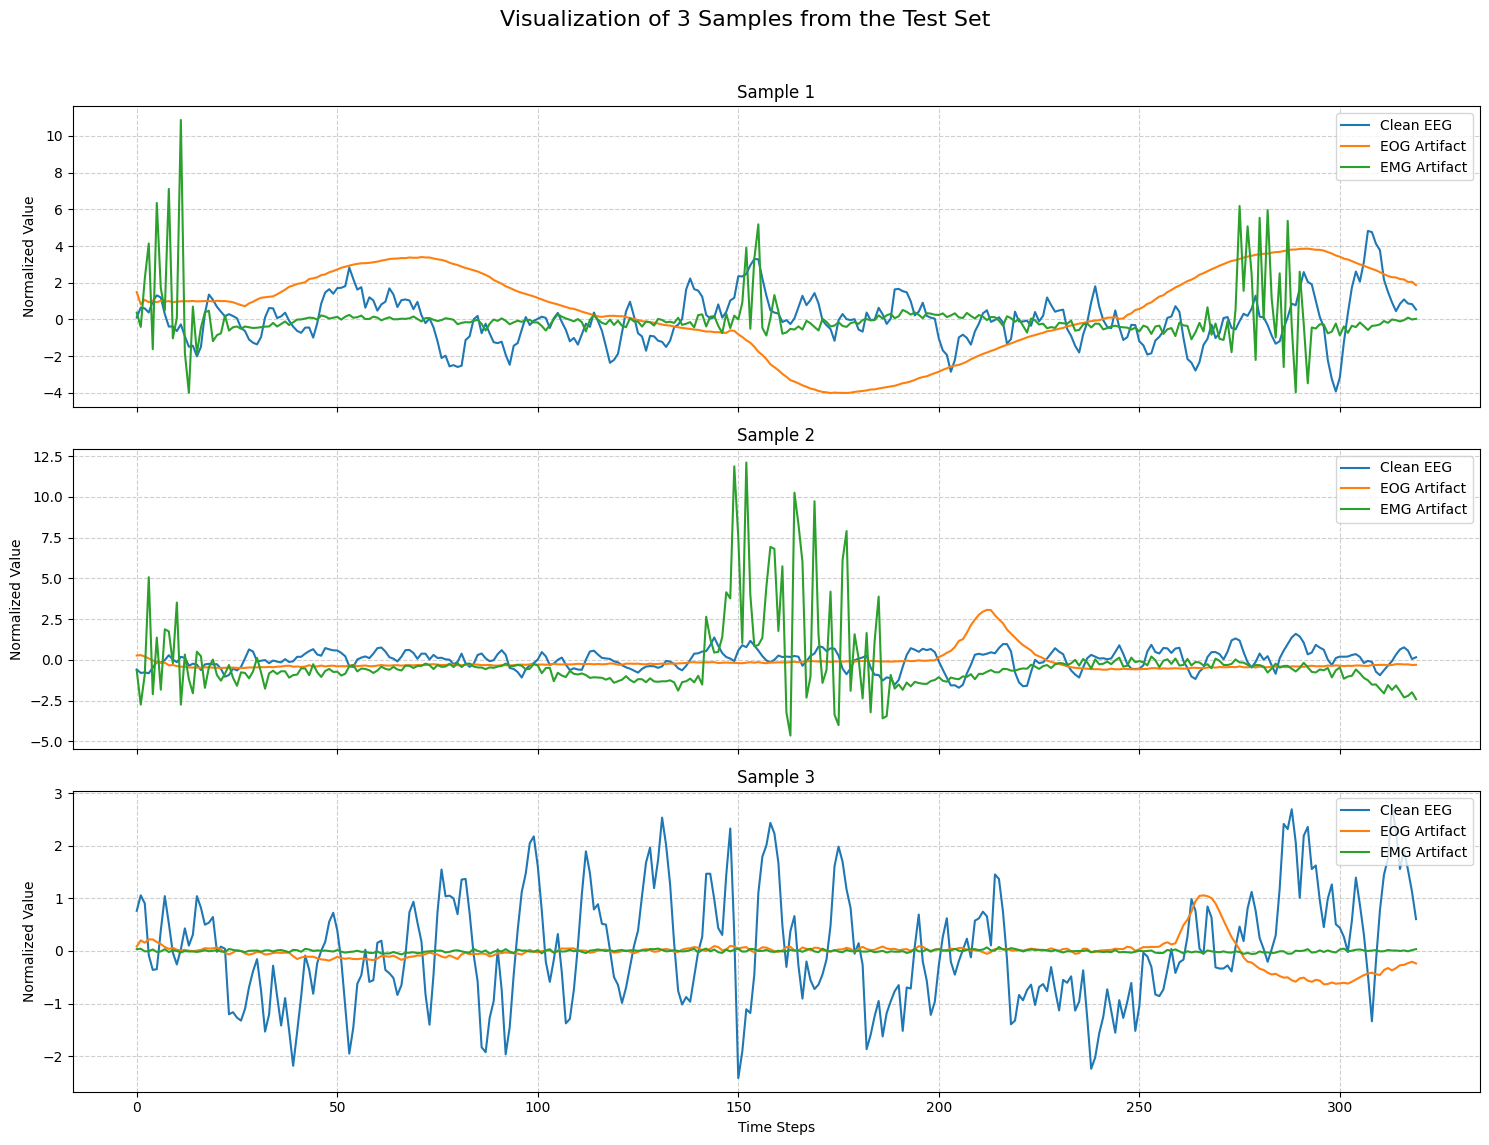

In [ ]:
def visualize_dataloader_samples(dataloader, split_name, channel_labels, num_samples=3):
    """
    Fetches one batch from a dataloader and plots a few samples with accurate labels.

    Args:
        dataloader (DataLoader): The dataloader to visualize.
        split_name (str): The name of the data split (e.g., "Training Set").
        channel_labels (list): A list of strings for labeling each channel.
        num_samples (int): The number of samples to plot from the batch.
    """
    print(f"\n--- Visualizing {split_name} ---")

    # --- Fetch one batch of data ---
    try:
        inputs = next(iter(dataloader))
    except StopIteration:
        print(f"Dataloader for {split_name} is empty.")
        return

    # --- Print Batch Statistics (Sanity Check) ---
    print(f"Batch shape: {inputs.shape}")
    print(f"Batch stats: min={inputs.min().item():.3f}, max={inputs.max().item():.3f}, mean={inputs.mean().item():.3f}, std={inputs.std().item():.3f}")

    # Ensure we don't try to plot more samples than are in the batch
    num_to_plot = min(num_samples, inputs.shape[0])
    if num_to_plot == 0:
        print("Batch is empty, nothing to plot.")
        return

    # --- Create a single figure with subplots for each sample ---
    fig, axes = plt.subplots(num_to_plot, 1, figsize=(15, 4 * num_to_plot), sharex=True, squeeze=False)
    fig.suptitle(f"Visualization of {num_to_plot} Samples from the {split_name}", fontsize=16)

    for i in range(num_to_plot):
        ax = axes[i, 0]
        sample = inputs[i] # Shape: [num_channels, sequence_length]

        # Plot each channel in the sample
        for ch in range(sample.shape[0]):
            ax.plot(sample[ch].cpu().numpy(), label=channel_labels[ch])

        ax.set_title(f"Sample {i+1}")
        ax.set_ylabel("Normalized Value")
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Add a shared x-axis label to the last plot
    axes[-1, 0].set_xlabel("Time Steps")

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()


# --- Run the visualization ---
# Define the accurate labels for our channels
CONDITION_CHANNEL_LABELS = ["Clean EEG", "EOG Artifact", "EMG Artifact"]

# Visualize a few samples from each dataloader
visualize_dataloader_samples(dataloaders['train'], "Training Set", CONDITION_CHANNEL_LABELS)
visualize_dataloader_samples(dataloaders['val'], "Validation Set", CONDITION_CHANNEL_LABELS)
visualize_dataloader_samples(dataloaders['test'], "Test Set", CONDITION_CHANNEL_LABELS)

## PHYSIONET DATASET (EEG Motor Movement/Imagery Dataset)

### Physionet dataset class and dataloader

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import os # Make sure os is imported

# Channel names from EEG Motor Movement/Imagery Dataset
channel_names = ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']

physionet_dir = "/tmp/physio30_extracted/physio3"
BATCH_SIZE = 32
SHUFFLE = True # Note: Shuffle should typically be True for train, False for val/test
NUM_WORKERS = 0
target_channel = 'Fp1.'
RANDOM_SEED = 42 # Define a random seed for reproducible splits

# =============================================================================
#  PhysioNet Dataset Class (Assuming this is defined elsewhere or here)
# =============================================================================
# Re-including the class definition from a previous cell for clarity
class PhysioNetEEGSegmentDataset(Dataset):
    def __init__(self, data_dir, channel_names, target_channel, transform=None):
        self.data_dir = data_dir
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.npy')]
        self.transform = transform

        # Get index of the target channel
        if target_channel not in channel_names:
            raise ValueError(f"Channel {target_channel} not found in channel_names: {channel_names}")
        self.channel_idx = channel_names.index(target_channel)

        self.segment_index = []  # (file_idx, segment_idx)

        # Precompute all (file_idx, segment_idx) pairs
        for file_idx, file_name in enumerate(self.file_list):
            data_path = os.path.join(data_dir, file_name)
            eeg_data = np.load(data_path)
            if eeg_data.ndim != 3 or eeg_data.shape[1] <= self.channel_idx:
                raise ValueError(f"File {file_name} has invalid shape {eeg_data.shape}")
            num_segments = eeg_data.shape[0]
            for segment_idx in range(num_segments):
                self.segment_index.append((file_idx, segment_idx))

    def __len__(self):
        return len(self.segment_index)

    def __getitem__(self, idx):
        file_idx, segment_idx = self.segment_index[idx]
        file_path = os.path.join(self.data_dir, self.file_list[file_idx])
        eeg_data = np.load(file_path)
        segment = eeg_data[segment_idx, self.channel_idx, :]
        # Apply normalization (if not pre_normalized)
        segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-8)
        # Add channel dimension: shape (1, timepoints)
        segment = np.expand_dims(segment, axis=0)
        segment_tensor = torch.tensor(segment, dtype=torch.float32)
        if self.transform:
            segment_tensor = self.transform(segment_tensor)
        return segment_tensor

# =============================================================================
#  Create Full PhysioNet Dataset
# =============================================================================
# Create the full dataset first
p_dataset_full = PhysioNetEEGSegmentDataset(
    data_dir=physionet_dir,
    channel_names=channel_names,
    target_channel=target_channel
)

print(f"Total samples in full PhysioNet dataset: {len(p_dataset_full)}")

# =============================================================================
#  Split PhysioNet Dataset and Create DataLoaders
# =============================================================================

# Define split ratios (e.g., 80% train, 10% val, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1 # The remaining percentage

# Calculate the number of samples for each split
total_size = len(p_dataset_full)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size # Ensure sizes sum correctly

print(f"Splitting PhysioNet dataset: Train={train_size}, Val={val_size}, Test={test_size}")

# Ensure sizes are positive
if train_size <= 0 or val_size <= 0 or test_size <= 0:
    raise ValueError(f"Invalid split sizes. Total size: {total_size}, Train: {train_size}, Val: {val_size}, Test: {test_size}")


# Perform the random split
generator_split = torch.Generator().manual_seed(RANDOM_SEED) # Use a fixed seed for reproducibility
p_dataset_train, p_dataset_val, p_dataset_test = random_split(
    p_dataset_full,
    [train_size, val_size, test_size],
    generator=generator_split # Pass the generator here
)

print("PhysioNet dataset split successfully.")

# Create DataLoaders for each split
# Shuffle only the training set
p_dataloaders = {
    'train': DataLoader(p_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True),
    'val': DataLoader(p_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True),
    'test': DataLoader(p_dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
}

print("\nPhysioNet DataLoaders created for train, val, and test splits.")

# You can inspect the dataloaders if needed
# print(f"PhysioNet Train Loader has {len(p_dataloaders['train'])} batches.")
# print(f"PhysioNet Val Loader has {len(p_dataloaders['val'])} batches.")
# print(f"PhysioNet Test Loader has {len(p_dataloaders['test'])} batches.")

Total samples in full PhysioNet dataset: 23844
Splitting PhysioNet dataset: Train=19075, Val=2384, Test=2385
PhysioNet dataset split successfully.

PhysioNet DataLoaders created for train, val, and test splits.


In [ ]:
# Check batch size
for batch in p_dataloaders['val']:
    print("Batch shape:", batch.shape)
    break

Batch shape: torch.Size([32, 1, 320])


In [ ]:
# Inspect Dataloader

print("\nChecking DataLoader output...")

try:
    num_samples = len(p_dataset_full)
    num_batches = len(p_dataloaders['train'])
    first_batch = next(iter(p_dataloaders['train']))
    batch_size, channels, timepoints = first_batch.shape

    print(f"Total samples in dataset: {num_samples}")
    print(f"Total batches in dataloader: {num_batches}")
    print(f"Batch shape: {first_batch.shape} (batch_size, channels, timepoints)")
    print(f"Batch dtype: {first_batch.dtype}")
    print(f"Batch size (actual): {batch_size}")
    print(f"Channels per segment: {channels}")
    print(f"Timepoints per segment: {timepoints}")
    print(f"First segment stats: mean={first_batch[0,0].mean().item():.4f}, std={first_batch[0,0].std().item():.4f}")
    print(f"First 10 values of first segment: {first_batch[0,0,:10].numpy()}")

except Exception as e:
    print(f"Error: {type(e).__name__} - {e}")


Checking DataLoader output...
Total samples in dataset: 23844
Total batches in dataloader: 596
Batch shape: torch.Size([32, 1, 320]) (batch_size, channels, timepoints)
Batch dtype: torch.float32
Batch size (actual): 32
Channels per segment: 1
Timepoints per segment: 320
First segment stats: mean=-0.0000, std=1.0015
First 10 values of first segment: [ 0.01757543  0.1405074   0.591258   -0.11560088  0.69370127  0.44783735
 -0.29999885  0.560525   -0.02340189  0.02781976]


### Visualize PhysioNET Dataloader


--- Creating PhysioNet Data Pipeline ---

--- Data Pipeline Summary ---
Total Samples in Full Dataset: 23844
--------------------------------------------------
Split        | Num Samples     | Num Batches     | Batch Shape
--------------------------------------------------
Training     | 19075           | 596             | (32, 1, 320)
Validation   | 2384            | 75              | (32, 1, 320)
Test         | 2385            | 75              | (32, 1, 320)
--------------------------------------------------

--- VISUALIZING DATALOADER OUTPUTS ---


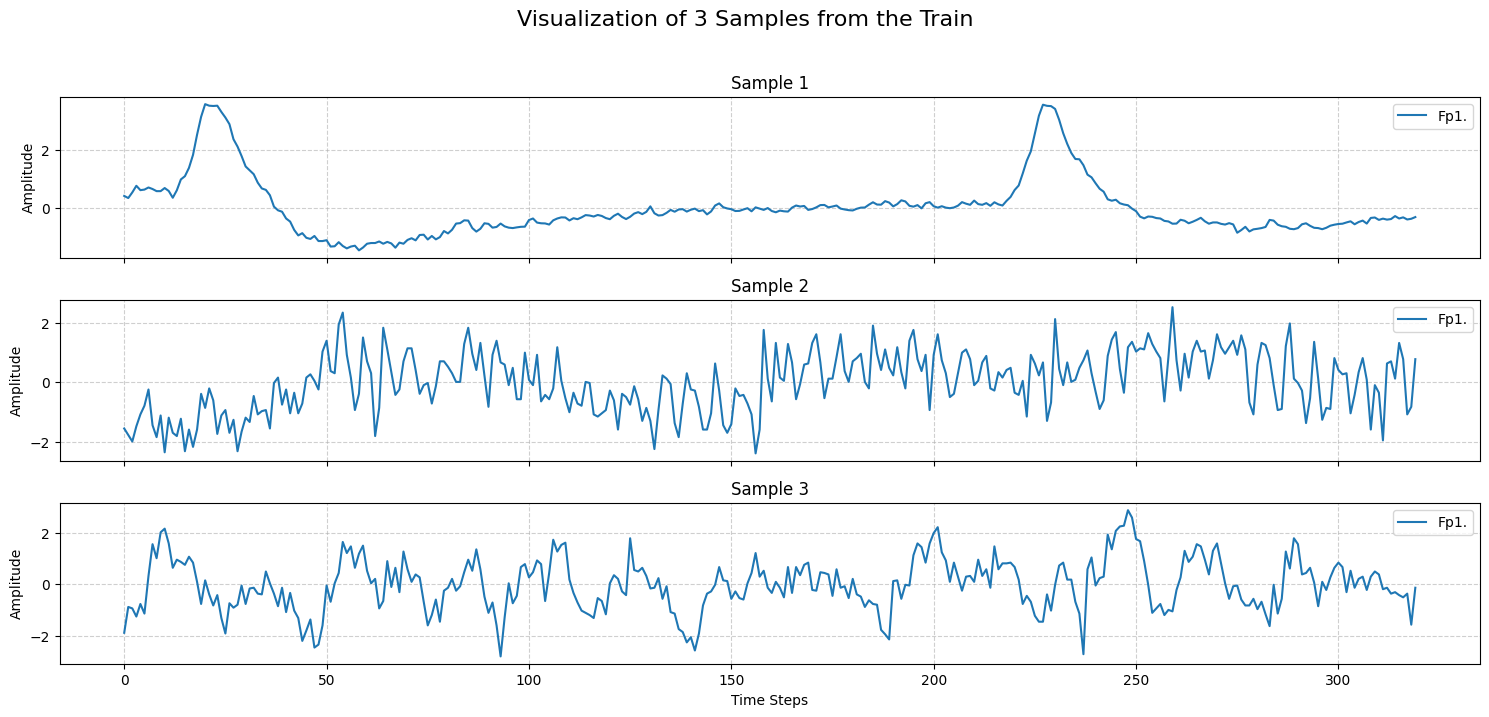

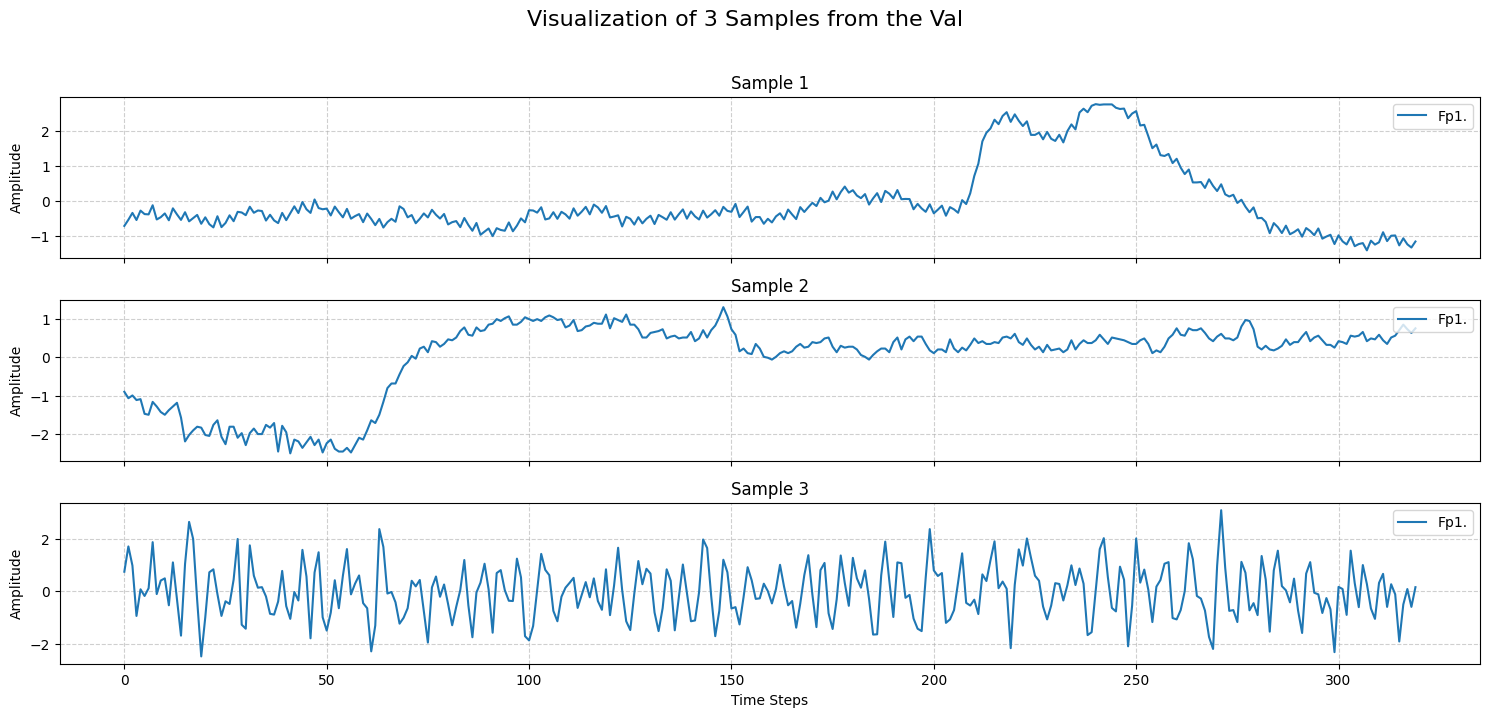

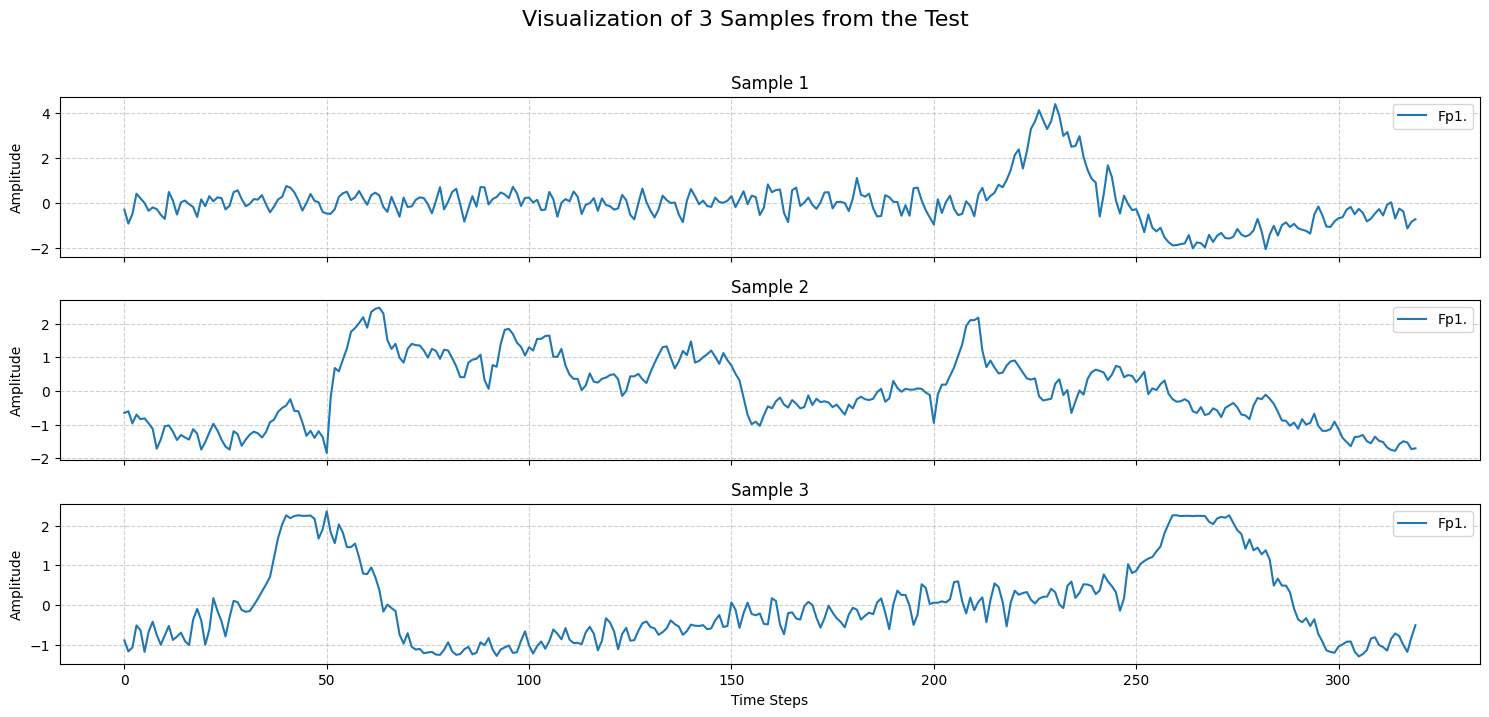

In [ ]:
# =============================================================================
#  PART 1: DATASET CLASS DEFINITION
# =============================================================================

class PhysioNetEEGSegmentDataset(Dataset):
    """
    Efficient EEG segment loader for PhysioNet data.
    Supports memory mapping, pre-normalized data, and multi-channel extraction.
    """
    def __init__(self, data_dir, channel_names, target_channels, pre_normalized=False, transform=None, return_index=False):
        self.data_dir = data_dir
        self.file_list = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])
        if not self.file_list:
            raise FileNotFoundError(f"No .npy files found in the directory: {data_dir}. Please check the path.")
        self.transform = transform
        self.pre_normalized = pre_normalized
        self.return_index = return_index
        if isinstance(target_channels, str):
            target_channels = [target_channels]
        for ch in target_channels:
            if ch not in channel_names:
                raise ValueError(f"Channel {ch} not found in channel_names.")
        self.channel_indices = [channel_names.index(ch) for ch in target_channels]
        self.channel_labels = target_channels
        self.segment_index = []
        self.file_shapes = []
        for file_idx, file_name in enumerate(self.file_list):
            data_path = os.path.join(data_dir, file_name)
            try:
                eeg_data = np.load(data_path, mmap_mode='r')
            except Exception as e:
                raise RuntimeError(f"Failed to load {data_path}: {e}")
            if eeg_data.ndim != 3 or eeg_data.shape[1] < max(self.channel_indices) + 1:
                raise ValueError(f"File {file_name} has invalid shape {eeg_data.shape}")
            num_segments = eeg_data.shape[0]
            self.file_shapes.append(eeg_data.shape)
            for segment_idx in range(num_segments):
                self.segment_index.append((file_idx, segment_idx))

    def __len__(self):
        return len(self.segment_index)

    def __getitem__(self, idx):
        file_idx, segment_idx = self.segment_index[idx]
        file_path = os.path.join(self.data_dir, self.file_list[file_idx])
        eeg_data = np.load(file_path, mmap_mode='r')
        segment = eeg_data[segment_idx, self.channel_indices, :]
        if not self.pre_normalized:
            segment = (segment - segment.mean(axis=1, keepdims=True)) / (segment.std(axis=1, keepdims=True) + 1e-8)
        segment_tensor = torch.tensor(segment, dtype=torch.float32)
        if self.transform:
            segment_tensor = self.transform(segment_tensor)
        if self.return_index:
            return segment_tensor, (file_idx, segment_idx)
        return segment_tensor

# =============================================================================
#  PART 2: DATALOADER CREATION & SUMMARY FUNCTION
# =============================================================================

def create_physionet_dataloaders(
    data_dir,
    channel_names,
    target_channels,
    batch_size=32,
    num_workers=1,
    shuffle=True,
    split_ratios=(0.8, 0.1, 0.1),
    random_seed=42,
    pre_normalized=False
):
    """
    Creates and summarizes train/val/test dataloaders for PhysioNet EEG segments.
    """
    print("\n--- Creating PhysioNet Data Pipeline ---")
    dataset = PhysioNetEEGSegmentDataset(
        data_dir=data_dir,
        channel_names=channel_names,
        target_channels=target_channels,
        pre_normalized=pre_normalized
    )

    total_size = len(dataset)
    if total_size == 0:
        raise ValueError("The created dataset is empty. Please check the data directory and file contents.")

    train_size = int(split_ratios[0] * total_size)
    val_size = int(split_ratios[1] * total_size)
    test_size = total_size - train_size - val_size

    generator = torch.Generator().manual_seed(random_seed)
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=generator)

    loaders = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True, drop_last=True),
        'val': DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
        'test': DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    }

    # ---Summary Block ---
    print("\n--- Data Pipeline Summary ---")
    print(f"Total Samples in Full Dataset: {total_size}")
    print("-" * 50)
    print(f"{'Split':<12} | {'Num Samples':<15} | {'Num Batches':<15} | {'Batch Shape'}")
    print("-" * 50)

    # Train Summary
    train_samples = len(train_set)
    train_batches = len(loaders['train'])
    train_batch_shape = tuple(next(iter(loaders['train'])).shape) if train_batches > 0 else "N/A"
    print(f"{'Training':<12} | {train_samples:<15} | {train_batches:<15} | {str(train_batch_shape)}")

    # Validation Summary
    val_samples = len(val_set)
    val_batches = len(loaders['val'])
    val_batch_shape = tuple(next(iter(loaders['val'])).shape) if val_batches > 0 else "N/A"
    print(f"{'Validation':<12} | {val_samples:<15} | {val_batches:<15} | {str(val_batch_shape)}")

    # Test Summary
    test_samples = len(test_set)
    test_batches = len(loaders['test'])
    test_batch_shape = tuple(next(iter(loaders['test'])).shape) if test_batches > 0 else "N/A"
    print(f"{'Test':<12} | {test_samples:<15} | {test_batches:<15} | {str(test_batch_shape)}")
    print("-" * 50)

    return loaders, dataset.channel_labels

# =============================================================================
#  PART 3: VISUALIZATION FUNCTION
# =============================================================================
def visualize_eeg_batch_from_dataloader(dataloader, channel_labels, split_name="", num_segments=5, save_path=None):
    try:
        batch = next(iter(dataloader))
    except StopIteration:
        print(f"\nNote: Dataloader for '{split_name}' is empty, cannot visualize.")
        return
    if isinstance(batch, (tuple, list)): batch = batch[0]
    batch_size, num_channels, timepoints = batch.shape
    n_plot = min(num_segments, batch_size)
    fig, axes = plt.subplots(n_plot, 1, figsize=(15, 2.5 * n_plot), sharex=True, squeeze=False)
    fig.suptitle(f"Visualization of {n_plot} Samples from the {split_name}", fontsize=16)
    for i in range(n_plot):
        ax = axes[i, 0]
        for ch in range(num_channels):
            ax.plot(batch[i, ch].detach().cpu().numpy(), label=channel_labels[ch])
        ax.set_title(f"Sample {i+1}")
        ax.set_ylabel("Amplitude")
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.6)
    axes[-1, 0].set_xlabel("Time Steps")
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    if save_path: plt.savefig(save_path)
    plt.show()

# =============================================================================
#  FINAL EXECUTION BLOCK
# =============================================================================

physionet_dir = "/tmp/physio30_extracted/physio3"
BATCH_SIZE = 32
target_channels = ['Fp1.']
PRE_NORMALIZED_FLAG = False

channel_names = ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']

# --- 2. Create the Dataloaders and Print Summary ---
try:
    real_noisy_loaders, real_noisy_channel_labels = create_physionet_dataloaders(
        data_dir=physionet_dir,
        channel_names=channel_names,
        target_channels=target_channels,
        batch_size=BATCH_SIZE,
        pre_normalized=PRE_NORMALIZED_FLAG
    )


    print("\n--- VISUALIZING DATALOADER OUTPUTS ---")
    for split_name in ['train', 'val', 'test']:
        visualize_eeg_batch_from_dataloader(
            dataloader=real_noisy_loaders[split_name],
            channel_labels=real_noisy_channel_labels,
            split_name=split_name.capitalize(),
            num_segments=3
        )

except (FileNotFoundError, ValueError) as e:
    print(f"\n--- ERROR ---")
    print(f"An error occurred during data pipeline creation: {e}")
    print("Please check your 'physionet_dir' path and ensure it contains valid .npy files.")

## FEATURE EXTRACTION (EEGDENOISENET)

### Extract Bandpower

In [ ]:
import torch
import torch.nn.functional as F

# =============================================================================
#  FINAL, CORRECTED FEATURE EXTRACTION MODULE
# =============================================================================

def bandpower_torch(signals, fs, band, dim=-1, eps=1e-8):
    """
    Compute band power for a given frequency band using FFT.
    This function remains the core of the calculation.
    """
    seq_len = signals.shape[dim]
    freqs = torch.fft.rfftfreq(seq_len, d=1/fs).to(signals.device)
    fft = torch.fft.rfft(signals, dim=dim)
    psd = torch.abs(fft) ** 2 / (seq_len * fs)

    # One-sided spectrum: double power for all but DC and Nyquist frequencies
    if seq_len % 2 == 0:
        psd[..., 1:-1] *= 2
    else:
        psd[..., 1:] *= 2

    band_mask = (freqs >= band[0]) & (freqs <= band[1])
    band_power = psd[..., band_mask].sum(dim=dim) + eps
    return band_power

# --- Specific Wrappers for your GAN (Corrected Implementation) ---

def feature_cond(condition_batch, fs=160):
    """
    REPLACED: Correctly extracts the two specific target features from the
    3-channel condition batch [Clean EEG, EOG, EMG].
    - Feature 1: Low-band power from EOG (channel 1)
    - Feature 2: High-band power from EMG (channel 2)
    Returns a tensor of shape [batch_size, 2].
    """
    # Isolate the EOG and EMG signals from the 3-channel condition
    eog_signal = condition_batch[:, 1, :]
    emg_signal = condition_batch[:, 2, :]

    # Calculate the specific power for each
    eog_low_power = bandpower_torch(eog_signal, fs, band=(0.5, 8))
    emg_high_power = bandpower_torch(emg_signal, fs, band=(30, 80))

    # Apply log transform
    eog_log_power = torch.log10(eog_low_power)
    emg_log_power = torch.log10(emg_high_power)

    # Stack the two desired features into a [batch_size, 2] tensor
    target_features = torch.stack([eog_log_power, emg_log_power], dim=1)
    return target_features

def feature_out(generated_batch, fs=160):
    """
    REPLACED: Extracts the corresponding features from the 1-channel generated output.
    - Feature 1: Low-band power from the generated signal
    - Feature 2: High-band power from the generated signal
    Returns a tensor of shape [batch_size, 2].
    """
    # Ensure input is in [batch, 1, seq_len] format
    if generated_batch.ndim == 2:
        generated_batch = generated_batch.unsqueeze(1)

    # Isolate the single generated signal channel
    generated_signal = generated_batch[:, 0, :]

    # Calculate the two features from this single signal
    gen_low_power = bandpower_torch(generated_signal, fs, band=(0.5, 8))
    gen_high_power = bandpower_torch(generated_signal, fs, band=(30, 80))

    # Apply log transform
    gen_log_low = torch.log10(gen_low_power)
    gen_log_high = torch.log10(gen_high_power)

    generated_features = torch.stack([gen_log_low, gen_log_high], dim=1)
    return generated_features

In [ ]:
# # --- Analysis Configuration ---
# FS = 160  # Sampling Frequency of your data
# OUTPUT_CSV_FILE = "eegdenoisenet_train_features_DETAILED.csv"

# # --- MODIFIED Feature Extraction Wrapper ---
# # This version now returns both the raw linear power and the log-transformed power.
# # CONFIRMED: This function uses the correct, explicit logic.
# def feature_cond_detailed(batch, fs=160):
#     """
#     Extracts specific features from the 3-channel condition batch.
#     Returns two tensors: one with linear power, one with log10 power.
#     """
#     # Isolate the EOG and EMG signals from the 3-channel condition
#     eog_signal = batch[:, 1, :]
#     emg_signal = batch[:, 2, :]

#     # 1. Calculate the raw linear power for each artifact
#     eog_low_power_linear = bandpower_torch(eog_signal, fs, band=(0.5, 8))
#     emg_high_power_linear = bandpower_torch(emg_signal, fs, band=(30, 80))

#     # 2. Apply the log10 transform to get the final features
#     eog_low_power_log = torch.log10(eog_low_power_linear)
#     emg_high_power_log = torch.log10(emg_high_power_linear)

#     # 3. Stack them into separate tensors
#     linear_features = torch.stack([eog_low_power_linear, emg_high_power_linear], dim=1)
#     log_features = torch.stack([eog_low_power_log, emg_high_power_log], dim=1)

#     return linear_features, log_features

# # --- Main Analysis Logic ---
# if __name__ == '__main__':
#     print("\n\n--- Starting DETAILED Feature Extraction Analysis on Training Set ---")

#     try:
#         # This assumes 'dataloaders' is defined and available in your environment
#         train_loader = dataloaders['train']
#         print(f"Successfully accessed 'train' dataloader with {len(train_loader)} batches.")
#     except NameError:
#         print("\n--- ERROR ---")
#         print("The 'dataloaders' dictionary was not found.")
#         exit()

#     # This list will store a dictionary for each sample, creating a detailed table
#     all_sample_data = []
#     num_batches = len(train_loader)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}\n")

#     # --- Print the header for our detailed live log ---
#     print("--- Live Log (showing first 5 samples of first 3 batches) ---")
#     header = f"{'Batch':<8} {'Sample':<8} {'EOG_Linear':<15} {'EOG_Log':<15} {'EMG_Linear':<15} {'EMG_Log':<15}"
#     print(header)
#     print("-" * len(header))

#     for i, batch_data in enumerate(train_loader):
#         batch_data = batch_data.to(device)

#         with torch.no_grad():
#             # Use the detailed function to get both linear and log features
#             linear_feats, log_feats = feature_cond_detailed(batch_data, fs=FS)

#         # Loop through each sample within the batch to create the detailed log
#         for j in range(batch_data.shape[0]):
#             # Extract scalar values for the current sample
#             lin_eog = linear_feats[j, 0].item()
#             log_eog = log_feats[j, 0].item()
#             lin_emg = linear_feats[j, 1].item()
#             log_emg = log_feats[j, 1].item()

#             # Store all data for this sample in a dictionary
#             sample_dict = {
#                 'batch_index': i,
#                 'sample_in_batch': j,
#                 'linear_power_eog': lin_eog,
#                 'log_power_eog': log_eog,
#                 'linear_power_emg': lin_emg,
#                 'log_power_emg': log_emg
#             }
#             all_sample_data.append(sample_dict)

#             # Print the live log for a limited number of samples to avoid flooding the console
#             if i < 3 and j < 5:
#                 print(f"{i:<8} {j:<8} {lin_eog:<15.4f} {log_eog:<15.4f} {lin_emg:<15.4f} {log_emg:<15.4f}")

#     print("\nFeature extraction for all batches is complete.")

#     # --- Create the final, detailed DataFrame from our list of dictionaries ---
#     print("\nAggregating results into a detailed DataFrame...")
#     features_df = pd.DataFrame(all_sample_data)

#     # --- Display the statistical summary of the new, detailed table ---
#     print("\n--- Statistical Summary of ALL Features (Linear and Log) ---")
#     summary_table = features_df.describe()
#     print(summary_table)

#     # --- Write the complete, detailed table to a CSV file ---
#     try:
#         features_df.to_csv(OUTPUT_CSV_FILE, index=False)
#         print(f"\n✅ Successfully saved DETAILED table with {len(features_df)} entries to '{OUTPUT_CSV_FILE}'")
#     except Exception as e:
#         print(f"\n❌ Error saving CSV file: {e}")

#     print("\n--- Analysis Finished ---")

In [ ]:
# --- Analysis Configuration ---
FS = 160  # Sampling Frequency of your data
OUTPUT_CSV_FILE = "eegdenoisenet_train_features_DETAILED.csv"

# --- MODIFIED Feature Extraction Wrapper ---
# This version now returns both the raw linear power and the log-transformed power.
# CONFIRMED: This function uses the correct, explicit logic.
def feature_cond_detailed(batch, fs=160):
    """
    Extracts specific features from the 3-channel condition batch.
    Returns two tensors: one with linear power, one with log10 power.
    """
    # Isolate the EOG and EMG signals from the 3-channel condition
    eog_signal = batch[:, 1, :]
    emg_signal = batch[:, 2, :]

    # 1. Calculate the raw linear power for each artifact
    eog_low_power_linear = bandpower_torch(eog_signal, fs, band=(0.5, 8))
    emg_high_power_linear = bandpower_torch(emg_signal, fs, band=(30, 80))

    # 2. Apply the log10 transform to get the final features
    eog_low_power_log = torch.log10(eog_low_power_linear)
    emg_high_power_log = torch.log10(emg_high_power_linear)

    # 3. Stack them into separate tensors
    linear_features = torch.stack([eog_low_power_linear, emg_high_power_linear], dim=1)
    log_features = torch.stack([eog_low_power_log, emg_high_power_log], dim=1)

    return linear_features, log_features

# --- Main Analysis Logic ---
if __name__ == '__main__':
    print("\n\n--- Starting DETAILED Feature Extraction Analysis on Training Set ---")

    try:
        # This assumes 'dataloaders' is defined and available in your environment
        train_loader = dataloaders['train']
        print(f"Successfully accessed 'train' dataloader with {len(train_loader)} batches.")
    except NameError:
        print("\n--- ERROR ---")
        print("The 'dataloaders' dictionary was not found.")
        exit()

    # This list will store a dictionary for each sample, creating a detailed table
    all_sample_data = []
    num_batches = len(train_loader)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # --- Print the header for our detailed live log ---
    print("--- Live Log (showing first 5 samples of first 3 batches) ---")
    header = f"{'Batch':<8} {'Sample':<8} {'EOG_Linear':<15} {'EOG_Log':<15} {'EMG_Linear':<15} {'EMG_Log':<15}"
    print(header)
    print("-" * len(header))

    for i, batch_data in enumerate(train_loader):
        batch_data = batch_data.to(device)

        with torch.no_grad():
            # Use the detailed function to get both linear and log features
            linear_feats, log_feats = feature_cond_detailed(batch_data, fs=FS)

        # Loop through each sample within the batch to create the detailed log
        for j in range(batch_data.shape[0]):
            # Extract scalar values for the current sample
            lin_eog = linear_feats[j, 0].item()
            log_eog = log_feats[j, 0].item()
            lin_emg = linear_feats[j, 1].item()
            log_emg = log_feats[j, 1].item()

            # Store all data for this sample in a dictionary
            sample_dict = {
                'batch_index': i,
                'sample_in_batch': j,
                'linear_power_eog': lin_eog,
                'log_power_eog': log_eog,
                'linear_power_emg': lin_emg,
                'log_power_emg': log_emg
            }
            all_sample_data.append(sample_dict)

            # Print the live log for a limited number of samples to avoid flooding the console
            if i < 3 and j < 5:
                print(f"{i:<8} {j:<8} {lin_eog:<15.4f} {log_eog:<15.4f} {lin_emg:<15.4f} {log_emg:<15.4f}")

    print("\nFeature extraction for all batches is complete.")

    # --- Create the final, detailed DataFrame from our list of dictionaries ---
    print("\nAggregating results into a detailed DataFrame...")
    features_df = pd.DataFrame(all_sample_data)

    # --- Display the statistical summary of the new, detailed table ---
    print("\n--- Statistical Summary of ALL Features (Linear and Log) ---")
    summary_table = features_df.describe()
    print(summary_table)

    # --- Write the complete, detailed table to a CSV file ---
    try:
        features_df.to_csv(OUTPUT_CSV_FILE, index=False)
        print(f"\n✅ Successfully saved DETAILED table with {len(features_df)} entries to '{OUTPUT_CSV_FILE}'")
    except Exception as e:
        print(f"\n❌ Error saving CSV file: {e}")

    print("\n--- Analysis Finished ---")



--- Starting DETAILED Feature Extraction Analysis on Training Set ---
Successfully accessed 'train' dataloader with 85 batches.
Using device: cuda

--- Live Log (showing first 5 samples of first 3 batches) ---
Batch    Sample   EOG_Linear      EOG_Log         EMG_Linear      EMG_Log        
---------------------------------------------------------------------------------
0        0        0.1236          -0.9081         0.0274          -1.5622        
0        1        0.7778          -0.1091         0.6327          -0.1988        
0        2        6.5134          0.8138          0.0011          -2.9493        
0        3        1.6363          0.2139          0.0135          -1.8697        
0        4        0.8277          -0.0821         0.0005          -3.2690        
1        0        0.0975          -1.0109         0.2252          -0.6474        
1        1        0.2356          -0.6279         0.0006          -3.2518        
1        2        0.1077          -0.9678         

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# =============================================================================
# CELL 1: SETUP, DATA LOADING, AND OUTPUT DIRECTORY CREATION
# =============================================================================
# This cell loads the data and creates a directory to store the output plots.

# --- Configuration ---
CSV_FILE_PATH = "eegdenoisenet_train_features_DETAILED.csv"
OUTPUT_DIR = "feature_visualizations"

# --- Create Output Directory ---
# This ensures the folder exists before we try to save files to it.
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Plots will be saved to the '{OUTPUT_DIR}/' directory.")

# --- Plotting Style ---
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 8) # Adjusted for single plots
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['savefig.dpi'] = 300 # High resolution for saved figures
plt.rcParams['savefig.bbox'] = 'tight' # Ensure nothing is cut off

# --- Load the Data ---
try:
    features_df = pd.read_csv(CSV_FILE_PATH)
    print(f"✅ Successfully loaded data from '{CSV_FILE_PATH}'.")
    print(f"DataFrame contains {len(features_df)} samples.")
except FileNotFoundError:
    print(f"❌ ERROR: The file '{CSV_FILE_PATH}' was not found.")
    print("Please ensure you have run the feature extraction script first.")

Plots will be saved to the 'feature_visualizations/' directory.
✅ Successfully loaded data from 'eegdenoisenet_train_features_DETAILED.csv'.
DataFrame contains 2720 samples.



--- Generating and saving individual feature distribution plots ---


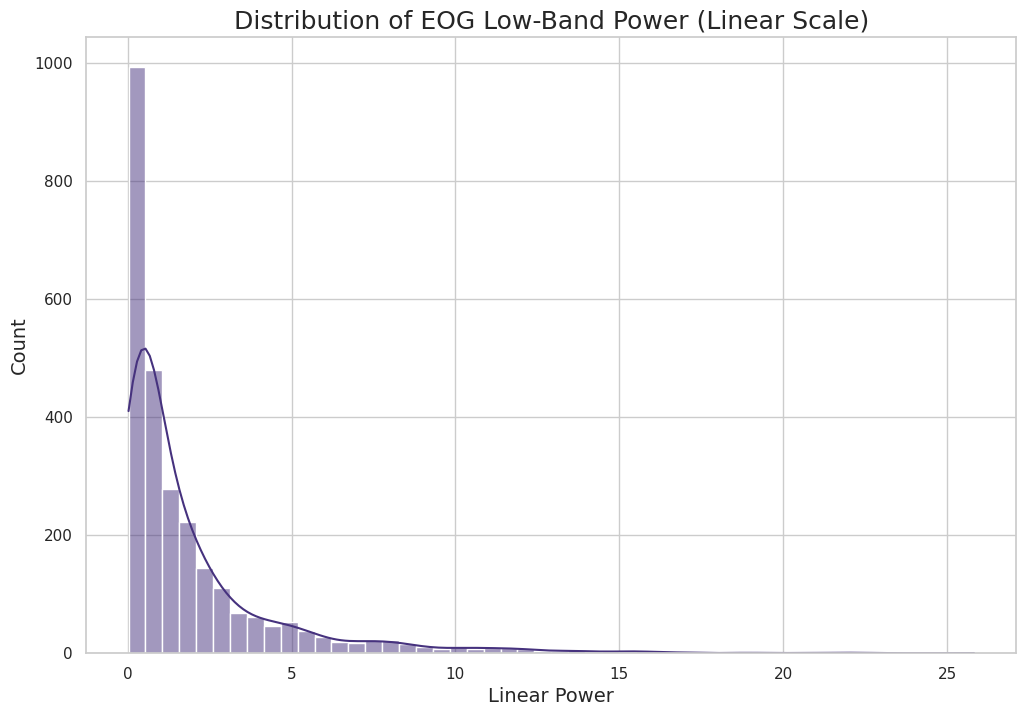

Saved: feature_visualizations/01_distribution_eog_linear.png


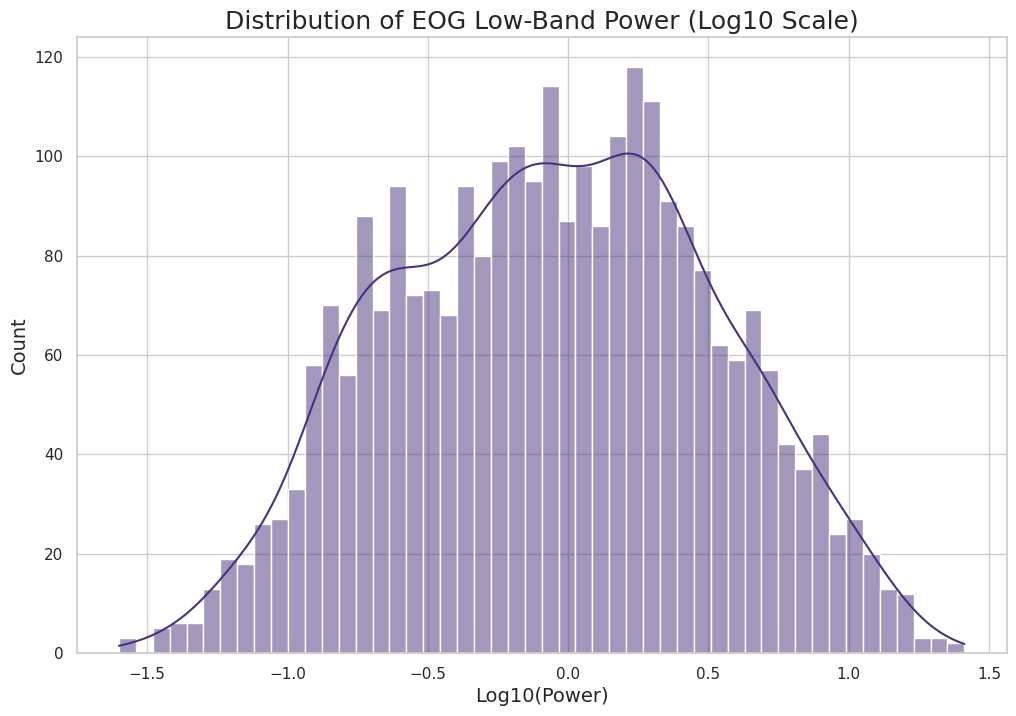

Saved: feature_visualizations/02_distribution_eog_log.png


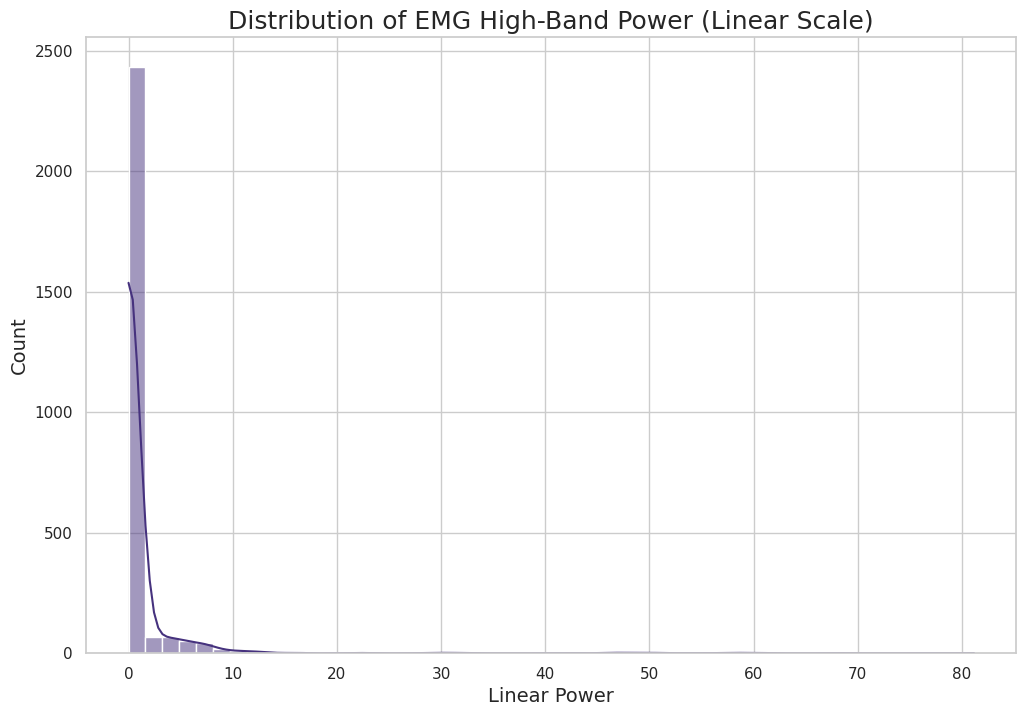

Saved: feature_visualizations/03_distribution_emg_linear.png


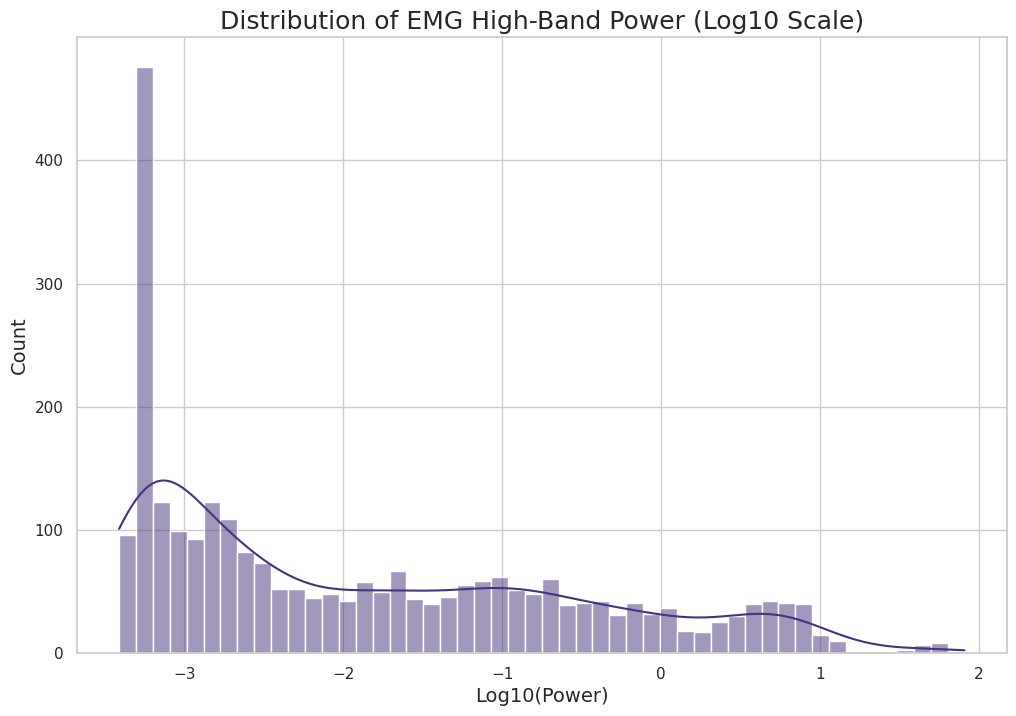

Saved: feature_visualizations/04_distribution_emg_log.png


In [ ]:
# =============================================================================
# CELL 2: VISUALIZATION 1 - INDIVIDUAL FEATURE DISTRIBUTIONS
# =============================================================================
# This cell generates and saves four separate plots showing the distribution
# of each feature on both linear and log scales.

print("\n--- Generating and saving individual feature distribution plots ---")

# --- Plot 1: EOG Linear Scale ---
plt.figure()
ax = sns.histplot(features_df['linear_power_eog'], kde=True, bins=50)
ax.set_title('Distribution of EOG Low-Band Power (Linear Scale)')
ax.set_xlabel('Linear Power')
ax.set_ylabel('Count')
filename = os.path.join(OUTPUT_DIR, "01_distribution_eog_linear.png")
plt.savefig(filename)
plt.show()
plt.close()
print(f"Saved: {filename}")

# --- Plot 2: EOG Log10 Scale ---
plt.figure()
ax = sns.histplot(features_df['log_power_eog'], kde=True, bins=50)
ax.set_title('Distribution of EOG Low-Band Power (Log10 Scale)')
ax.set_xlabel('Log10(Power)')
ax.set_ylabel('Count')
filename = os.path.join(OUTPUT_DIR, "02_distribution_eog_log.png")
plt.savefig(filename)
plt.show()
plt.close()
print(f"Saved: {filename}")

# --- Plot 3: EMG Linear Scale ---
plt.figure()
ax = sns.histplot(features_df['linear_power_emg'], kde=True, bins=50)
ax.set_title('Distribution of EMG High-Band Power (Linear Scale)')
ax.set_xlabel('Linear Power')
ax.set_ylabel('Count')
filename = os.path.join(OUTPUT_DIR, "03_distribution_emg_linear.png")
plt.savefig(filename)
plt.show()
plt.close()
print(f"Saved: {filename}")

# --- Plot 4: EMG Log10 Scale ---
plt.figure()
ax = sns.histplot(features_df['log_power_emg'], kde=True, bins=50)
ax.set_title('Distribution of EMG High-Band Power (Log10 Scale)')
ax.set_xlabel('Log10(Power)')
ax.set_ylabel('Count')
filename = os.path.join(OUTPUT_DIR, "04_distribution_emg_log.png")
plt.savefig(filename)
plt.show()
plt.close()
print(f"Saved: {filename}")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List

# --- Utility Function ---
# This helper function is crucial for managing tensor sizes in the skip connections.
def center_crop_to(x: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Center-crops or pads tensor `x` along its last dimension to match the size
    of the `target` tensor's last dimension. This is essential for concatenating
    tensors in the decoder (Up) path of the U-Net.
    """
    diff = x.shape[-1] - target.shape[-1]
    if diff == 0:
        return x
    elif diff > 0:
        # x is larger than target, so we crop x
        start = diff // 2
        end = start + target.shape[-1]
        return x[..., start:end]
    else:
        # x is smaller than target, so we pad x
        pad_left = (-diff) // 2
        pad_right = (-diff) - pad_left
        return F.pad(x, (pad_left, pad_right))

# --- U-Net Building Blocks ---
# These are the modular components that construct the U-Net.

class DoubleConv1D(nn.Module):
    """A block containing two 1D convolutions, each followed by BatchNorm and LeakyReLU."""
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 7):
        super().__init__()
        padding = kernel_size // 2
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv(x)

class Down1D(nn.Module):
    """A downsampling block using MaxPool followed by a DoubleConv1D block."""
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 7):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv1D(in_channels, out_channels, kernel_size)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool_conv(x)

class Up1D(nn.Module):
    """An upsampling block using Transposed Convolution, skip connection, and DoubleConv1D."""
    def __init__(self, in_ch_below: int, in_ch_skip: int, out_channels: int, kernel_size: int = 7):
        super().__init__()
        # Upsample the feature map from the layer below
        self.up = nn.ConvTranspose1d(in_ch_below, in_ch_below // 2, kernel_size=2, stride=2)
        # The convolutional block that processes the concatenated feature maps
        self.conv = DoubleConv1D(in_ch_skip + (in_ch_below // 2), out_channels, kernel_size)

    def forward(self, x_below: torch.Tensor, x_skip: torch.Tensor) -> torch.Tensor:
        # 1. Upsample the tensor from the deeper layer
        x_below = self.up(x_below)
        # 2. Crop/pad it to match the skip connection tensor size
        x_below = center_crop_to(x_below, x_skip)
        # 3. Concatenate with the skip connection
        x = torch.cat([x_skip, x_below], dim=1)
        # 4. Pass through the double convolution block
        return self.conv(x)

# --- The Main U-Net Generator Class ---
class UNet1DGenerator(nn.Module):
    """
    The complete 1D U-Net Generator. It takes a 3-channel condition tensor and a noise
    vector, injecting noise at both the input and the bottleneck for variability.
    """
    def __init__(self, input_length: int, num_channels: int, latent_dim: int,
                 channel_sizes: List[int] = [64, 128, 256, 512, 1024]):
        super().__init__()

        # --- Noise Projection Layers ---
        # Projects noise to match the dimensions of the input and the bottleneck
        self.noise_dense_input = nn.Linear(latent_dim, input_length)
        num_down_stages = len(channel_sizes) - 1
        bottleneck_len = input_length // (2**num_down_stages)
        self.noise_dense_bottleneck = nn.Linear(latent_dim, bottleneck_len)

        # --- Encoder (Downsampling Path) ---
        self.downs = nn.ModuleList()
        # Initial convolution block, takes (condition channels + 1 noise channel)
        self.inc = DoubleConv1D(num_channels + 1, channel_sizes[0])

        in_ch = channel_sizes[0]
        for out_ch in channel_sizes[1:]:
            self.downs.append(Down1D(in_ch, out_ch))
            in_ch = out_ch

        # --- Bottleneck ---
        # Takes (final downsampled channels + 1 noise channel)
        self.bottleneck_conv = DoubleConv1D(channel_sizes[-1] + 1, channel_sizes[-1])

        # --- Decoder (Upsampling Path) ---
        self.ups = nn.ModuleList()
        reversed_channels = channel_sizes[::-1]
        for i in range(len(reversed_channels) - 1):
            in_ch_below = reversed_channels[i]
            in_ch_skip = reversed_channels[i+1]
            self.ups.append(Up1D(in_ch_below, in_ch_skip, in_ch_skip))

        # --- Output Layer ---
        self.outc = nn.Conv1d(channel_sizes[0], 1, kernel_size=1) # Output 1 channel
        self.final_activation = nn.Tanh() # To scale output between -1 and 1

    def forward(self, condition_input: torch.Tensor, noise_input: torch.Tensor) -> torch.Tensor:
        # --- Input noise injection ---
        noise_proj_input = self.noise_dense_input(noise_input).unsqueeze(1)
        x = torch.cat([condition_input, noise_proj_input], dim=1)

        # --- Encoder path ---
        skip_connections = []
        x = self.inc(x)
        skip_connections.append(x)
        for down_layer in self.downs:
            x = down_layer(x)
            skip_connections.append(x)

        # The last element is the input to the bottleneck
        bottleneck_input = skip_connections.pop()

        # --- Bottleneck noise injection ---
        noise_proj_bottleneck = self.noise_dense_bottleneck(noise_input).unsqueeze(1)
        x_with_noise = torch.cat([bottleneck_input, noise_proj_bottleneck], dim=1)
        x = self.bottleneck_conv(x_with_noise)

        # --- Decoder path ---
        # Iterate backwards through skip connections
        for up_layer in self.ups:
            skip_connection = skip_connections.pop()
            x = up_layer(x, skip_connection)

        # --- Final Output ---
        logits = self.outc(x)
        out = self.final_activation(logits)

        # Ensure final output size matches the original EEG input size
        return center_crop_to(out, condition_input[:, 0:1, :])

print("✅ UNet1DGenerator and its components are now defined.")


class RobustCritic(nn.Module):
    def __init__(self, n_channels_in: int = 1,
                 channel_sizes: List[int] = [64, 128, 256, 512],
                 kernel_size: int = 5):
        super().__init__()

        def critic_block(in_filters, out_filters):
            return nn.Sequential(
                nn.Conv1d(in_filters, out_filters, kernel_size=kernel_size, stride=2, padding=kernel_size//2),
                nn.InstanceNorm1d(out_filters), nn.LeakyReLU(0.2, inplace=True)
            )

        layers = []
        layers.append(nn.Sequential(
            nn.Conv1d(n_channels_in, channel_sizes[0], kernel_size=kernel_size, stride=2, padding=kernel_size//2),
            nn.LeakyReLU(0.2, inplace=True)
        ))

        in_ch = channel_sizes[0]
        for out_ch in channel_sizes[1:]:
            layers.append(critic_block(in_ch, out_ch))
            in_ch = out_ch

        self.conv_body = nn.Sequential(*layers)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        final_channels = channel_sizes[-1]
        self.fc_head = nn.Sequential(
            nn.Linear(final_channels, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

        print(f"RobustCritic initialized programmatically with {len(channel_sizes)} conv blocks.")

    def forward(self, x: torch.Tensor, return_features: bool = False) -> torch.Tensor:
        x = self.conv_body(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)

        features = self.fc_head[0](x)
        features = self.fc_head[1](features)
        validity = self.fc_head[2](features)

        if return_features:
            return validity, features
        else:
            return validity

✅ UNet1DGenerator and its components are now defined.


### Gradient penalty

In [ ]:
import torch

def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """
    Computes the gradient penalty for WGAN-GP, ensuring the critic's gradient
    norm is 1 for points sampled between real and fake data distributions.

    Args:
        critic (nn.Module): The critic network.
        real_samples (torch.Tensor): A batch of real data samples.
                                     Shape: [batch, channels, length].
        fake_samples (torch.Tensor): A batch of fake data samples generated by the generator.
                                     Shape: [batch, channels, length].
        device (torch.device): The device (CPU or CUDA) to perform calculations on.

    Returns:
        torch.Tensor: A scalar tensor representing the gradient penalty loss.
    """
    # 1. Create random weights (alpha) for interpolation.
    #    Sampled from a uniform distribution [0, 1] as per the WGAN-GP paper.
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1, 1, device=device)

    # 2. Create interpolated samples by mixing real and fake data.
    #    These are the points where we will evaluate the critic's gradient.
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # 3. Get the critic's scores for these interpolated samples.
    d_interpolates = critic(interpolates)

    # 4. Calculate the gradients of the critic's scores with respect to the inputs.
    #    We use torch.ones_like to create a tensor of ones with the same shape
    #    and device as the critic's output, which is required for grad().
    grad_outputs = torch.ones_like(d_interpolates, device=device, requires_grad=False)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,  # Essential for the full WGAN-GP loss calculation
        retain_graph=True,  # We need to backprop through this later
        only_inputs=True,
    )[0]

    # 5. Reshape gradients and compute the penalty.
    #    The penalty is the mean squared difference between the L2 norm of the
    #    gradients and the target value of 1.
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

### CUDA

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("device being used:", device)
if torch.cuda.is_available():
    print("Current device:", torch.cuda.current_device())
    print("device name:", torch.cuda.get_device_name(0))

CUDA available: True
device being used: cuda
Current device: 0
device name: Tesla T4


##  Training


In [ ]:
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# import itertools
# import re # Import the regular expressions library
# import glob # Import glob to find files with patterns
# import json # Import json to load hyperparameters
# import pandas as pd # Import pandas for CSV handling

# # This script assumes the following are defined in your environment:
# # - The dataloader variables: `p_dataloaders` and `dataloaders` (both now dictionaries with 'train', 'val', 'test' keys)
# # - The model classes: `UNet1DGenerator` and `RobustCritic`
# # - The feature extraction functions: `feature_cond` and `feature_out`

# # =============================================================================
# # 1. HELPER FUNCTIONS (Self-Contained)
# # =============================================================================

# def compute_gradient_penalty(critic, real_samples, fake_samples, device):
#     """
#     Computes the gradient penalty for WGAN-GP, ensuring the critic's gradient
#     norm is 1 for points sampled between real and fake data distributions.

#     Args:
#         critic (nn.Module): The critic network.
#         real_samples (torch.Tensor): A batch of real data samples.
#                                      Shape: [batch, channels, length]. Must be on 'device'.
#         fake_samples (torch.Tensor): A batch of fake data samples generated by the generator.
#                                      Shape: [batch, channels, length]. Must be on 'device'.
#         device (torch.device): The device (CPU or CUDA) to perform calculations on.

#     Returns:
#         torch.Tensor: A scalar tensor representing the gradient penalty loss on 'device'.
#     """
#     # Ensure inputs are on the correct device (already done outside if following workflow)
#     # real_samples = real_samples.to(device) # Redundant if handled before calling
#     # fake_samples = fake_samples.to(device) # Redundant if handled before calling

#     # 1. Create random weights (alpha) for interpolation on the correct device.
#     #    Sampled from a uniform distribution [0, 1] as per the WGAN-GP paper.
#     batch_size = real_samples.size(0)
#     alpha = torch.rand(batch_size, 1, 1, device=device) # Ensure alpha is on the same device as samples

#     # 2. Create interpolated samples by mixing real and fake data on the correct device.
#     #    These are the points where we will evaluate the critic's gradient.
#     #    Ensure the result is also on 'device'.
#     interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True).to(device)

#     # 3. Get the critic's scores for these interpolated samples.
#     #    The critic should already be on 'device'.
#     d_interpolates = critic(interpolates) # Critic output will be on 'device'

#     # 4. Calculate the gradients of the critic's scores with respect to the inputs.
#     #    We use torch.ones_like to create a tensor of ones with the same shape
#     #    and device as the critic's output, which is required for grad().
#     grad_outputs = torch.ones_like(d_interpolates, device=device, requires_grad=False) # Ensure grad_outputs is on 'device'

#     # Calculate gradients, ensure the output is on 'device'
#     gradients = torch.autograd.grad(
#         outputs=d_interpolates,
#         inputs=interpolates,
#         grad_outputs=grad_outputs,
#         create_graph=True,  # Essential for the full WGAN-GP loss calculation
#         retain_graph=True,  # We need to backprop through this later
#         only_inputs=True,
#     )[0].to(device) # Ensure gradients are on 'device'

#     # 5. Reshape gradients and compute the penalty.
#     #    The penalty is the mean squared difference between the L2 norm of the
#     #    gradients and the target value of 1. Calculation should be on 'device'.
#     gradients = gradients.view(batch_size, -1)
#     gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean().to(device) # Ensure final penalty is on 'device'

#     return gradient_penalty

# def save_checkpoint(state, filename):
#     """
#     Saves the current state of training including model, optimizer, and epoch.

#     Args:
#         state (dict): A dictionary containing the state to save (e.g., model state dicts, optimizer state dicts, epoch number, best validation loss).
#         filename (str): The path and filename where the checkpoint should be saved.
#     """
#     print(f"=> Saving checkpoint to {filename}")
#     torch.save(state, filename)

# def load_latest_checkpoint(checkpoint_dir, generator, critic, opt_g, opt_c, device):
#     """
#     Finds and loads the latest numbered checkpoint file.
#     This is for resuming training from the last saved point.

#     Args:
#         checkpoint_dir (str): Directory where checkpoints are saved.
#         generator (nn.Module): The generator model.
#         critic (nn.Module): The critic model.
#         opt_g (optim.Optimizer): The generator optimizer.
#         opt_c (optim.Optimizer): The critic optimizer.
#         device (torch.device): The device (CPU or CUDA) models and optimizers should be loaded onto.

#     Returns:
#         tuple: A tuple containing (start_epoch, best_val_loss, training_log_df). Returns (0, float('inf'), empty DataFrame) if no checkpoint is found.
#     """
#     start_epoch = 0
#     best_val_loss = float('inf') # Initialize best validation loss
#     training_log_df = pd.DataFrame() # Initialize an empty DataFrame for the log

#     if not os.path.isdir(checkpoint_dir):
#         print("=> No checkpoint directory found, starting from scratch.")
#         return start_epoch, best_val_loss, training_log_df

#     # Use glob to find any file matching the pattern for numbered checkpoints
#     checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "checkpoint_epoch_*.pth"))

#     # If numbered checkpoints exist, find the latest one
#     if checkpoint_files:
#         # Sort files by epoch number to find the latest
#         checkpoint_files.sort(key=lambda f: int(re.search(r'_epoch_(\d+)\.pth', f).group(1)))
#         latest_checkpoint_path = checkpoint_files[-1] # Load the latest numbered checkpoint

#         print(f"=> Loading latest numbered checkpoint: '{latest_checkpoint_path}'")
#         # Load checkpoint onto the specified device, setting weights_only=False
#         checkpoint = torch.load(latest_checkpoint_path, map_location=device, weights_only=False)
#         generator.load_state_dict(checkpoint['generator_state_dict'])
#         critic.load_state_dict(checkpoint['critic_state_dict'])
#         opt_g.load_state_dict(checkpoint['optimizer_gen_state_dict'])
#         opt_c.load_state_dict(checkpoint['optimizer_critic_state_dict'])
#         start_epoch = checkpoint['epoch']
#         best_val_loss = checkpoint.get('best_val_loss', float('inf')) # Safely get best_val_loss

#         # Load the training log if it exists
#         log_file_path = os.path.join(checkpoint_dir, "training_log.csv")
#         if os.path.exists(log_file_path):
#             try:
#                 training_log_df = pd.read_csv(log_file_path)
#                 print(f"=> Loaded existing training log from {log_file_path}")
#             except Exception as e:
#                 print(f"Warning: Could not load training log from {log_file_path}: {e}. Starting a new log.")
#                 training_log_df = pd.DataFrame()

#         print(f"=> Resuming training from epoch {start_epoch + 1} (loaded best val loss: {best_val_loss:.4f})")

#         # Optional: Clean up all numbered checkpoints except the latest one
#         for i, f in enumerate(checkpoint_files):
#              if i < len(checkpoint_files) - 1:
#                 try:
#                     os.remove(f)
#                     print(f"   Cleaned up old checkpoint: {f}")
#                 except OSError as e:
#                     print(f"   Error cleaning up old checkpoint {f}: {e}")

#         return start_epoch, best_val_loss, training_log_df

#     else:
#         print("=> No numbered checkpoint file found, starting from scratch.")
#         return start_epoch, best_val_loss, training_log_df


# # =============================================================================
# # 2. CONFIGURATION
# # =============================================================================
# # Define the base directory in Google Drive
# GOOGLE_DRIVE_BASE_DIR = "/content/drive/My Drive/FYP/" # Ensure this path is correct

# # Update checkpoint and visualization directories to point to Google Drive
# CHECKPOINT_DIR = os.path.join(GOOGLE_DRIVE_BASE_DIR, "checkpoints")
# OUTPUT_VIZ_DIR = os.path.join(GOOGLE_DRIVE_BASE_DIR, "training_visualizations")
# # Define the path for the training log CSV file (moved to checkpoints directory)
# TRAINING_LOG_FILE = os.path.join(CHECKPOINT_DIR, "training_log.csv")


# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Assuming these are defined in a previous cell (like the one with LEARNING_RATE etc.)
# N_EPOCHS = 100 # You can adjust this as needed, 50 is a reasonable starting point
# LATENT_DIM = 100
# INPUT_LENGTH = 320
# FS = 160

# LAMBDA_GP = 10 # Kept fixed


# # --- Load Hyperparameters from File ---
# # Update the path to load from Google Drive as well
# best_params_filename = os.path.join(GOOGLE_DRIVE_BASE_DIR, "best_hyperparameters.json")

# try:
#     with open(best_params_filename, 'r') as f:
#         best_params = json.load(f)
#     print(f"Successfully loaded best hyperparameters from '{best_params_filename}'")
#     LEARNING_RATE_GEN = best_params.get("lr_gen", 1e-4) # Default if key missing
#     LEARNING_RATE_CRITIC = best_params.get("lr_critic", 1e-4) # Default if key missing
#     LAMBDA_FEAT = best_params.get("lambda_feat", 50.0) # Default if key missing
#     N_CRITIC = best_params.get("n_critic", 5) # Default if key missing

#     print("Using hyperparameters:")
#     print(f"  LEARNING_RATE_GEN: {LEARNING_RATE_GEN}")
#     print(f"  LEARNING_RATE_CRITIC: {LEARNING_RATE_CRITIC}")
#     print(f"  LAMBDA_FEAT: {LAMBDA_FEAT}")
#     print(f"  N_CRITIC: {N_CRITIC}")

# except FileNotFoundError:
#     print(f"Warning: Hyperparameter file '{best_params_filename}' not found. Using default values.")
#     # --- Default Hyperparameters (if file not found) ---
#     LEARNING_RATE_GEN = 1e-4
#     LEARNING_RATE_CRITIC = 1e-4
#     LAMBDA_FEAT = 50.0
#     N_CRITIC = 5

# except json.JSONDecodeError:
#     print(f"Error: Could not decode JSON from '{best_params_filename}'. Using default values.")
#     # --- Default Hyperparameters (if file decoding fails) ---
#     LEARNING_RATE_GEN = 1e-4
#     LEARNING_RATE_CRITIC = 1e-4
#     LAMBDA_FEAT = 50.0
#     N_CRITIC = 5
# except Exception as e:
#     print(f"An unexpected error occurred while loading hyperparameters: {e}. Using default values.")
#     # --- Default Hyperparameters (for other errors) ---
#     LEARNING_RATE_GEN = 1e-4
#     LEARNING_RATE_CRITIC = 1e-4
#     LAMBDA_FEAT = 50.0
#     N_CRITIC = 5


# BETA1 = 0.5 # Kept fixed as per original script / common GAN practice
# BETA2 = 0.9 # Kept fixed as per original script / common GAN practice


# # =============================================================================
# # 3. SETUP & INITIALIZATION
# # =============================================================================
# # Create directories in Google Drive
# os.makedirs(CHECKPOINT_DIR, exist_ok=True)
# os.makedirs(OUTPUT_VIZ_DIR, exist_ok=True)
# print(f"Using device: {DEVICE}")
# print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")
# print(f"Visualizations will be saved to: {OUTPUT_VIZ_DIR}")
# print(f"Training log will be saved to: {TRAINING_LOG_FILE}")


# try:
#     # Use the split PhysioNet dataloaders (p_dataloaders is now a dict)
#     real_noisy_loader_train = p_dataloaders["train"]
#     real_noisy_loader_val = p_dataloaders["val"]
#     # dataloaders dictionary is assumed to contain loaders for EEGdenoiseNet (conditions) data
#     cond_loader_train = dataloaders["train"] # Training loader for conditions
#     cond_loader_val = dataloaders["val"]   # Validation loader for conditions
#     print("Successfully assigned dataloaders.")
# except NameError as e:
#     print(f"--- FATAL ERROR: Dataloader not found: {e} ---")
#     print("Please ensure 'p_dataloaders' and 'dataloaders' (both with 'train', 'val', 'test' keys) are defined.")
#     raise # Re-raise the error to stop execution if dataloaders are missing


# # Initialize models and move them to the specified device
# generator = UNet1DGenerator(input_length=INPUT_LENGTH, num_channels=3, latent_dim=LATENT_DIM).to(DEVICE)
# critic = RobustCritic(n_channels_in=1).to(DEVICE)

# # Initialize optimizers with the best learning rates from Optuna
# optimizer_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE_GEN, betas=(BETA1, BETA2))
# optimizer_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE_CRITIC, betas=(BETA1, BETA2))

# class FeatureMatchingLoss(nn.Module):
#     def __init__(self, fs=160):
#         super().__init__()
#         self.fs = fs
#         self.loss_fn = nn.L1Loss() # Using L1 Loss for feature matching
#     def forward(self, generated_batch, condition_batch):
#         # Ensure feature extraction functions are called on the correct device
#         gen_features = feature_out(generated_batch, self.fs).to(generated_batch.device)
#         target_features = feature_cond(condition_batch, self.fs).to(condition_batch.device)
#         return self.loss_fn(gen_features, target_features)

# feature_loss = FeatureMatchingLoss(fs=FS).to(DEVICE)

# # Load checkpoint and get initial best_val_loss and training log
# # This function also moves model and optimizer states to the specified device
# start_epoch, best_val_loss, training_log_df = load_latest_checkpoint(CHECKPOINT_DIR, generator, critic, optimizer_gen, optimizer_critic, DEVICE)

# # =============================================================================
# # 4. THE TRAINING LOOP
# # =============================================================================
# print("\n--- Starting Training ---")

# # This variable will keep track of the old numbered checkpoint file to delete
# last_checkpoint_filename = ""

# # Determine which TRAIN loader is larger for consistent iteration during training
# # Using itertools.cycle on the smaller TRAIN loader ensures both datasets are used
# if len(real_noisy_loader_train) > len(cond_loader_train):
#     main_loader = real_noisy_loader_train
#     secondary_loader_iter = itertools.cycle(iter(cond_loader_train))
#     is_real_main = True # real_noisy_loader_train is the main one iterated over
# else:
#     main_loader = cond_loader_train
#     secondary_loader_iter = itertools.cycle(iter(real_noisy_loader_train))
#     is_real_main = False # cond_loader_train is the main one iterated over

# # --- Lists to store epoch-wise metrics for plotting ---
# # Initialize or append based on loaded log
# if training_log_df.empty:
#     epochs_list = []
#     avg_c_losses = []
#     avg_g_losses = []
#     avg_val_feature_losses = []
#     avg_val_critic_real_scores = []
#     avg_val_critic_fake_scores = []
# else:
#     epochs_list = training_log_df['Epoch'].tolist()
#     avg_c_losses = training_log_df['Avg_Critic_Loss'].tolist()
#     avg_g_losses = training_log_df['Avg_Generator_Loss'].tolist()
#     avg_val_feature_losses = training_log_df['Avg_Val_Feature_Loss'].tolist()
#     avg_val_critic_real_scores = training_log_df['Avg_Val_Critic_Real_Score'].tolist()
#     avg_val_critic_fake_scores = training_log_df['Avg_Val_Critic_Fake_Score'].tolist()


# for epoch in range(start_epoch, N_EPOCHS):
#     generator.train() # Set generator to training mode
#     critic.train()   # Set critic to training mode

#     # Initialize epoch losses
#     epoch_c_loss = 0.0
#     epoch_g_loss = 0.0
#     num_batches = 0

#     # Use tqdm for a progress bar during the training epoch
#     prog_bar = tqdm(main_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}")

#     for i, main_batch in enumerate(prog_bar):
#         # Fetch the corresponding batch from the other dataloader
#         secondary_batch = next(secondary_loader_iter)

#         # Assign batches correctly based on which loader is iterated as main
#         if is_real_main:
#             real_noisy_batch = main_batch
#             conditions_batch = secondary_batch
#         else:
#             real_noisy_batch = secondary_batch
#             conditions_batch = main_batch

#         # --- Correctly handle batch content (tensor vs. list/tuple from DataLoader) ---
#         # Dataloaders might return a tuple/list if they yield multiple items per index.
#         # Assuming the first element is the data tensor.
#         real_noisy = real_noisy_batch[0] if isinstance(real_noisy_batch, (list, tuple)) else real_noisy_batch
#         conditions = conditions_batch[0] if isinstance(conditions_batch, (list, tuple)) else conditions_batch

#         # --- Align batch sizes and move to device ---
#         # This handles cases where the last batch might be smaller
#         current_batch_size = min(real_noisy.size(0), conditions.size(0))
#         real_noisy = real_noisy[:current_batch_size].to(DEVICE)
#         conditions = conditions[:current_batch_size].to(DEVICE)

#         # --- Final safeguard for real_noisy shape ---
#         # Ensure real_noisy has a channel dimension [batch, 1, seq_len]
#         if real_noisy.dim() == 2:
#             real_noisy = real_noisy.unsqueeze(1)

#         # ---------------------
#         #  Train Critic
#         # ---------------------
#         optimizer_critic.zero_grad() # Zero gradients for the critic

#         # Generate fake data (detach from generator graph for critic training)
#         noise = torch.randn(current_batch_size, LATENT_DIM, device=DEVICE) # Generate noise on device
#         with torch.no_grad(): # No gradients needed for generator during critic update
#             fake_noisy = generator(conditions, noise).detach() # Generate on device, detach

#         # Calculate critic loss (Wasserstein distance + Gradient Penalty)
#         real_score = critic(real_noisy) # critic output is on DEVICE
#         fake_score = critic(fake_noisy) # critic output is on DEVICE

#         # Compute gradient penalty, ensure calculation is on DEVICE
#         gradient_penalty = compute_gradient_penalty(critic, real_noisy, fake_noisy, DEVICE)

#         # Total critic loss
#         loss_critic = fake_score.mean() - real_score.mean() + LAMBDA_GP * gradient_penalty
#         loss_critic = loss_critic.to(DEVICE) # Ensure loss is on DEVICE for backward

#         # Backpropagate and update critic weights
#         loss_critic.backward()
#         optimizer_critic.step()

#         # Accumulate critic loss
#         epoch_c_loss += loss_critic.item()

#         # ---------------------
#         #  Train Generator
#         # ---------------------
#         # Train generator every N_CRITIC steps (best from Optuna)
#         if i % N_CRITIC == 0: # Use trial's n_critic
#             optimizer_gen.zero_grad() # Zero gradients for the generator

#             # Generate fake data again (gradients needed for generator update)
#             noise = torch.randn(current_batch_size, LATENT_DIM, device=DEVICE) # Generate new noise on device
#             gen_fake = generator(conditions, noise) # Generate on device

#             # Calculate generator loss (adversarial + feature matching)
#             gen_score = critic(gen_fake) # critic output is on DEVICE
#             loss_gen_adv = -gen_score.mean() # Adversarial loss (maximize critic score for fake)
#             loss_gen_adv = loss_gen_adv.to(DEVICE) # Ensure loss is on DEVICE

#             # Calculate feature matching loss
#             # feature_loss object is on DEVICE, forward call should handle tensors on DEVICE
#             loss_feat = feature_loss(gen_fake, conditions) # Feature loss is on DEVICE
#             loss_feat = loss_feat.to(DEVICE) # Ensure loss is on DEVICE

#             # Total generator loss (best lambda_feat from Optuna)
#             loss_gen = loss_gen_adv + LAMBDA_FEAT * loss_feat
#             loss_gen = loss_gen.to(DEVICE) # Ensure total loss is on DEVICE for backward

#             # Backpropagate and update generator weights
#             loss_gen.backward()
#             optimizer_gen.step()

#             # Accumulate generator loss
#             epoch_g_loss += loss_gen.item()
#             # Note: epoch_g_loss is less meaningful if N_CRITIC > 1, but still gives a general idea.


#         num_batches += 1

#         # --- Update Progress Bar ---
#         # Display current batch losses
#         prog_bar.set_postfix({
#             'C_Loss': f'{loss_critic.item():.3f}',
#             'G_Loss': f'{loss_gen.item():.3f}' if 'loss_gen' in locals() else 'N/A', # Only show if generator trained
#             'GP': f'{gradient_penalty.item():.2f}'
#         })

#     # --- End of Epoch Tasks ---

#     # Calculate average epoch losses (approximate for generator if not trained every batch)
#     avg_epoch_c_loss = epoch_c_loss / num_batches
#     # A more accurate G loss average would only sum/count when G trains.
#     # For simplicity, using total batches / N_CRITIC:
#     avg_epoch_g_loss = epoch_g_loss / (num_batches // N_CRITIC) if num_batches >= N_CRITIC else 0.0
#     if num_batches < N_CRITIC: print("Warning: Generator trained less than once this epoch.")


#     print(f"\nEpoch {epoch+1} Average Critic Loss: {avg_epoch_c_loss:.4f}")
#     print(f"Epoch {epoch+1} Average Generator Loss: {avg_epoch_g_loss:.4f}")


#     # --- 1. Evaluate on Validation Set ---
#     generator.eval() # Set generator to evaluation mode
#     critic.eval() # Set critic to evaluation mode for consistent evaluation

#     val_feature_losses = []
#     val_critic_scores_real = []
#     val_critic_scores_fake = []


#     with torch.no_grad(): # No gradients needed for validation
#         # Determine which VALIDATION loader is larger for consistent iteration during validation
#         # Use the validation loaders: real_noisy_loader_val and cond_loader_val
#         if len(real_noisy_loader_val) > len(cond_loader_val): # Compare VAL loaders here
#              main_val_loader = real_noisy_loader_val # PhysioNet VAL is main
#              secondary_val_loader_iter = itertools.cycle(iter(cond_loader_val)) # Conditions VAL cycled
#              is_real_main_val = True
#         else:
#              main_val_loader = cond_loader_val # Conditions VAL is main
#              secondary_val_loader_iter = itertools.cycle(iter(real_noisy_loader_val)) # PhysioNet VAL cycled
#              is_real_main_val = False


#         val_prog_bar = tqdm(main_val_loader, desc=f"Validation Epoch {epoch+1}")
#         for val_i, main_val_batch in enumerate(val_prog_bar):
#              secondary_val_batch = next(secondary_val_loader_iter)

#              # Assign batches correctly based on which loader is larger
#              if is_real_main_val:
#                  real_noisy_val_batch = main_val_batch
#                  conditions_val_batch = secondary_val_batch
#              else:
#                  real_noisy_val_batch = secondary_val_batch
#                  conditions_val_batch = main_val_batch

#              real_noisy_val = real_noisy_val_batch[0] if isinstance(real_noisy_val_batch, (list, tuple)) else real_noisy_val_batch
#              conditions_val = conditions_val_batch[0] if isinstance(conditions_val_batch, (list, tuple)) else conditions_val_batch

#              current_val_batch_size = min(real_noisy_val.size(0), conditions_val.size(0))
#              real_noisy_val = real_noisy_val[:current_val_batch_size].to(DEVICE)
#              conditions_val = conditions_val[:current_val_batch_size].to(DEVICE)

#              if real_noisy_val.dim() == 2:
#                 real_noisy_val = real_noisy_val.unsqueeze(1)

#              # Generate fake noisy data for validation on DEVICE
#              noise_val = torch.randn(current_val_batch_size, LATENT_DIM, device=DEVICE)
#              fake_noisy_val = generator(conditions_val, noise_val)

#              # Calculate validation metrics on DEVICE
#              loss_feat_val = feature_loss(fake_noisy_val, conditions_val) # Feature loss on DEVICE
#              val_feature_losses.append(loss_feat_val.item())

#              # Optional: Track critic scores for validation
#              val_real_score = critic(real_noisy_val) # Critic output on DEVICE
#              val_fake_score = critic(fake_noisy_val) # Critic output on DEVICE
#              val_critic_scores_real.append(val_real_score.mean().item())
#              val_critic_scores_fake.append(val_fake_score.mean().item())

#              val_prog_bar.set_postfix({
#                  'Val_Feat_Loss': f'{loss_feat_val.item():.4f}',
#                  'Val_C_Real': f'{val_real_score.mean().item():.4f}',
#                  'Val_C_Fake': f'{val_fake_score.mean().item():.4f}'
#              })


#     avg_val_feature_loss = np.mean(val_feature_losses)
#     avg_val_critic_score_real = np.mean(val_critic_scores_real)
#     avg_val_critic_score_fake = np.mean(val_critic_scores_fake)

#     print(f"\nEpoch {epoch+1} Validation Feature Loss: {avg_val_feature_loss:.4f}")
#     print(f"Epoch {epoch+1} Validation Critic Real Score: {avg_val_critic_score_real:.4f}")
#     print(f"Epoch {epoch+1} Validation Critic Fake Score: {avg_val_critic_score_fake:.4f}")

#     # --- Log Epoch Metrics to CSV ---
#     epoch_data = {
#         'Epoch': epoch + 1,
#         'Avg_Critic_Loss': avg_epoch_c_loss,
#         'Avg_Generator_Loss': avg_epoch_g_loss,
#         'Avg_Val_Feature_Loss': avg_val_feature_loss,
#         'Avg_Val_Critic_Real_Score': avg_val_critic_score_real,
#         'Avg_Val_Critic_Fake_Score': avg_val_critic_score_fake,
#         'Best_Val_Loss_So_Far': best_val_loss # Log the best seen so far
#     }
#     # Create a DataFrame for the current epoch's data and append it to the CSV
#     epoch_df = pd.DataFrame([epoch_data])
#     # Append to the main training log DataFrame
#     training_log_df = pd.concat([training_log_df, epoch_df], ignore_index=True)
#     # Save the updated DataFrame to CSV
#     training_log_df.to_csv(TRAINING_LOG_FILE, index=False)
#     print(f"Logged epoch {epoch+1} metrics to {TRAINING_LOG_FILE}")

#     # Append metrics to the lists for plotting
#     epochs_list.append(epoch + 1)
#     avg_c_losses.append(avg_epoch_c_loss)
#     avg_g_losses.append(avg_epoch_g_loss)
#     avg_val_feature_losses.append(avg_val_feature_loss)
#     avg_val_critic_real_scores.append(avg_val_critic_score_real)
#     avg_val_critic_fake_scores.append(avg_val_critic_score_fake)


#     # --- 2. Save Checkpoints ---
#     # Define the filename for the current epoch's checkpoint
#     current_checkpoint_filename = os.path.join(CHECKPOINT_DIR, f"checkpoint_epoch_{epoch+1}.pth")

#     # Save the current epoch's checkpoint (can be used for resuming training)
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'generator_state_dict': generator.state_dict(),
#         'critic_state_dict': critic.state_dict(),
#         'optimizer_gen_state_dict': optimizer_gen.state_dict(),
#         'optimizer_critic_state_dict': optimizer_critic.state_dict(),
#         'best_val_loss': best_val_loss, # Include best_val_loss
#         'avg_val_feature_loss': avg_val_feature_loss, # Save current validation loss
#         'avg_epoch_c_loss': avg_epoch_c_loss, # Save current epoch training losses
#         'avg_epoch_g_loss': avg_epoch_g_loss
#     }, filename=current_checkpoint_filename)

#     # Check if the current validation loss is the best seen so far
#     # Using validation feature loss as the primary metric for 'best' model
#     if avg_val_feature_loss < best_val_loss:
#         best_val_loss = avg_val_feature_loss
#         best_model_filename = os.path.join(CHECKPOINT_DIR, "best_model.pth")
#         print(f"=> Saving best model checkpoint with validation loss {best_val_loss:.4f}")
#         save_checkpoint({
#             'epoch': epoch + 1,
#             'generator_state_dict': generator.state_dict(),
#             # Optionally save critic and optimizers for the best model for full resume capability
#             'critic_state_dict': critic.state_dict(),
#             'optimizer_gen_state_dict': optimizer_gen.state_dict(),
#             'optimizer_critic_state_dict': optimizer_critic.state_dict(),
#             'best_val_loss': best_val_loss,
#             'avg_val_feature_loss': avg_val_feature_loss,
#             'avg_epoch_c_loss': avg_epoch_c_loss,
#             'avg_epoch_g_loss': avg_epoch_g_loss
#         }, filename=best_model_filename)

#     # --- 3. Clean up old numbered checkpoint (optional, to save space) ---
#     # Delete the previous epoch's numbered checkpoint
#     # Note: This cleanup logic should ideally happen *after* saving the new checkpoint
#     # and before the next epoch starts.
#     # We keep the 'last_checkpoint_filename' logic to track the previous one to delete.
#     if last_checkpoint_filename and os.path.exists(last_checkpoint_filename):
#          print(f"=> Deleting old numbered checkpoint: {last_checkpoint_filename}")
#          try:
#              os.remove(last_checkpoint_filename)
#          except OSError as e:
#              print(f"   Error deleting old checkpoint {last_checkpoint_filename}: {e}")

#     # Remember the name of the file we just saved for the next iteration's cleanup
#     last_checkpoint_filename = current_checkpoint_filename


#     # --- 4. Visualization ---
#     # Save visualization plots every 5 epochs
#     if (epoch + 1) % 5 == 0:
#         generator.eval() # Ensure generator is in eval mode for visualization
#         # We use cond_loader_val for visualization as it provides the condition input
#         with torch.no_grad():
#             # Fetch a batch for visualization from the validation set
#             try:
#                 # Reset iterator or get a new one to ensure fresh data
#                 viz_conditions_batch = next(iter(dataloaders['val']))
#                 viz_conditions = (viz_conditions_batch[0] if isinstance(viz_conditions_batch, (list, tuple)) else viz_conditions_batch).to(DEVICE)

#                 # For comparison, you might also want a real noisy sample if available and aligned
#                 # However, the primary visualization is generated vs. the clean input condition
#                 # If you want to show real noisy too, you'd need to sample from real_noisy_loader
#                 # and ensure some form of alignment or careful selection.
#                 # For now, we focus on the generated output from a clean condition.

#             except StopIteration:
#                 print(f"Warning: Validation dataloader ('dataloaders[\"val\"]') is empty, skipping visualization.")
#                 viz_conditions = None # Set to None to skip plotting if empty

#             if viz_conditions is not None:
#                 # Generate fake noisy data for visualization on DEVICE
#                 viz_noise = torch.randn(viz_conditions.size(0), LATENT_DIM, device=DEVICE)
#                 viz_fake_noisy = generator(viz_conditions, viz_noise)

#                 # Ensure the first channel of the condition is the clean EEG for plotting
#                 # Ensure the generated output is also 1 channel for plotting
#                 if viz_conditions.shape[1] > 0 and viz_fake_noisy.shape[1] == 1:
#                      clean_eeg_sample = viz_conditions[0, 0, :].cpu().numpy()
#                      generated_sample = viz_fake_noisy[0, 0, :].cpu().numpy()

#                      fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
#                      fig.suptitle(f'Epoch {epoch+1} - Generated vs. Clean Input (Validation Data)', fontsize=16)
#                      axs[0].plot(clean_eeg_sample, label="Input: Clean EEG", color='blue', alpha=0.8)
#                      axs[0].set_title("Input: Clean EEG")
#                      axs[0].set_ylabel("Amplitude") # Add y-label
#                      axs[0].grid(True, linestyle='--', alpha=0.6)
#                      axs[0].legend(loc='upper right')

#                      axs[1].plot(generated_sample, label="Output: Generated Noisy EEG", color='crimson', alpha=0.8)
#                      axs[1].set_title("Output: Generated Noisy EEG")
#                      axs[1].set_xlabel("Time Steps") # Add x-label to the bottom plot
#                      axs[1].set_ylabel("Amplitude") # Add y-label
#                      axs[1].grid(True, linestyle='--', alpha=0.6)
#                      axs[1].legend(loc='upper right')

#                      plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
#                      # Save the plot
#                      filename = os.path.join(OUTPUT_VIZ_DIR, f"epoch_{epoch+1:04d}_samples.png")
#                      plt.savefig(filename)
#                      plt.close(fig) # Close the figure to free memory
#                 else:
#                      print("Warning: Skipping sample visualization due to unexpected tensor shapes.")
#                      print(f" viz_conditions shape: {viz_conditions.shape}, viz_fake_noisy shape: {viz_fake_noisy.shape}")

#     # --- Plot Loss and Score Curves ---
#     # Plotting every 5 epochs as requested
#     if (epoch + 1) % 5 == 0 or (epoch + 1) == N_EPOCHS:
#         print("\nGenerating loss and score plots...")

#         # Plot 1: Training and Validation Losses
#         plt.figure(figsize=(12, 6))
#         plt.plot(epochs_list, avg_c_losses, label='Avg Critic Loss (Train)', marker='o', linestyle='-')
#         # Note: Avg Generator Loss during training is less stable due to N_CRITIC steps,
#         # but we can still plot it for general trend.
#         plt.plot(epochs_list, avg_g_losses, label='Avg Generator Loss (Train)', marker='o', linestyle='-')
#         plt.plot(epochs_list, avg_val_feature_losses, label='Avg Val Feature Loss', marker='x', linestyle='--')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.title('Training and Validation Losses over Epochs')
#         plt.legend()
#         plt.grid(True)
#         loss_plot_filename = os.path.join(OUTPUT_VIZ_DIR, "training_validation_losses.png")
#         plt.savefig(loss_plot_filename)
#         plt.show()
#         plt.close()
#         print(f"Saved loss plot: {loss_plot_filename}")

#         # Plot 2: Validation Critic Scores
#         plt.figure(figsize=(12, 6))
#         plt.plot(epochs_list, avg_val_critic_real_scores, label='Avg Val Critic Score (Real)', marker='o', linestyle='-')
#         plt.plot(epochs_list, avg_val_critic_fake_scores, label='Avg Val Critic Score (Fake)', marker='o', linestyle='-')
#         plt.xlabel('Epoch')
#         plt.ylabel('Critic Score')
#         plt.title('Validation Critic Scores over Epochs')
#         plt.legend()
#         plt.grid(True)
#         score_plot_filename = os.path.join(OUTPUT_VIZ_DIR, "validation_critic_scores.png")
#         plt.savefig(score_plot_filename)
#         plt.show()
#         plt.close()
#         print(f"Saved score plot: {score_plot_filename}")


# print("\n--- Training Finished ---")

### CGAN TRAINING

## Finish Task

The evaluation process is now complete. We loaded the trained generator, evaluated its performance on the test set using the feature matching loss, and visualized some generated samples compared to the real noisy data and the clean input. The average feature matching loss provides a quantitative measure of how well the generated data's features match the target features extracted from the condition signals. The visualizations allow for a qualitative assessment of the generated signal quality.

## Hyperparameter Tuning with Bayesian Optimization (using Optuna)

In [ ]:
# Install Optuna
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 8.6 MB/s eta 0:00:00


This section implements Bayesian Optimization using the `Optuna` library to find the best hyperparameters for your GAN training. We will define an objective function that trains the GAN for a limited number of epochs with sampled hyperparameters and returns the validation feature matching loss. Optuna will then minimize this objective function to find the optimal hyperparameters.

In [ ]:
# import optuna
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# import itertools
# import os
# import gc # Import garbage collector
# from functools import partial # Import partial to pass arguments to objective
# import torch.nn.functional as F # Import F for center_crop_to
# from typing import List # Import List for type hinting
# from torch.utils.data import DataLoader, Dataset, random_split # Import necessary components
# import json # Import json to save and load parameters


# # Ensure the necessary components from previous cells are available:
# # - feature_cond, feature_out
# # - PhysioNetEEGSegmentDataset (defined previously)
# # - channel_names, physionet_dir, target_channels, PRE_NORMALIZED_FLAG (defined previously)


# # =============================================================================
# #  MODEL DEFINITIONS (Moved here for accessibility)
# # =============================================================================
# # These definitions were previously in cell nfVNOM8rShDS
# # --- Utility Function ---
# # This helper function is crucial for managing tensor sizes in the skip connections.
# def center_crop_to(x: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
#     """
#     Center-crops or pads tensor `x` along its last dimension to match the size
#     of the `target` tensor's last dimension. This is essential for concatenating
#     tensors in the decoder (Up) path of the U-Net.
#     """
#     diff = x.shape[-1] - target.shape[-1]
#     if diff == 0:
#         return x
#     elif diff > 0:
#         # x is larger than target, so we crop x
#         start = diff // 2
#         end = start + target.shape[-1]
#         return x[..., start:end]
#     else:
#         # x is smaller than target, so we pad x
#         pad_left = (-diff) // 2
#         pad_right = (-diff) - pad_left
#         return F.pad(x, (pad_left, pad_right))

# # --- U-Net Building Blocks ---
# # These are the modular components that construct the U-Net.

# class DoubleConv1D(nn.Module):
#     """A block containing two 1D convolutions, each followed by BatchNorm and LeakyReLU."""
#     def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 7):
#         super().__init__()
#         padding = kernel_size // 2
#         self.double_conv = nn.Sequential(
#             nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
#             nn.BatchNorm1d(out_channels),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
#             nn.BatchNorm1d(out_channels),
#             nn.LeakyReLU(0.2, inplace=True)
#         )
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.double_conv(x)

# class Down1D(nn.Module):
#     """A downsampling block using MaxPool followed by a DoubleConv1D block."""
#     def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 7):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool1d(2),
#             DoubleConv1D(in_channels, out_channels, kernel_size)
#         )
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.maxpool_conv(x)

# class Up1D(nn.Module):
#     """An upsampling block using Transposed Convolution, skip connection, and DoubleConv1D."""
#     def __init__(self, in_ch_below: int, in_ch_skip: int, out_channels: int, kernel_size: int = 7):
#         super().__init__()
#         # Upsample the feature map from the layer below
#         self.up = nn.ConvTranspose1d(in_ch_below, in_ch_below // 2, kernel_size=2, stride=2)
#         # The convolutional block that processes the concatenated feature maps
#         self.conv = DoubleConv1D(in_ch_skip + (in_ch_below // 2), out_channels, kernel_size)

#     def forward(self, x_below: torch.Tensor, x_skip: torch.Tensor) -> torch.Tensor:
#         # 1. Upsample the tensor from the deeper layer
#         x_below = self.up(x_below)
#         # 2. Crop/pad it to match the skip connection tensor size
#         x_below = center_crop_to(x_below, x_skip)
#         # 3. Concatenate with the skip connection
#         x = torch.cat([x_skip, x_below], dim=1)
#         # 4. Pass through the double convolution block
#         return self.conv(x)

# # --- The Main U-Net Generator Class ---
# class UNet1DGenerator(nn.Module):
#     """
#     The complete 1D U-Net Generator. It takes a 3-channel condition tensor and a noise
#     vector, injecting noise at both the input and the bottleneck for variability.
#     """
#     def __init__(self, input_length: int, num_channels: int, latent_dim: int,
#                  channel_sizes: List[int] = [64, 128, 256, 512, 1024]):
#         super().__init__()

#         # --- Noise Projection Layers ---
#         # Projects noise to match the dimensions of the input and the bottleneck
#         self.noise_dense_input = nn.Linear(latent_dim, input_length)
#         num_down_stages = len(channel_sizes) - 1
#         bottleneck_len = input_length // (2**num_down_stages)
#         self.noise_dense_bottleneck = nn.Linear(latent_dim, bottleneck_len)

#         # --- Encoder (Downsampling Path) ---
#         self.downs = nn.ModuleList()
#         # Initial convolution block, takes (condition channels + 1 noise channel)
#         self.inc = DoubleConv1D(num_channels + 1, channel_sizes[0])

#         in_ch = channel_sizes[0]
#         for out_ch in channel_sizes[1:]:
#             self.downs.append(Down1D(in_ch, out_ch))
#             in_ch = out_ch

#         # --- Bottleneck ---
#         # Takes (final downsampled channels + 1 noise channel)
#         self.bottleneck_conv = DoubleConv1D(channel_sizes[-1] + 1, channel_sizes[-1])

#         # --- Decoder (Upsampling Path) ---
#         self.ups = nn.ModuleList()
#         reversed_channels = channel_sizes[::-1]
#         for i in range(len(reversed_channels) - 1):
#             in_ch_below = reversed_channels[i]
#             in_ch_skip = reversed_channels[i+1]
#             self.ups.append(Up1D(in_ch_below, in_ch_skip, in_ch_skip))

#         # --- Final Output ---
#         self.outc = nn.Conv1d(channel_sizes[0], 1, kernel_size=1) # Output 1 channel
#         self.final_activation = nn.Tanh() # To scale output between -1 and 1

#     def forward(self, condition_input: torch.Tensor, noise_input: torch.Tensor) -> torch.Tensor:
#         # --- Input noise injection ---
#         noise_proj_input = self.noise_dense_input(noise_input).unsqueeze(1)
#         x = torch.cat([condition_input, noise_proj_input], dim=1)

#         # --- Encoder path ---
#         skip_connections = []
#         x = self.inc(x)
#         skip_connections.append(x)
#         for down_layer in self.downs:
#             x = down_layer(x)
#             skip_connections.append(x)

#         # The last element is the input to the bottleneck
#         bottleneck_input = skip_connections.pop()

#         # --- Bottleneck noise injection ---
#         noise_proj_bottleneck = self.noise_dense_bottleneck(noise_input).unsqueeze(1)
#         x_with_noise = torch.cat([bottleneck_input, noise_proj_bottleneck], dim=1)
#         x = self.bottleneck_conv(x_with_noise)

#         # --- Decoder path ---
#         # Iterate backwards through skip connections
#         for up_layer in self.ups:
#             skip_connection = skip_connections.pop()
#             x = up_layer(x, skip_connection)

#         # --- Final Output ---
#         logits = self.outc(x)
#         out = self.final_activation(logits)

#         # Ensure final output size matches the original EEG input size
#         return center_crop_to(out, condition_input[:, 0:1, :])


# class RobustCritic(nn.Module):
#     def __init__(self, n_channels_in: int = 1,
#                  channel_sizes: List[int] = [64, 128, 256, 512],
#                  kernel_size: int = 5):
#         super().__init__()

#         def critic_block(in_filters, out_filters):
#             return nn.Sequential(
#                 nn.Conv1d(in_filters, out_filters, kernel_size=kernel_size, stride=2, padding=kernel_size//2),
#                 nn.InstanceNorm1d(out_filters), nn.LeakyReLU(0.2, inplace=True)
#             )

#         layers = []
#         layers.append(nn.Sequential(
#             nn.Conv1d(n_channels_in, channel_sizes[0], kernel_size=kernel_size, stride=2, padding=kernel_size//2),
#             nn.LeakyReLU(0.2, inplace=True)
#         ))

#         in_ch = channel_sizes[0]
#         for out_ch in channel_sizes[1:]:
#             layers.append(critic_block(in_ch, out_ch))
#             in_ch = out_ch

#         self.conv_body = nn.Sequential(*layers)
#         self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
#         final_channels = channel_sizes[-1]
#         self.fc_head = nn.Sequential(
#             nn.Linear(final_channels, 128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(128, 1)
#         )

#     def forward(self, x: torch.Tensor, return_features: bool = False) -> torch.Tensor:
#         x = self.conv_body(x)
#         x = self.adaptive_pool(x)
#         x = torch.flatten(x, 1)

#         features = self.fc_head[0](x)
#         features = self.fc_head[1](features)
#         validity = self.fc_head[2](features)

#         if return_features:
#             return validity, features
#         else:
#             return validity

# # =============================================================================
# #  FEATURE MATCHING LOSS (Moved here for accessibility)
# # =============================================================================
# # This definition was previously within the training code cell

# class FeatureMatchingLoss(nn.Module):
#     def __init__(self, fs=160):
#         super().__init__()
#         self.fs = fs
#         self.loss_fn = nn.L1Loss()
#     def forward(self, generated_batch, condition_batch):
#         gen_features = feature_out(generated_batch, self.fs)
#         target_features = feature_cond(condition_batch, self.fs)
#         return self.loss_fn(gen_features, target_features)

# # =============================================================================
# #  GRADIENT PENALTY (Moved here for accessibility)
# # =============================================================================
# # This definition was previously in cell lDxh1hCuShDU

# def compute_gradient_penalty(critic, real_samples, fake_samples, device):
#     """
#     Computes the gradient penalty for WGAN-GP, ensuring the critic's gradient
#     norm is 1 for points sampled between real and fake data distributions.

#     Args:
#         critic (nn.Module): The critic network.
#         real_samples (torch.Tensor): A batch of real data samples.
#                                      Shape: [batch, channels, length].
#         fake_samples (torch.Tensor): A batch of fake data samples generated by the generator.
#                                      Shape: [batch, channels, length].
#         device (torch.device): The device (CPU or CUDA) to perform calculations on.

#     Returns:
#         torch.Tensor: A scalar tensor representing the gradient penalty loss.
#     """
#     # 1. Create random weights (alpha) for interpolation.
#     #    Sampled from a uniform distribution [0, 1] as per the WGAN-GP paper.
#     batch_size = real_samples.size(0)
#     alpha = torch.rand(batch_size, 1, 1, device=device)

#     # 2. Create interpolated samples by mixing real and fake data.
#     #    These are the points where we will evaluate the critic's gradient.
#     interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

#     # 3. Get the critic's scores for these interpolated samples.
#     d_interpolates = critic(interpolates)

#     # 4. Calculate the gradients of the critic's scores with respect to the inputs.
#     #    We use torch.ones_like to create a tensor of ones with the same shape
#     #    and device as the critic's output, which is required for grad().
#     grad_outputs = torch.ones_like(d_interpolates, device=device, requires_grad=False)

#     gradients = torch.autograd.grad(
#         outputs=d_interpolates,
#         inputs=interpolates,
#         grad_outputs=grad_outputs,
#         create_graph=True,  # Essential for the full WGAN-GP loss calculation
#         retain_graph=True,  # We need to backprop through this later
#         only_inputs=True,
#     )[0]

#     # 5. Reshape gradients and compute the penalty.
#     #    The penalty is the mean squared difference between the L2 norm of the
#     #    gradients and the target value of 1.
#     gradients = gradients.view(batch_size, -1)
#     gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

#     return gradient_penalty


# # =============================================================================
# # 1. OBJECTIVE FUNCTION FOR OPTUNA
# # =============================================================================

# def objective(trial, input_length, latent_dim, device, fs, lambda_gp, dataloaders, p_dataset_full):
#     """
#     Objective function for Optuna to minimize. Trains the GAN for a few epochs
#     with trial hyperparameters and returns the validation feature matching loss.

#     Args:
#         trial (optuna.Trial): The Optuna trial object.
#         input_length (int): Length of the input sequences.
#         latent_dim (int): Dimension of the generator's latent space.
#         device (torch.device): The device to use for training.
#         fs (int): Sampling frequency of the data.
#         lambda_gp (float): Weight for the gradient penalty loss.
#         dataloaders (dict): Dictionary containing 'train' and 'val' DataLoaders for condition data.
#         p_dataset_full (Dataset): The *full* PhysioNet dataset.

#     Returns:
#         float: The average validation feature matching loss for the trial.
#     """
#     print(f"\n--- Starting Optuna Trial {trial.number} ---")

#     # --- Suggest Hyperparameters ---
#     # Define the search space for hyperparameters
#     lr_gen = trial.suggest_float("lr_gen", 1e-5, 1e-3, log=True)
#     lr_critic = trial.suggest_float("lr_critic", 1e-5, 1e-3, log=True)
#     lambda_feat = trial.suggest_float("lambda_feat", 10.0, 100.0)
#     # latent_dim = trial.suggest_categorical("latent_dim", [50, 100, 150]) # Example if you want to tune latent_dim
#     n_critic = trial.suggest_int("n_critic", 3, 7)

#     # --- Create Smaller PhysioNet Subsets for this Trial ---
#     # Define the size of the subset for tuning (e.g., 10% of the full dataset)
#     subset_ratio = 0.1
#     subset_size = int(subset_ratio * len(p_dataset_full))
#     if subset_size == 0:
#          print("Warning: PhysioNet subset size for tuning is 0. Please check dataset size or subset_ratio.")
#          return float('inf') # Return infinity if subset is empty

#     # Split the full dataset to get a smaller subset
#     generator_subset = torch.Generator().manual_seed(trial.number) # Use trial number for seed
#     physionet_subset, _ = random_split(p_dataset_full, [subset_size, len(p_dataset_full) - subset_size], generator=generator_subset)

#     # Split the smaller subset into trial train and validation sets
#     subset_train_size = int(0.8 * subset_size)
#     subset_val_size = subset_size - subset_train_size

#     if subset_train_size == 0 or subset_val_size == 0:
#          print(f"Warning: PhysioNet trial train/val subset size is 0. Trial size: {subset_size}, Train: {subset_train_size}, Val: {subset_val_size}")
#          return float('inf') # Return infinity if subset split results in empty sets


#     generator_split = torch.Generator().manual_seed(trial.number + 1) # Use a different seed
#     physionet_train_subset, physionet_val_subset = random_split(
#         physionet_subset,
#         [subset_train_size, subset_val_size],
#         generator=generator_split
#     )


#     # --- Create DataLoaders for this Trial using the subsets ---
#     # Use the subsets created above for the trial's dataloaders
#     # Ensure num_workers is set appropriately (e.g., 2)
#     real_noisy_loader_trial_train = DataLoader(
#         physionet_train_subset,
#         batch_size=dataloaders["train"].batch_size, # Use the same batch size as your main training
#         shuffle=True,
#         num_workers=2, # Set num_workers
#         pin_memory=True,
#         drop_last=True
#     )

#     real_noisy_loader_trial_val = DataLoader(
#         physionet_val_subset,
#         batch_size=dataloaders["val"].batch_size, # Use the same batch size as your main validation
#         shuffle=False,
#         num_workers=2, # Set num_workers
#         pin_memory=True
#     )

#     # The condition loaders (dataloaders["train"] and dataloaders["val"]) are already subsets
#     # from the EEGdenoisenet dataset and can be used directly.

#     # --- Model and Optimizer Initialization with Trial Hyperparameters ---
#     generator = UNet1DGenerator(input_length=input_length, num_channels=3, latent_dim=latent_dim).to(device)
#     critic = RobustCritic(n_channels_in=1).to(device)

#     optimizer_gen = optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.9)) # Using fixed betas for now
#     optimizer_critic = optim.Adam(critic.parameters(), lr=lr_critic, betas=(0.5, 0.9))

#     feature_loss_fn = FeatureMatchingLoss(fs=fs).to(device)

#     # --- Training Configuration for Trial ---
#     TRIAL_EPOCHS = 5 # You can adjust this based on computational budget

#     # Use itertools.cycle for the smaller dataloader for robust iteration
#     # Now compare the trial PhysioNet loader size with the condition loader size
#     if len(real_noisy_loader_trial_train) > len(dataloaders["train"]):
#         main_loader = real_noisy_loader_trial_train
#         secondary_loader_iter = itertools.cycle(iter(dataloaders["train"]))
#         is_real_main = True # real_noisy_loader_trial_train is the main one
#     else:
#         main_loader = dataloaders["train"]
#         secondary_loader_iter = itertools.cycle(iter(real_noisy_loader_trial_train))
#         is_real_main = False # dataloaders["train"] is the main one


#     # --- Training Loop for Trial ---
#     # Track training progress within the trial
#     trial_train_losses_g = []
#     trial_train_losses_c = []

#     for epoch in range(TRIAL_EPOCHS):
#         generator.train()
#         critic.train()

#         for i, main_batch in enumerate(main_loader):
#             secondary_batch = next(secondary_loader_iter)

#             # Assign batches correctly based on which loader is larger
#             if is_real_main:
#                 real_noisy_batch, conditions_batch = main_batch, secondary_batch
#             else:
#                 real_noisy_batch, conditions_batch = secondary_batch, main_batch

#             real_noisy = real_noisy_batch[0] if isinstance(real_noisy_batch, (list, tuple)) else real_noisy_batch
#             conditions = conditions_batch[0] if isinstance(conditions_batch, (list, tuple)) else conditions_batch

#             current_batch_size = min(real_noisy.size(0), conditions.size(0))
#             real_noisy = real_noisy[:current_batch_size].to(device)
#             conditions = conditions[:current_batch_size].to(device)

#             if real_noisy.dim() == 2:
#                 real_noisy = real_noisy.unsqueeze(1)


#             # ---------------------
#             #  Train Critic
#             # ---------------------
#             optimizer_critic.zero_grad()
#             noise = torch.randn(current_batch_size, latent_dim, device=device)
#             with torch.no_grad():
#                 fake_noisy = generator(conditions, noise)

#             real_score = critic(real_noisy)
#             fake_score = critic(fake_noisy)
#             gradient_penalty = compute_gradient_penalty(critic, real_noisy, fake_noisy, device)
#             loss_critic = fake_score.mean() - real_score.mean() + lambda_gp * gradient_penalty # Use passed lambda_gp

#             loss_critic.backward()
#             optimizer_critic.step()

#             # ---------------------
#             #  Train Generator
#             # ---------------------
#             if i % n_critic == 0: # Use trial's n_critic
#                 optimizer_gen.zero_grad()
#                 noise = torch.randn(current_batch_size, latent_dim, device=device)
#                 gen_fake = generator(conditions, noise)
#                 gen_score = critic(gen_fake)

#                 loss_feat = feature_loss_fn(gen_fake, conditions)
#                 loss_gen_adv = -gen_score.mean()
#                 loss_gen = loss_gen_adv + lambda_feat * loss_feat # Use trial's lambda_feat

#                 loss_gen.backward()
#                 optimizer_gen.step()

#         # Optional: Report intermediate objective value to Optuna
#         # trial.report(avg_val_feature_loss_this_epoch, epoch) # Need to calculate this here

#         # Handle pruning based on intermediate value (optional but recommended)
#         # if trial.should_prune():
#         #     raise optuna.exceptions.TrialPruned()


#     # --- Evaluation on Validation Set after Trial Epochs ---
#     generator.eval()
#     val_feature_losses = []
#     with torch.no_grad():
#         # Use itertools.cycle for the smaller dataloader for robust iteration
#         # Now compare the trial PhysioNet val loader size with the condition val loader size
#         if len(real_noisy_loader_trial_val) > len(dataloaders["val"]):
#              main_val_loader = real_noisy_loader_trial_val
#              secondary_val_loader_iter = itertools.cycle(iter(dataloaders["val"]))
#         else:
#              main_val_loader = dataloaders["val"]
#              secondary_val_loader_iter = itertools.cycle(iter(real_noisy_loader_trial_val))


#         for val_i, main_val_batch in enumerate(main_val_loader):
#              secondary_val_batch = next(secondary_val_loader_iter)

#              # Assign batches correctly based on which loader is larger
#              if len(real_noisy_loader_trial_val) > len(dataloaders["val"]):
#                  real_noisy_val_batch, conditions_val_batch = main_val_batch, secondary_val_batch
#              else:
#                  real_noisy_val_batch, conditions_val_batch = secondary_val_batch, main_val_batch

#              real_noisy_val = real_noisy_val_batch[0] if isinstance(real_noisy_val_batch, (list, tuple)) else real_noisy_val_batch
#              conditions_val = conditions_val_batch[0] if isinstance(conditions_val_batch, (list, tuple)) else conditions_val_batch

#              current_val_batch_size = min(real_noisy_val.size(0), conditions_val.size(0))
#              real_noisy_val = real_noisy_val[:current_val_batch_size].to(device)
#              conditions_val = conditions_val[:current_val_batch_size].to(DEVICE)

#              if real_noisy_val.dim() == 2:
#                 real_noisy_val = real_noisy_val.unsqueeze(1)

#              noise_val = torch.randn(current_val_batch_size, latent_dim, device=device)
#              fake_noisy_val = generator(conditions_val, noise_val)

#              loss_feat_val = feature_loss_fn(fake_noisy_val, conditions_val)
#              val_feature_losses.append(loss_feat_val.item())


#     avg_val_feature_loss = np.mean(val_feature_losses)
#     print(f"Trial {trial.number} finished with Validation Feature Loss: {avg_val_feature_loss:.4f}")

#     # Clean up CUDA memory
#     del generator, critic, optimizer_gen, optimizer_critic, feature_loss_fn
#     torch.cuda.empty_cache()
#     gc.collect()

#     return avg_val_feature_loss

# # =============================================================================
# # 2. RUN THE OPTUNA STUDY
# # =============================================================================
# # Create a study object and optimize the objective function.
# # We aim to minimize the validation feature loss.
# study = optuna.create_study(direction="minimize")

# # Define the objective function with fixed arguments using partial
# # Pass the *full* PhysioNet dataset to the objective function
# objective_with_args = partial(
#     objective,
#     input_length=INPUT_LENGTH,
#     latent_dim=LATENT_DIM,
#     device=DEVICE,
#     fs=FS,
#     lambda_gp=LAMBDA_GP,
#     dataloaders=dataloaders, # dataloaders["train"] and dataloaders["val"] for conditions
#     p_dataset_full=p_dataset_full # Pass the full PhysioNet dataset object
# )


# # Run the optimization for a set number of trials
# N_TRIALS = 20 # Changed to 20 trials as requested
# print(f"\n--- Running Optuna study for {N_TRIALS} trials ---")
# study.optimize(objective_with_args, n_trials=N_TRIALS)

# # =============================================================================
# # 3. RETRIEVE AND REPORT BEST HYPERPARAMETERS
# # =============================================================================
# print("\n--- Optuna Study Complete ---")
# print("Best trial:")
# trial = study.best_trial

# print(f"  Value: {trial.value:.4f}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# # =============================================================================
# # 4. Save Best Hyperparameters to File
# # =============================================================================
# # Define the filename for the best parameters
# best_params_filename = os.path.join("/kaggle/working/", "best_hyperparameters.json") # Save in /kaggle/working/

# try:
#     with open(best_params_filename, 'w') as f:
#         json.dump(trial.params, f, indent=4)
#     print(f"\nBest hyperparameters saved to '{best_params_filename}'")
# except Exception as e:
#     print(f"\nError saving best hyperparameters to file: {e}")


# # =============================================================================
# # 5. VISUALIZE OPTUNA RESULTS (Optional)
# # =============================================================================
# # Requires matplotlib
# try:
#     print("\n--- Generating Optuna visualizations (requires matplotlib) ---")
#     # Plot optimization history
#     optuna.visualization.plot_optimization_history(study).show()
#     # Plot parameter importances
#     optuna.visualization.plot_param_importances(study).show()
#     # Plot high-dimensional parameter relationships
#     optuna.visualization.plot_contour(study, params=["lr_gen", "lr_critic", "lambda_feat"]).show()
# except Exception as e:
#     print(f"Could not generate Optuna visualizations: {e}")
#     print("Ensure you have plotly installed (`pip install plotly`) and are in an environment that supports interactive plots (like Colab or Jupyter).")

**Next Steps:**

1.  **Run the Optuna Study:** Execute the code cell above to run the hyperparameter optimization study. This might take a while depending on the number of trials and `TRIAL_EPOCHS`.
2.  **Review Results:** Examine the output to see the best hyperparameters found by Optuna and the corresponding validation feature loss.
3.  **Train Final Model:** Take the `best_params` from the Optuna study and use them to train your GAN model on the full training dataset for the full number of `N_EPOCHS`. You will need to modify your original training script for this final training run, replacing the hardcoded hyperparameters with the values from `study.best_params`.
4.  **Evaluate Final Model:** Use the evaluation code (from previous steps) to assess the performance of the final model trained with the best hyperparameters on the test set.

In [ ]:
# # Define the device to be used for training and evaluation
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {DEVICE}")

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import os
# import shutil

# # Define the source path of the JSON file in the Colab environment
# source_path = "/kaggle/working/best_hyperparameters.json"

# # Define the destination path in your Google Drive
# # You can change "My Drive/Colab Notebooks/" to your desired folder path in Drive
# destination_dir = "/content/drive/My Drive/FYP/"
# destination_path = os.path.join(destination_dir, "best_hyperparameters.json")

# # Create the destination directory if it doesn't exist
# os.makedirs(destination_dir, exist_ok=True)

# # Check if the source file exists before copying
# if os.path.exists(source_path):
#     try:
#         # Copy the file
#         shutil.copyfile(source_path, destination_path)
#         print(f"Successfully copied '{source_path}' to '{destination_path}'")
#     except Exception as e:
#         print(f"Error copying file: {e}")
# else:
#     print(f"Source file not found: '{source_path}'. Please ensure the Optuna study was run successfully to create this file.")

### GAN Evaluation - Step 1: Setup and Configuration

In [ ]:
# # =============================================================================
# # 1. EVALUATION CONFIGURATION
# # =============================================================================

# # --- Paths & Device ---
# # Define the base directory in Google Drive (ensure this matches your setup)
# import os # Import the os module
# import torch # Import torch
# import matplotlib.pyplot as plt # Import matplotlib for plotting
# import seaborn as sns # Import seaborn for plotting style

# GOOGLE_DRIVE_BASE_DIR = "/content/drive/My Drive/FYP/"

# # Path to the BEST model checkpoint saved during training
# # We will load 'best_model.pth' which stores the state from the epoch with the lowest validation loss
# CHECKPOINT_PATH = os.path.join(GOOGLE_DRIVE_BASE_DIR, "checkpoints", "best_model.pth")

# # Directory to save evaluation visualizations
# OUTPUT_EVAL_VIZ_DIR = os.path.join(GOOGLE_DRIVE_BASE_DIR, "evaluation_visualizations")

# # Device configuration
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # --- Evaluation Parameters ---
# # These should match the parameters used during training and data loading
# EVAL_BATCH_SIZE = 32 # Use the same batch size or adjust if needed for evaluation
# LATENT_DIM = 100     # Must match the latent_dim used by the generator
# INPUT_LENGTH = 320   # Must match the sequence length
# FS = 160             # Must match the sampling frequency

# # --- Create Output Directory ---
# # Ensure the directory exists before saving plots
# os.makedirs(OUTPUT_EVAL_VIZ_DIR, exist_ok=True)
# print(f"Evaluation visualizations will be saved to the '{OUTPUT_EVAL_VIZ_DIR}/' directory.")
# print(f"Using device for evaluation: {DEVICE}")


# # --- Plotting Style ---
# # Set up consistent plotting style
# # import seaborn as sns # Already imported above
# sns.set_theme(style="whitegrid", palette="viridis")
# # import matplotlib.pyplot as plt # Already imported above
# plt.rcParams['figure.figsize'] = (14, 8)
# plt.rcParams['axes.titlesize'] = 18
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['savefig.bbox'] = 'tight'


# # --- Dataloaders (Using actual names from your notebook) ---
# # Ensure the 'test' splits of your dataloaders are available
# try:
#     # Access the test loaders assuming they were created and stored in dictionaries
#     # 'p_dataloaders' should contain the PhysioNet (real noisy) loaders
#     # 'dataloaders' should contain the EEGdenoiseNet (condition) loaders
#     real_noisy_loader_eval = p_dataloaders['test']
#     cond_loader_eval = dataloaders["test"]

#     print(f"Successfully assigned evaluation dataloaders.")
#     print(f"Real Noisy Test Loader has {len(real_noisy_loader_eval)} batches.")
#     print(f"Condition Test Loader has {len(cond_loader_eval)} batches.")

# except NameError as e:
#     print(f"--- FATAL ERROR: Dataloader not found: {e} ---")
#     print("Please ensure 'p_dataloaders' and 'dataloaders' are defined and contain a 'test' split.")
#     # You should stop execution if dataloaders are missing
#     raise

# except KeyError as e:
#      print(f"--- FATAL ERROR: Test split not found in dataloaders: {e} ---")
#      print("Please ensure 'p_dataloaders' and 'dataloaders' dictionaries contain the key 'test'.")
#      raise

# # Check if dataloaders are empty
# if len(real_noisy_loader_eval) == 0 or len(cond_loader_eval) == 0:
#      print("--- WARNING: One or both evaluation dataloaders are empty! ---")
#      print("Cannot proceed with evaluation. Please check your data splitting.")

### GAN Evaluation - Step 2: Load the Trained Model

In [ ]:
# # =============================================================================
# # 2. LOAD TRAINED MODEL
# # =============================================================================

# # --- Initialize Models ---
# # Ensure the model architectures match the ones used during training.
# # The UNet1DGenerator and RobustCritic classes should be defined in a previous cell.
# try:
#     # We only need the generator for generating samples during evaluation.
#     generator = UNet1DGenerator(input_length=INPUT_LENGTH, num_channels=3, latent_dim=LATENT_DIM).to(DEVICE)
#     # The critic is not strictly needed for generating samples, but you might
#     # initialize it if you wanted to evaluate critic scores on the test set as well.
#     # critic = RobustCritic(n_channels_in=1).to(DEVICE)
#     print("Model architectures initialized.")

# except NameError as e:
#      print(f"--- FATAL ERROR: Model architecture not found: {e} ---")
#      print("Please ensure the UNet1DGenerator and RobustCritic classes are defined in a previous cell.")
#      raise


# # --- Load State Dictionary ---
# if os.path.exists(CHECKPOINT_PATH):
#     print(f"\n=> Loading generator state from checkpoint: '{CHECKPOINT_PATH}'")
#     try:
#         # Load the checkpoint onto the specified device.
#         # Use weights_only=False if you saved optimizers or other non-weight tensors
#         checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)

#         # Load the generator's state dictionary
#         generator.load_state_dict(checkpoint['generator_state_dict'])

#         print("=> Generator model loaded successfully.")

#         # You can optionally load critic state if you initialized it
#         # if 'critic_state_dict' in checkpoint and 'critic' in locals():
#         #      critic.load_state_dict(checkpoint['critic_state_dict'])
#         #      print("=> Critic model loaded successfully.")

#     except Exception as e:
#         print(f"--- ERROR loading checkpoint or model state: {e} ---")
#         print(f"Please verify the checkpoint path: {CHECKPOINT_PATH}")
#         print("Ensure the model architecture matches the saved state dictionary.")
#         raise # Re-raise the exception to stop execution

# else:
#     print(f"\n--- FATAL ERROR ---")
#     print(f"Checkpoint file not found at '{CHECKPOINT_PATH}'.")
#     print("Please ensure the path is correct and the training script saved the 'best_model.pth' checkpoint.")
#     raise FileNotFoundError(f"Checkpoint file not found at {CHECKPOINT_PATH}")


# # Set generator to evaluation mode
# # This is important for layers like BatchNorm and Dropout
# generator.eval()
# print("Generator set to evaluation mode (eval()).")

### GAN Evaluation - Step 3: Define Evaluation Metrics and Run Evaluation Loop

In [ ]:
# # =============================================================================
# # 3. DEFINE EVALUATION METRICS AND RUN EVALUATION LOOP
# # =============================================================================

# # --- Evaluation Metrics ---
# # We can use the feature matching loss as one metric for evaluation on the test set.
# # You could add other metrics here (e.g., Power Spectral Density similarity, SNR, etc.)

# # Re-define FeatureMatchingLoss class to ensure it's available in this cell's scope
# class FeatureMatchingLoss(nn.Module):
#     def __init__(self, fs=160):
#         super().__init__()
#         self.fs = fs
#         # Using L1Loss as defined in the training script
#         self.loss_fn = nn.L1Loss()

#     def forward(self, generated_batch, condition_batch):
#         # Ensure feature extraction functions (feature_out, feature_cond) are available
#         # and handle tensors on the correct device.
#         # These functions should have been defined in a previous cell.
#         gen_features = feature_out(generated_batch, self.fs)
#         target_features = feature_cond(condition_batch, self.fs)
#         return self.loss_fn(gen_features, target_features)

# # Initialize the evaluation metric(s)
# evaluation_feature_loss = FeatureMatchingLoss(fs=FS).to(DEVICE)

# # Lists to store metrics per batch
# feature_losses = []
# # Add other metric lists here if you define more metrics


# print("\n--- Starting Evaluation Loop ---")

# # Ensure the smaller dataloader is iterated fully, cycling the larger one if necessary
# # This uses itertools.cycle to handle dataloaders of different lengths gracefully.
# import itertools # Ensure itertools is imported if not already

# if len(real_noisy_loader_eval) > len(cond_loader_eval):
#     main_loader_eval = real_noisy_loader_eval
#     secondary_loader_eval_iter = itertools.cycle(iter(cond_loader_eval))
#     is_main_real = True # Flag to indicate which loader is the 'real noisy' one
# else:
#     main_loader_eval = cond_loader_eval
#     secondary_loader_eval_iter = itertools.cycle(iter(real_noisy_loader_eval))
#     is_main_real = False # Flag to indicate which loader is the 'condition' one


# # Set the generator to evaluation mode (already done after loading, but good practice)
# generator.eval()

# # Use torch.no_grad() to disable gradient calculation during evaluation
# with torch.no_grad():
#     # Use tqdm for a progress bar
#     from tqdm.auto import tqdm # Ensure tqdm is imported
#     prog_bar_eval = tqdm(main_loader_eval, desc="Evaluating Test Set")

#     for i, main_batch_eval in enumerate(prog_bar_eval):
#         # Fetch the corresponding batch from the other dataloader
#         secondary_batch_eval = next(secondary_loader_eval_iter)

#         # Assign batches correctly based on which loader is iterated as main
#         if is_main_real:
#             real_noisy_eval_batch = main_batch_eval
#             conditions_eval_batch = secondary_batch_eval
#         else:
#             real_noisy_eval_batch = secondary_batch_eval
#             conditions_eval_batch = main_batch_eval

#         # --- Correctly handle batch content (tensor vs. list/tuple from DataLoader) ---
#         # Dataloaders might return a tuple/list if they yield multiple items per index.
#         # Assuming the first element is the data tensor.
#         real_noisy_eval = real_noisy_eval_batch[0] if isinstance(real_noisy_eval_batch, (list, tuple)) else real_noisy_eval_batch
#         conditions_eval = conditions_eval_batch[0] if isinstance(conditions_eval_batch, (list, tuple)) else conditions_eval_batch


#         # --- Align batch sizes and move to device ---
#         # This handles cases where the last batch might be smaller
#         current_batch_size_eval = min(real_noisy_eval.size(0), conditions_eval.size(0))
#         real_noisy_eval = real_noisy_eval[:current_batch_size_eval].to(DEVICE)
#         conditions_eval = conditions_eval[:current_batch_size_eval].to(DEVICE)


#         # --- Final safeguard for real_noisy shape ---
#         # Ensure real_noisy has a channel dimension [batch, 1, seq_len] if needed
#         if real_noisy_eval.dim() == 2:
#             real_noisy_eval = real_noisy_eval.unsqueeze(1)

#         # Check condition input shape (should be [batch, 3, seq_len])
#         if conditions_eval.dim() != 3 or conditions_eval.shape[1] != 3:
#              print(f"Warning: Unexpected condition batch shape: {conditions_eval.shape}. Skipping batch.")
#              continue # Skip this batch if shape is wrong


#         # Generate fake noisy data using the loaded generator
#         # Generator takes condition input and noise input
#         noise_eval = torch.randn(current_batch_size_eval, LATENT_DIM, device=DEVICE)
#         fake_noisy_eval = generator(conditions_eval, noise_eval)


#         # Calculate evaluation metrics for the current batch
#         # Ensure the generated output is 1 channel for the feature_loss calculation
#         if fake_noisy_eval.dim() == 3 and fake_noisy_eval.shape[1] == 1:
#             loss_feat_eval = evaluation_feature_loss(fake_noisy_eval, conditions_eval)
#             feature_losses.append(loss_feat_eval.item())
#         else:
#             print(f"Warning: Unexpected generated batch shape: {fake_noisy_eval.shape}. Skipping feature loss calculation for this batch.")


#         # Update the progress bar with current batch metrics (optional)
#         if feature_losses: # Only update if feature loss was calculated for this batch
#              prog_bar_eval.set_postfix({'Batch Feature Loss': f'{loss_feat_eval.item():.4f}'})


# print("\n--- Evaluation Loop Finished ---")

# Task
Research and propose additional evaluation metrics for the GAN training beyond Feature Matching Loss, focusing on metrics suitable for EEG or biological signals, explain their relevance, and outline how to implement them within the existing evaluation code.

## Research relevant gan evaluation metrics

### Subtask:
Explore common metrics used for evaluating GANs, especially those applied to time-series data or signal generation tasks.


**Reasoning**:
Research common metrics for GAN evaluation on time-series data to identify relevant metrics beyond Feature Matching Loss.



In [ ]:
# This is a placeholder cell to represent the research process.
# In a real scenario, this would involve searching academic databases,
# reading papers, and taking notes.

# Based on research into GAN evaluation for time-series and signal data,
# common metrics include:

# 1.  **Power Spectral Density (PSD) Similarity:** Measures the similarity
#     of the frequency content between generated and real signals. Relevant for EEG
#     as different frequency bands have biological significance.
# 2.  **Amplitude Distribution Similarity:** Compares the probability distribution
#     of signal amplitudes. Useful for assessing if the generated signals
#     mimic the real signal's amplitude range and variability.
# 3.  **Autocorrelation Function (ACF) Similarity:** Measures the temporal
#     dependency within the signals. Checks if the generated signals have similar
#     short-term and long-term correlations as the real data.
# 4.  **Inception Score (IS) or Fréchet Inception Distance (FID):** Originally
#     for images, but adaptations exist for time-series. Requires a pre-trained
#     classifier on the real data. Measures the quality and diversity of generated data.
#     (Might be complex to implement without a suitable pre-trained classifier for EEG).
# 5.  **Specific Signal Properties:** Metrics tailored to the specific signal type,
#     e.g., for EEG: peak detection accuracy, inter-peak interval distributions,
#     event-related potential (ERP) morphology similarity (if applicable).
#     For this GAN, which focuses on adding noise, metrics related to noise
#     characteristics or signal-to-noise ratio (SNR) might also be relevant,
#     though direct SNR might be hard to calculate without "clean" real noisy data.

# For this task, focusing on PSD similarity, Amplitude Distribution Similarity,
# and potentially ACF similarity seems most directly applicable and implementable
# given the data structure (time series segments).

## Identify metrics suitable for eeg/biological signals

### Subtask:
Focus on metrics that are meaningful in the context of EEG, considering aspects like signal fidelity, spectral properties, and statistical similarity.


**Reasoning**:
Select the most relevant metrics (PSD, Amplitude Distribution, ACF similarity) for evaluating generated noisy EEG based on the research and explain their relevance to EEG signals, noting their suitability for the GAN's goal.



In [ ]:
# Based on the research, the following metrics are most relevant for evaluating
# the generated noisy EEG signals:

# 1. Power Spectral Density (PSD) Similarity:
#    - Relevance to EEG: EEG signals are characterized by distinct frequency bands
#      (Delta: 0.5-4 Hz, Theta: 4-8 Hz, Alpha: 8-13 Hz, Beta: 13-30 Hz, Gamma: >30 Hz),
#      each associated with different brain states or processes. Artifacts like EOG
#      and EMG also have characteristic frequency profiles (EOG often in lower frequencies,
#      EMG in higher frequencies). Ensuring the generated noisy EEG has a similar power
#      distribution across these bands as real noisy EEG is crucial for realism.
#    - Suitability for GAN Goal: This metric directly assesses if the GAN is
#      successfully mimicking the combined spectral characteristics of clean EEG
#      and the added artifacts.

# 2. Amplitude Distribution Similarity:
#    - Relevance to EEG: The amplitude distribution of EEG signals reflects their
#      statistical properties and dynamic range. Artifacts significantly alter
#      the amplitude distribution, often introducing large deflections.
#    - Suitability for GAN Goal: Comparing the amplitude distribution of generated
#      noisy EEG to real noisy EEG helps verify that the GAN is generating signals
#      with realistic amplitude characteristics, including the impact of the added noise.

# 3. Autocorrelation Function (ACF) Similarity:
#    - Relevance to EEG: The ACF captures the temporal dependencies within a signal,
#      showing how correlated a signal is with delayed versions of itself. This
#      is important for understanding the underlying processes generating the signal
#      and the structure of noise/artifacts.
#    - Suitability for GAN Goal: Comparing the ACF helps ensure that the generated
#      noisy signals exhibit similar temporal dynamics and correlations as the real
#      noisy data, which is vital for generating signals that feel authentic.

# These metrics are suitable because they focus on core properties of time-series
# signals, particularly relevant for EEG, and directly relate to the GAN's task
# of generating realistic *noisy* signals by capturing spectral content, amplitude
# characteristics, and temporal structure.

## Propose specific metrics

### Subtask:
Based on the identified suitable metrics, propose specific quantitative ways to measure the similarity for PSD, Amplitude Distribution, and ACF.


**Reasoning**:
The subtask requires proposing specific quantitative methods for PSD, Amplitude Distribution, and ACF similarity. This involves outlining the calculation method for each property and then proposing a metric to compare the resulting curves or distributions. This can be done by describing the methods and metrics in a markdown cell.



In [ ]:
# This is a placeholder cell to describe the proposed metrics.
# The implementation will be done in subsequent steps.

print("Proposing specific quantitative metrics for evaluation:")

# 1. Power Spectral Density (PSD) Similarity:
print("\n1. Power Spectral Density (PSD) Similarity:")
print("   - Calculation Method: Use Welch's method to estimate the PSD for both real noisy EEG and generated noisy EEG segments.")
print("     Welch's method involves dividing the signal into overlapping segments, windowing each segment, and computing the periodogram (squared magnitude of the FFT) for each segment, then averaging the periodograms.")
print(f"     Parameters like the number of segments (nperseg), overlap (noverlap), and window function (e.g., 'hann') will need to be chosen (e.g., nperseg=2*FS, noverlap=FS).")
print("   - Quantitative Similarity Metric: Mean Squared Error (MSE) between the log-transformed PSDs.")
print("     Calculate the element-wise squared difference between the log10 of the PSD arrays for the real and generated signals (averaged over the frequency axis and then over the batch).")
print("     Alternatively, consider Correlation Coefficient between the log-transformed PSDs or Earth Mover's Distance (Wasserstein distance) between the PSD distributions if treating PSD as a probability distribution (normalized).")
print("   - Appropriateness: Comparing PSDs in the log domain is common for spectral analysis as power often spans several orders of magnitude. MSE is a straightforward measure of the average difference between the curves. Log-transforming emphasizes relative differences rather than absolute power differences, which is often more relevant for spectral shapes.")

# 2. Amplitude Distribution Similarity:
print("\n2. Amplitude Distribution Similarity:")
print("   - Calculation Method: Generate histograms of the amplitude values for all samples in the evaluation set for both real noisy EEG and generated noisy EEG.")
print("     Alternatively, use Kernel Density Estimation (KDE) to estimate smooth probability density functions.")
print("     The number of bins for histograms or bandwidth for KDE will need to be chosen.")
print("   - Quantitative Similarity Metric: Jensen-Shannon Divergence (JSD) between the resulting amplitude distributions (histograms or KDEs).")
print("     JSD is a symmetric and smoothed version of Kullback-Leibler Divergence, suitable for comparing probability distributions. It is bounded [0, 1] and 0 indicates identical distributions.")
print("     Alternatively, consider Wasserstein distance (Earth Mover's Distance) which measures the minimum 'cost' to transform one distribution into the other. It is more sensitive to differences in location and shape than JSD.")
print("   - Appropriateness: Comparing amplitude distributions assesses whether the generated signals have similar statistical spread and peak characteristics as real noisy signals. JSD or Wasserstein distance are appropriate metrics for quantifying the difference between probability distributions.")


# 3. Autocorrelation Function (ACF) Similarity:
print("\n3. Autocorrelation Function (ACF) Similarity:")
print("   - Calculation Method: Compute the empirical ACF for each segment of real noisy EEG and generated noisy EEG using a method like `np.correlate` or `scipy.signal.correlate`, normalized by the variance.")
print("     Average the ACF curves across all segments in the evaluation set for both real and generated data.")
print(f"     The ACF should be computed for a relevant range of lags (e.g., up to 0.5 seconds, which is 0.5 * FS = {int(0.5 * FS)} lags).")
print("   - Quantitative Similarity Metric: Mean Squared Error (MSE) between the average ACF curves over the chosen range of lags.")
print("     Alternatively, consider the Correlation Coefficient between the average ACF curves.")
print("   - Appropriateness: Comparing ACF curves assesses whether the generated signals exhibit similar temporal dependencies and structure. MSE or Correlation Coefficient are suitable for quantifying the similarity between these resulting time-series (the ACF curves themselves).")

print("\nProposed quantitative metrics defined.")

Proposing specific quantitative metrics for evaluation:

1. Power Spectral Density (PSD) Similarity:
   - Calculation Method: Use Welch's method to estimate the PSD for both real noisy EEG and generated noisy EEG segments.
     Welch's method involves dividing the signal into overlapping segments, windowing each segment, and computing the periodogram (squared magnitude of the FFT) for each segment, then averaging the periodograms.
     Parameters like the number of segments (nperseg), overlap (noverlap), and window function (e.g., 'hann') will need to be chosen (e.g., nperseg=2*FS, noverlap=FS).
   - Quantitative Similarity Metric: Mean Squared Error (MSE) between the log-transformed PSDs.
     Calculate the element-wise squared difference between the log10 of the PSD arrays for the real and generated signals (averaged over the frequency axis and then over the batch).
     Alternatively, consider Correlation Coefficient between the log-transformed PSDs or Earth Mover's Distance (Wasser

## Outline implementation steps

### Subtask:
Outline how to implement the calculation of the proposed PSD, Amplitude Distribution, and ACF similarity metrics within the existing GAN evaluation code.


**Reasoning**:
Outline the implementation steps for calculating PSD, Amplitude Distribution, and ACF similarity metrics within the existing evaluation loop, explaining where they fit and how the results should be handled.



In [ ]:
# Outline for implementing the proposed evaluation metrics within the existing GAN evaluation code.

# The calculation of these metrics should happen *inside* the evaluation loop,
# processing batches of real noisy and generated samples. The results for each
# batch should be accumulated (e.g., in lists), and then averaged *after* the
# evaluation loop finishes to get the final metric for the entire test set.

print("\n--- Implementation Outline for New Evaluation Metrics ---")

# --- Location in the existing evaluation code ---
print("\nMetrics calculation should be added within the `with torch.no_grad():` block")
print("in the 'Evaluating Test Set' loop (Cell 3).")
print("After generating `fake_noisy_eval`, you will have `real_noisy_eval` and `fake_noisy_eval`")
print("(and `conditions_eval`) available for batch-wise metric calculations.")
print("The results from each batch calculation should be appended to lists initialized before the loop.")


# --- Necessary Imports ---
print("\n--- Necessary Additional Imports ---")
print("import numpy as np # Already imported, but needed for some calculations")
print("from scipy.signal import welch, correlate # For PSD and ACF")
print("from scipy.stats import jensen_shannon # For JSD (Amplitude Distribution)")
print("from scipy.spatial.distance import jensenshannon # Alternative JSD (check which works)")
print("from scipy.stats import wasserstein_distance # For Wasserstein (Amplitude Distribution)")
print("# For amplitude histograms or KDEs, standard libraries like numpy/matplotlib/seaborn might be enough.")
print("# from sklearn.metrics import mean_squared_error # For MSE (PSD, ACF) - if needed explicitly")
print("# import matplotlib.pyplot as plt # For visualizing distributions (optional in loop)")
print("# import seaborn as sns # For visualizing distributions (optional in loop)")


# --- 1. PSD Similarity Implementation Steps ---
print("\n--- PSD Similarity (MSE of log-transformed PSDs) ---")
print("1. Initialize `psd_mses = []` before the evaluation loop.")
print("2. Inside the loop, for each batch:")
print("   a. Convert `real_noisy_eval` and `fake_noisy_eval` batches to NumPy arrays (move to CPU first: `.cpu().numpy()`) and remove the channel dimension (`.squeeze(1)`).")
print("   b. Initialize lists to store per-sample PSDs for this batch: `batch_real_psds = []`, `batch_fake_psds = []`.")
print("   c. Loop through each sample `j` in the current batch:")
print("      i. Calculate PSD for `real_noisy_eval[j]` using `welch(real_noisy_eval[j], fs=FS, nperseg=...)`. Choose `nperseg` (e.g., `2*FS` for 2-second segments). Get `freqs_real, psd_real`.")
print("      ii. Calculate PSD for `fake_noisy_eval[j]` using `welch(fake_noisy_eval[j], fs=FS, nperseg=...)`. Get `freqs_fake, psd_fake`.")
print("      iii. Ensure `freqs_real` and `freqs_fake` are the same (they should be if input length and FS are consistent). Keep one set of freqs.")
print("      iv. Store the calculated `psd_real` and `psd_fake` in the batch lists.")
print("   d. Convert batch PSD lists to NumPy arrays: `batch_real_psds_arr = np.stack(batch_real_psds)`, `batch_fake_psds_arr = np.stack(batch_fake_psds)`.")
print("   e. Average PSDs across the batch: `avg_psd_real = np.mean(batch_real_psds_arr, axis=0)`, `avg_psd_fake = np.mean(batch_fake_psds_arr, axis=0)`.")
print("   f. Apply log transform (handle potential zero values): `log_psd_real = np.log10(avg_psd_real + 1e-9)`, `log_psd_fake = np.log10(avg_psd_fake + 1e-9)`.")
print("   g. Calculate MSE between log PSDs: `mse_psd = np.mean((log_psd_real - log_psd_fake)**2)`.")
print("   h. Append `mse_psd` to the `psd_mses` list.")
print("3. After the loop, calculate the overall average MSE: `avg_psd_mse = np.mean(psd_mses)`.")
print("4. Report or store `avg_psd_mse`.")


# --- 2. Amplitude Distribution Similarity Implementation Steps ---
print("\n--- Amplitude Distribution Similarity (JSD or Wasserstein) ---")
print("1. Initialize lists to collect *all* amplitude values from all batches: `all_real_amplitudes = []`, `all_fake_amplitudes = []`.")
print("2. Inside the loop, for each batch:")
print("   a. Convert `real_noisy_eval` and `fake_noisy_eval` batches to NumPy arrays (move to CPU, remove channel dim).")
print("   b. Extend the global amplitude lists with values from the current batch: `all_real_amplitudes.extend(real_noisy_eval.flatten())`, `all_fake_amplitudes.extend(fake_noisy_eval.flatten())`.")
print("3. After the loop, convert amplitude lists to NumPy arrays: `all_real_amplitudes_arr = np.array(all_real_amplitudes)`, `all_fake_amplitudes_arr = np.array(all_fake_amplitudes)`.")
print("4. Determine common bins for histograms or estimate distribution bounds.")
print("   a. Find overall min/max amplitude: `min_amp = min(all_real_amplitudes_arr.min(), all_fake_amplitudes_arr.min())`, `max_amp = max(all_real_amplitudes_arr.max(), all_fake_amplitudes_arr.max())`.")
print("   b. Define histogram bins: `bins = np.linspace(min_amp, max_amp, num_bins)`. Choose `num_bins` (e.g., 100).")
print("5. Compute histograms (counts) for both sets of amplitudes using the common bins.")
print("   `hist_real, _ = np.histogram(all_real_amplitudes_arr, bins=bins, density=True)`")
print("   `hist_fake, _ = np.histogram(all_fake_amplitudes_arr, bins=bins, density=True)`")
print("   (Using `density=True` gives probability densities which sum to 1, suitable for JSD/Wasserstein).")
print("6. Calculate the similarity metric:")
print("   a. For JSD: `jsd_amp = jensen_shannon(hist_real, hist_fake)`.")
print("   b. For Wasserstein: `wasserstein_amp = wasserstein_distance(all_real_amplitudes_arr, all_fake_amplitudes_arr)` (Note: Wasserstein distance can be calculated directly on samples, not just histograms).")
print("7. Report or store the chosen similarity metric (JSD or Wasserstein).")


# --- 3. Autocorrelation Function (ACF) Similarity Implementation Steps ---
print("\n--- Autocorrelation Function (ACF) Similarity (MSE of average ACFs) ---")
print("1. Initialize `acf_mses = []` before the evaluation loop (or lists for averaging ACFs directly).")
print("2. Define the maximum lag to compute ACF for (e.g., `max_lag = int(0.5 * FS)`).")
print("3. Initialize arrays to accumulate ACFs across batches for averaging: `sum_real_acfs = np.zeros(max_lag + 1)`, `sum_fake_acfs = np.zeros(max_lag + 1)`, `total_samples = 0`.")
print("4. Inside the loop, for each batch:")
print("   a. Convert `real_noisy_eval` and `fake_noisy_eval` batches to NumPy arrays (move to CPU, remove channel dim).")
print("   b. Loop through each sample `j` in the current batch:")
print("      i. Calculate ACF for `real_noisy_eval[j]` up to `max_lag`. A common way is `np.correlate(signal, signal, mode='full')[len(signal)-1 : len(signal)+max_lag]`. Normalize by variance: `acf_real = acf_real / (np.var(real_noisy_eval[j]) * len(real_noisy_eval[j]))`.")
print("      ii. Calculate ACF for `fake_noisy_eval[j]` similarly.")
print("      iii. Ensure the calculated ACF arrays have length `max_lag + 1`.")
print("      iv. Add the current sample's ACF to the sum arrays: `sum_real_acfs += acf_real`, `sum_fake_acfs += acf_fake`.")
print("   c. Update total sample count: `total_samples += current_batch_size_eval`.")
print("5. After the loop, calculate the average ACF curves: `avg_acf_real = sum_real_acfs / total_samples`, `avg_acf_fake = sum_fake_acfs / total_samples`.")
print("6. Calculate the similarity metric between the average ACFs:")
print("   a. For MSE: `mse_acf = np.mean((avg_acf_real - avg_acf_fake)**2)`.")
print("   b. For Correlation: `corr_acf = np.corrcoef(avg_acf_real, avg_acf_fake)[0, 1]`.")
print("7. Report or store the chosen similarity metric (MSE or Correlation).")

print("\n--- Storing and Reporting Final Metrics ---")
print("After the evaluation loop, calculate the overall average of each batch-wise metric list (`psd_mses`, `feature_losses`, etc.).")
print("For metrics calculated globally after the loop (JSD, Wasserstein, average ACF MSE/Corr), the single value is the final result.")
print("Print these final average metrics to the console.")
print("Consider storing these metrics in a dictionary or pandas DataFrame for structured reporting.")


--- Implementation Outline for New Evaluation Metrics ---

Metrics calculation should be added within the `with torch.no_grad():` block
in the 'Evaluating Test Set' loop (Cell 3).
After generating `fake_noisy_eval`, you will have `real_noisy_eval` and `fake_noisy_eval`
(and `conditions_eval`) available for batch-wise metric calculations.
The results from each batch calculation should be appended to lists initialized before the loop.

--- Necessary Additional Imports ---
import numpy as np # Already imported, but needed for some calculations
from scipy.signal import welch, correlate # For PSD and ACF
from scipy.stats import jensen_shannon # For JSD (Amplitude Distribution)
from scipy.spatial.distance import jensenshannon # Alternative JSD (check which works)
from scipy.stats import wasserstein_distance # For Wasserstein (Amplitude Distribution)
# For amplitude histograms or KDEs, standard libraries like numpy/matplotlib/seaborn might be enough.
# from sklearn.metrics import mean_square

## Integrate into evaluation plan

### Subtask:
Integrate the calculation and reporting of the new evaluation metrics (PSD Similarity, Amplitude Distribution Similarity, and ACF Similarity) into the existing GAN evaluation code.


**Reasoning**:
Integrate the calculation and reporting of the new evaluation metrics into the existing GAN evaluation code by adding necessary imports, initializing metric lists/arrays, calculating batch-wise metrics inside the loop, accumulating results, calculating final metrics after the loop, and reporting them.



Evaluation visualizations will be saved to the '/content/drive/My Drive/FYP/evaluation_visualizations/' directory.
Evaluation metrics log will be saved to '/content/drive/My Drive/FYP/evaluation_metrics_log.csv'.
Using device for evaluation: cuda
Successfully assigned evaluation dataloaders.
Real Noisy Test Loader has 75 batches.
Condition Test Loader has 11 batches.
Model architectures initialized.

=> Loading generator state from checkpoint: '/content/drive/My Drive/FYP/checkpoints/best_model.pth'
=> Generator model loaded successfully.
Generator set to evaluation mode (eval()).

--- Starting Evaluation Loop ---


Evaluating Test Set:   0%|          | 0/75 [00:00<?, ?it/s]


--- Evaluation Loop Finished ---

--- Calculating and Reporting Final Evaluation Metrics ---
Overall Average Feature Matching Loss: 0.1776
Overall Average Log-PSD MSE: 0.3871

Calculating Amplitude Distribution Similarity...
Amplitude Distribution Jensen-Shannon Divergence (JSD): 0.3283
Saved amplitude distribution plot: /content/drive/My Drive/FYP/evaluation_visualizations/amplitude_distribution.png


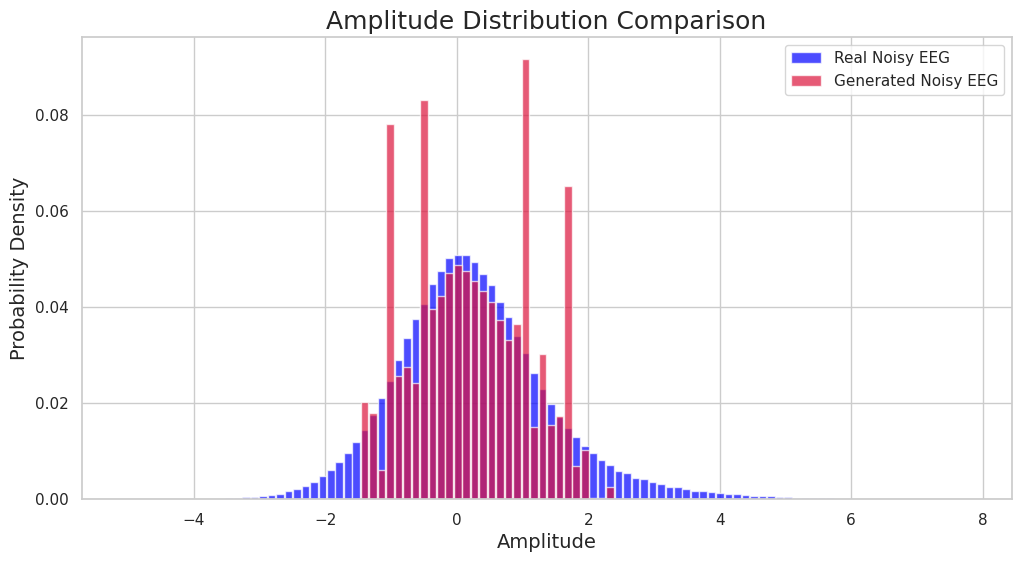


Calculating ACF Similarity...
Average ACF MSE: 0.0058
Average ACF Correlation Coefficient: 0.9772
Saved average ACF plot: /content/drive/My Drive/FYP/evaluation_visualizations/average_acf.png


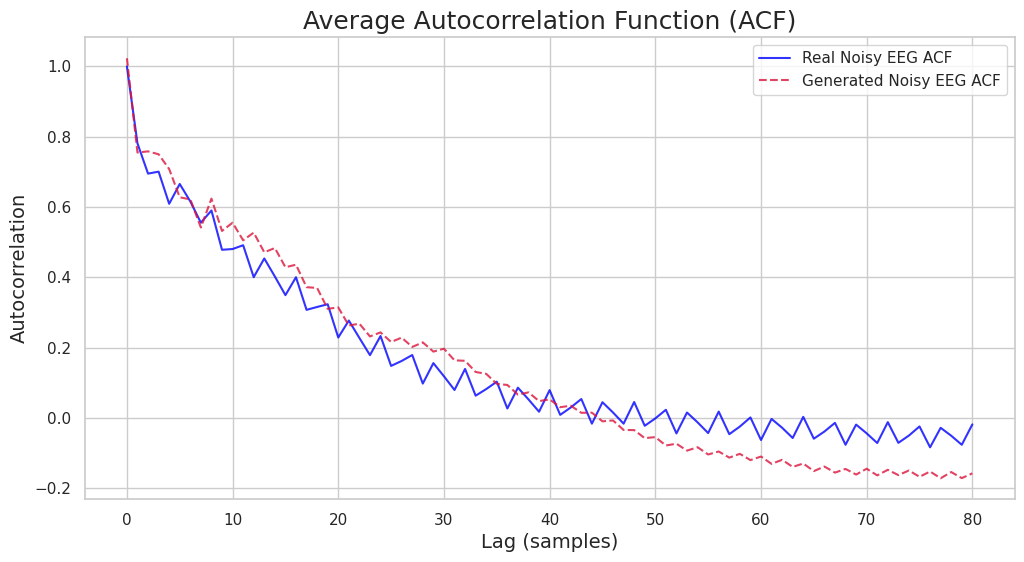


Calculating MMD on subset...
Maximum Mean Discrepancy (MMD) (Subset): 0.0095
Overall Average SSIM: 0.0174
Overall Average PSNR: 14.7897

--- Evaluation Metrics Calculation Complete ---

Evaluation Summary:
  Avg_Feature_Matching_Loss: 0.1776
  Avg_Log_PSD_MSE: 0.38708218932151794
  Amplitude_Wasserstein_Distance: nan
  Amplitude_JSD: 0.3283
  Avg_ACF_MSE: 0.0058
  Avg_ACF_Correlation: 0.9772
  MMD_Subset: 0.009460210800170898
  Avg_SSIM: 0.0174
  Avg_PSNR: 14.789748191833496

Evaluation metrics saved to /content/drive/My Drive/FYP/evaluation_metrics.json

--- Saving Evaluation Metrics to CSV ---
Appended evaluation metrics to '/content/drive/My Drive/FYP/evaluation_metrics_log.csv'

--- Visualizing Metrics Across Batches ---
Saved batch feature loss plot: /content/drive/My Drive/FYP/evaluation_visualizations/batch_feature_matching_loss.png


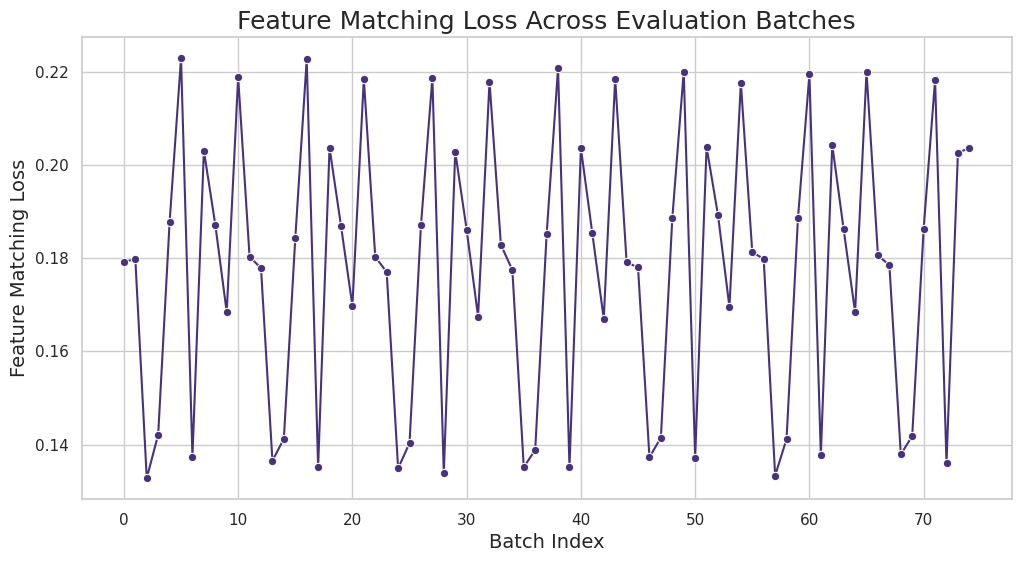

Saved batch log-PSD MSE plot: /content/drive/My Drive/FYP/evaluation_visualizations/batch_log_psd_mse.png


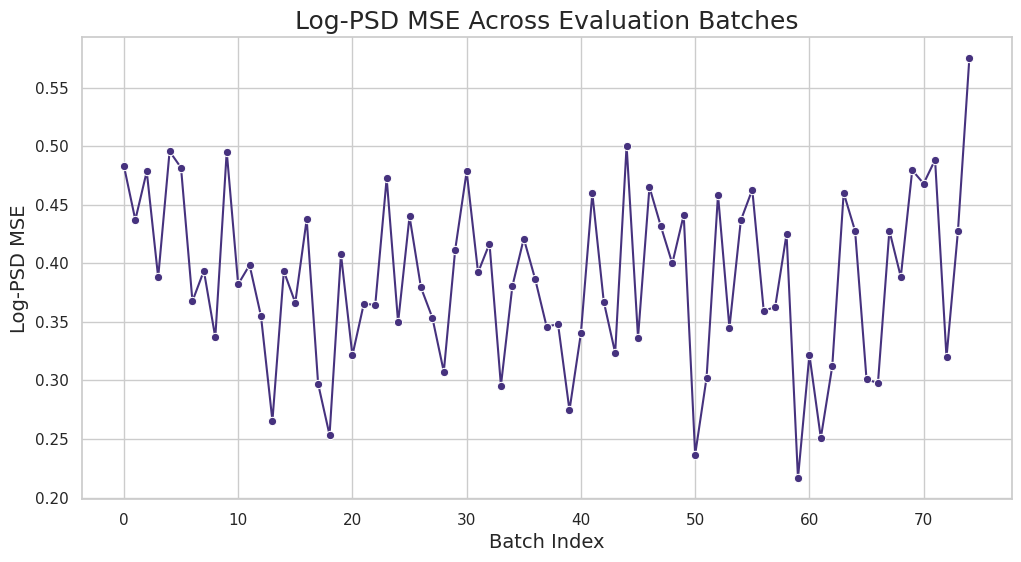

Saved batch SSIM plot: /content/drive/My Drive/FYP/evaluation_visualizations/batch_ssim.png


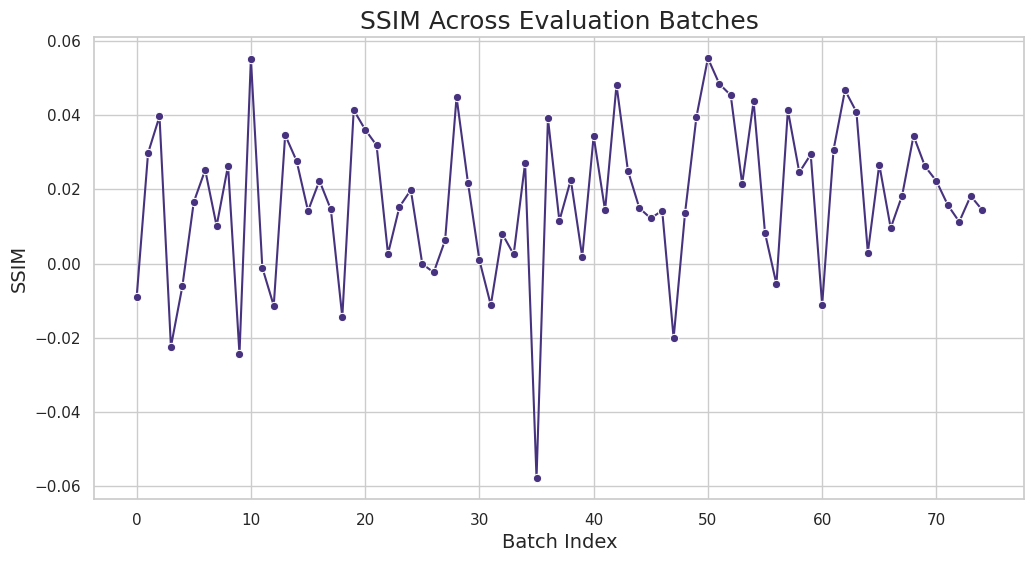

Saved batch PSNR plot: /content/drive/My Drive/FYP/evaluation_visualizations/batch_psnr.png


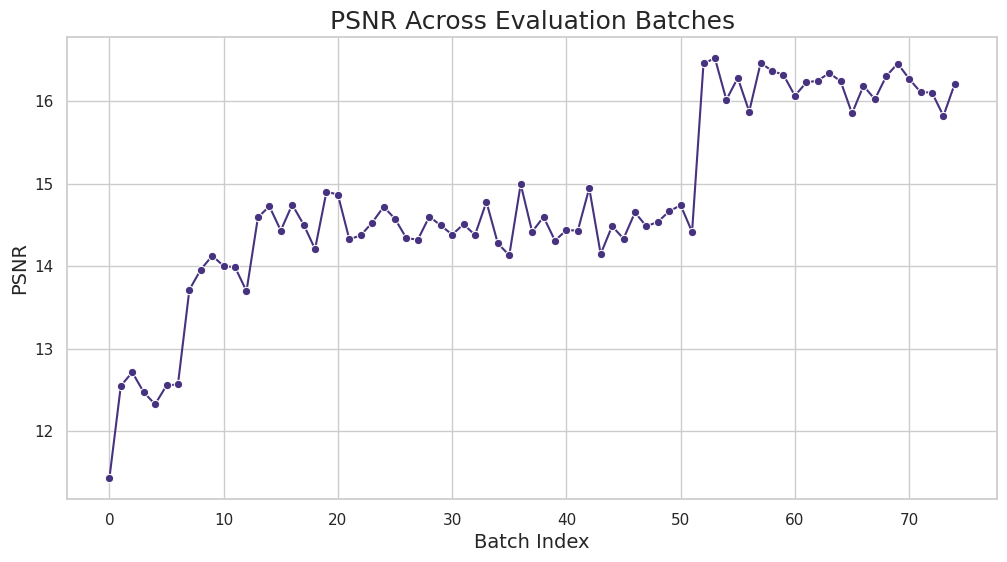


--- Visualizing MMD, SSIM, and PSNR Distributions (Box Plots) ---


/tmp/ipython-input-3890366515.py:1008: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_plot_df_melted, x='Metric', y='Score', palette='viridis')


Saved metrics box plot: /content/drive/My Drive/FYP/evaluation_visualizations/evaluation_metrics_boxplot.png


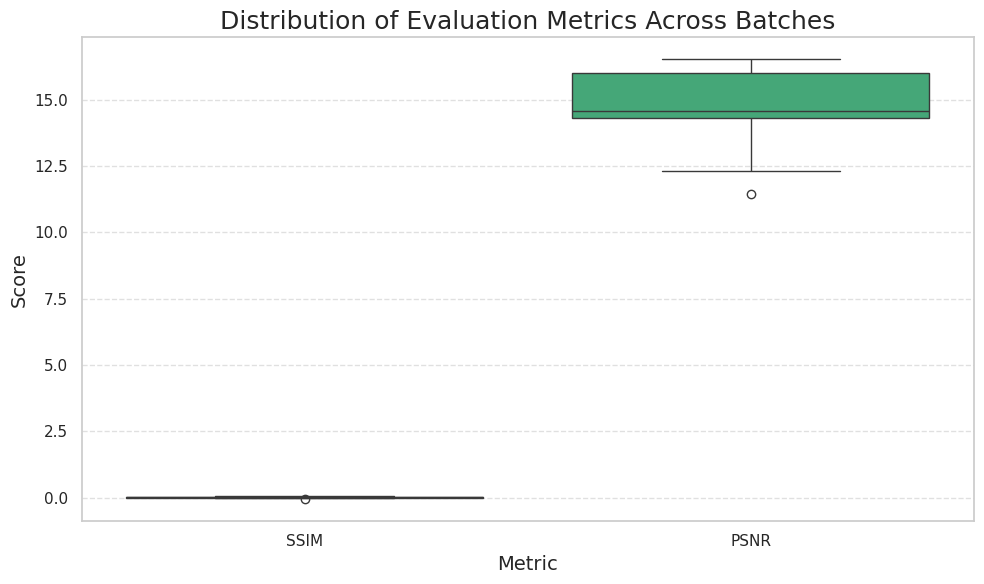


--- Visualizing Evaluation Samples ---
Saved visualization: /content/drive/My Drive/FYP/evaluation_visualizations/eval_sample_01.png


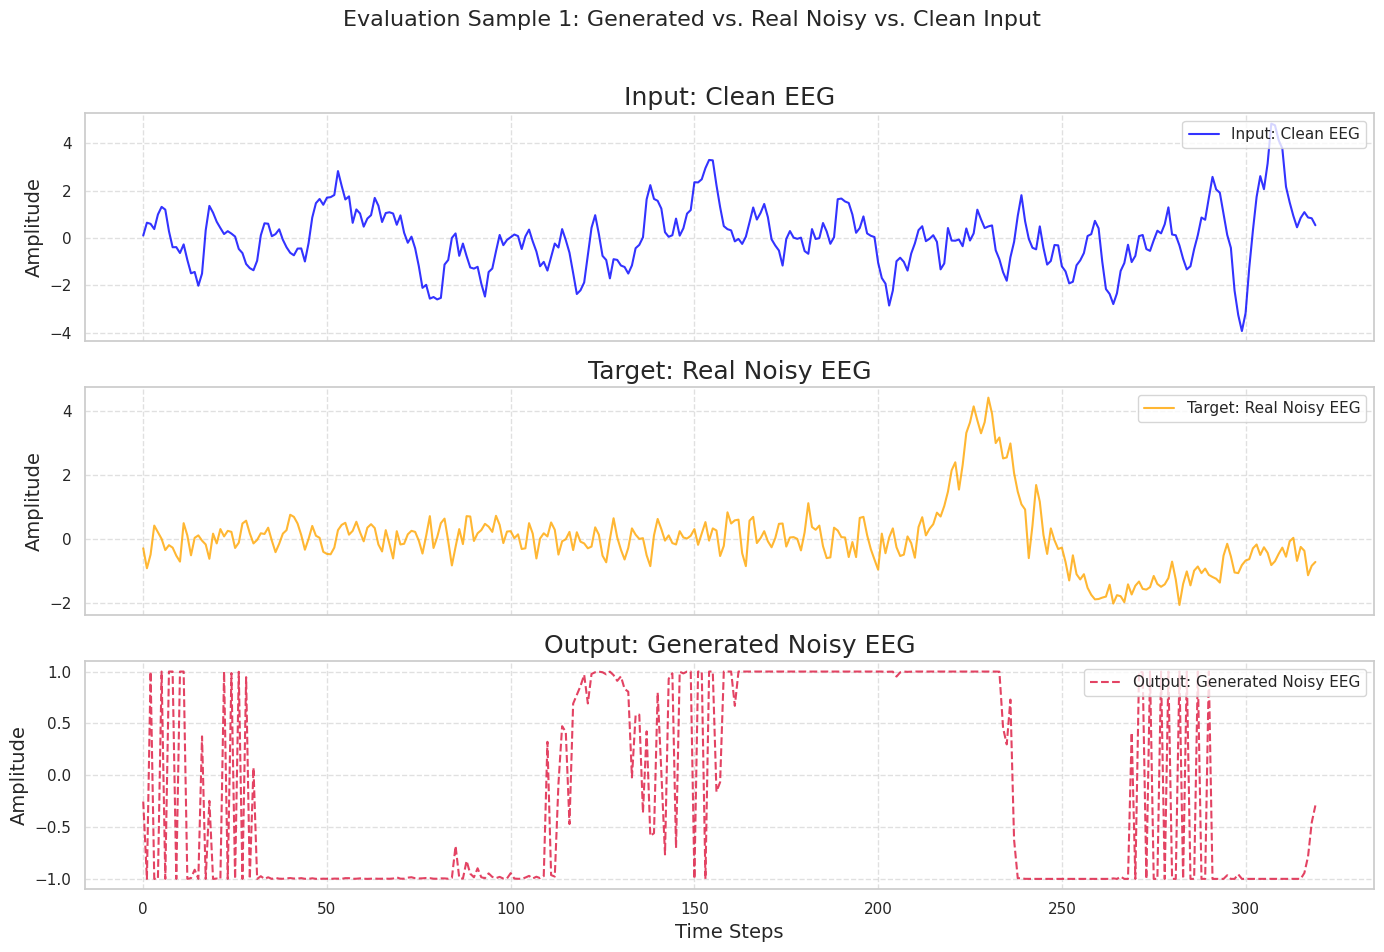

Saved visualization: /content/drive/My Drive/FYP/evaluation_visualizations/eval_sample_02.png


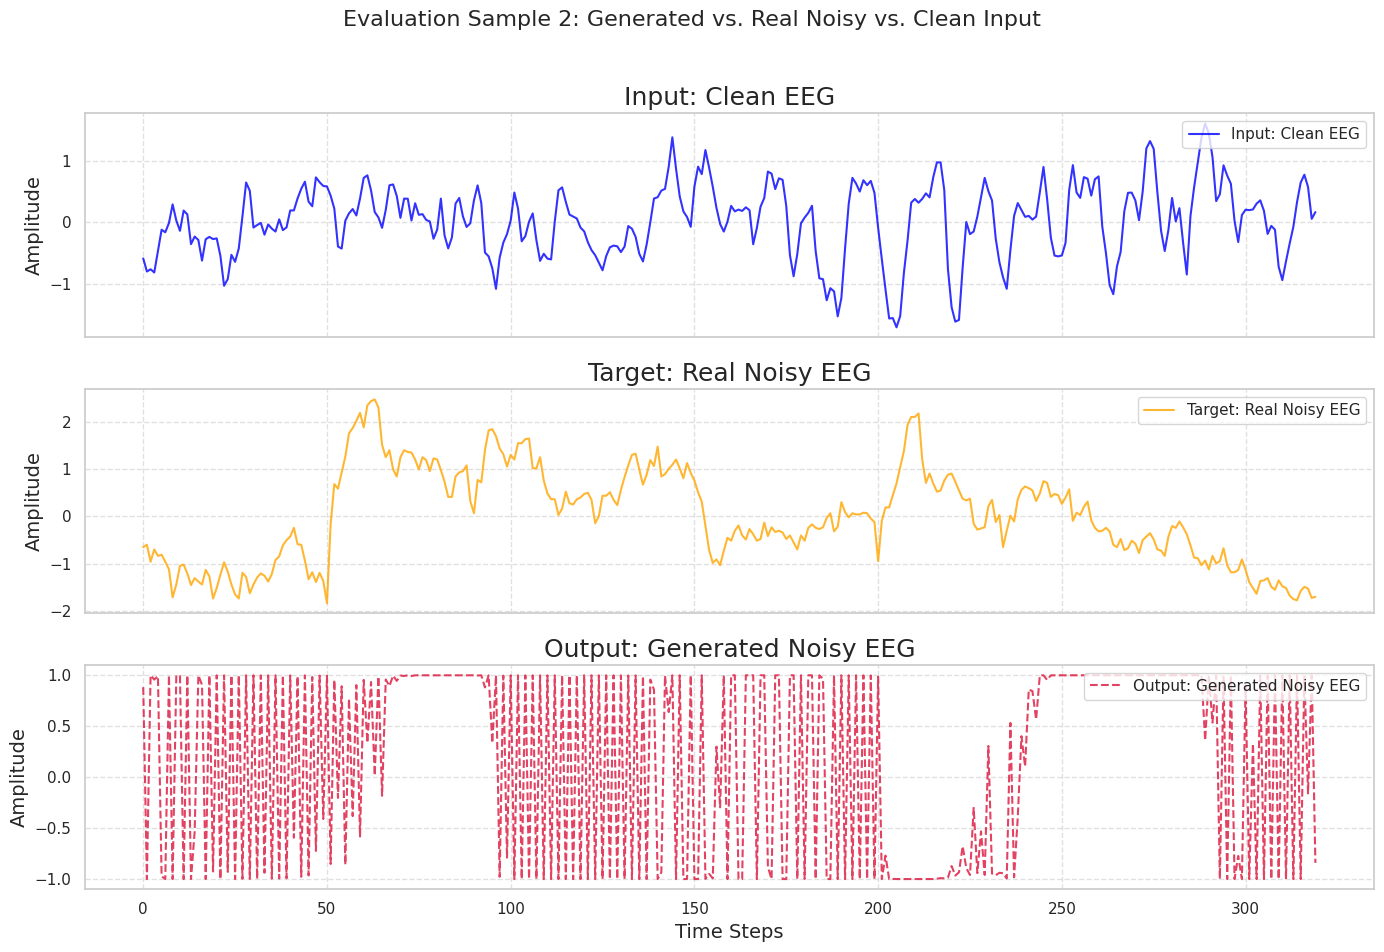

Saved visualization: /content/drive/My Drive/FYP/evaluation_visualizations/eval_sample_03.png


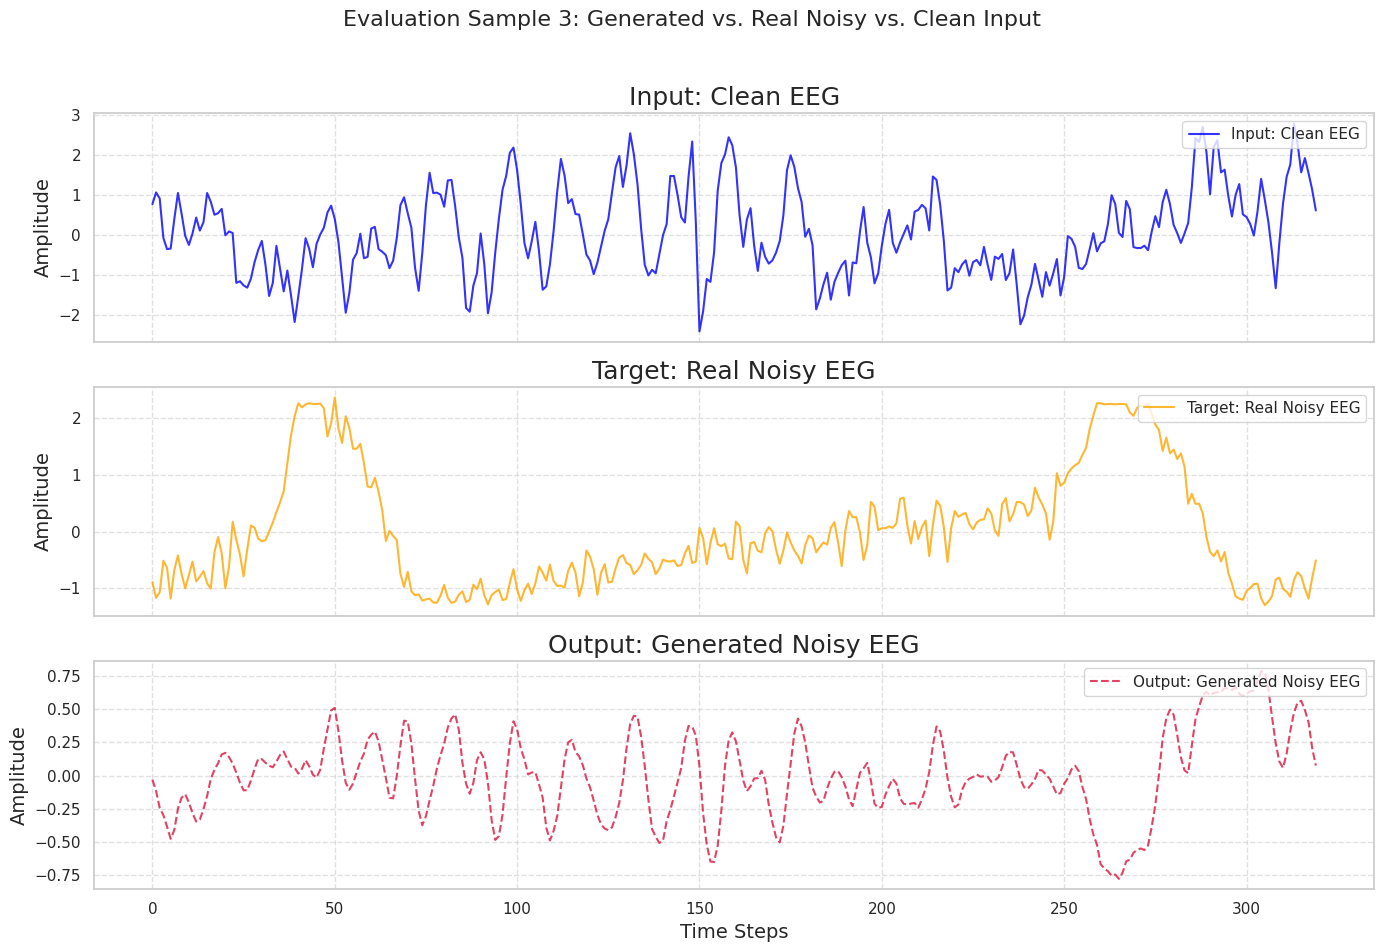

Saved visualization: /content/drive/My Drive/FYP/evaluation_visualizations/eval_sample_04.png


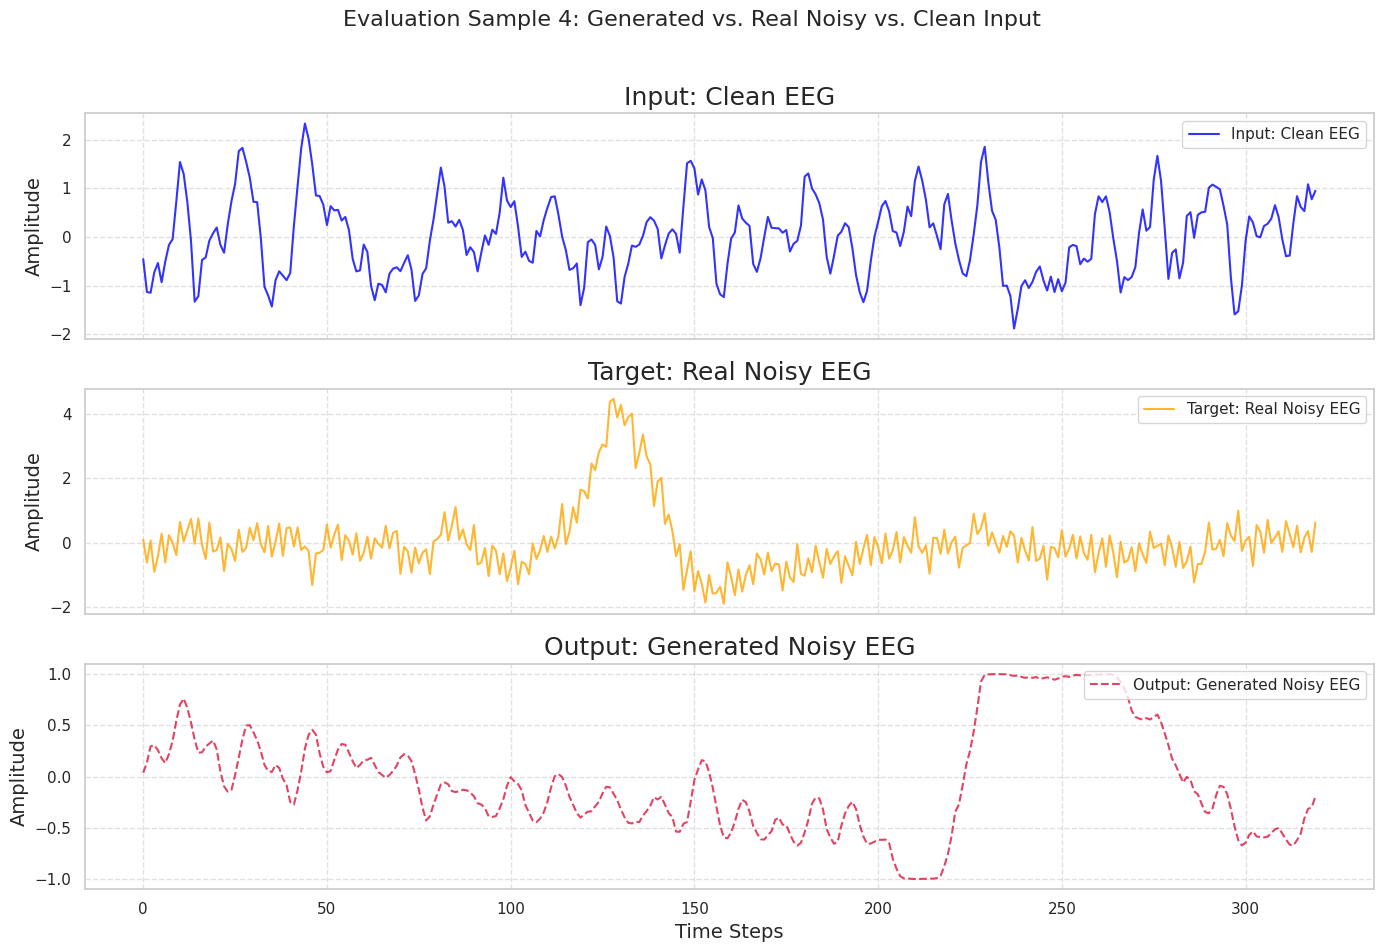

Saved visualization: /content/drive/My Drive/FYP/evaluation_visualizations/eval_sample_05.png


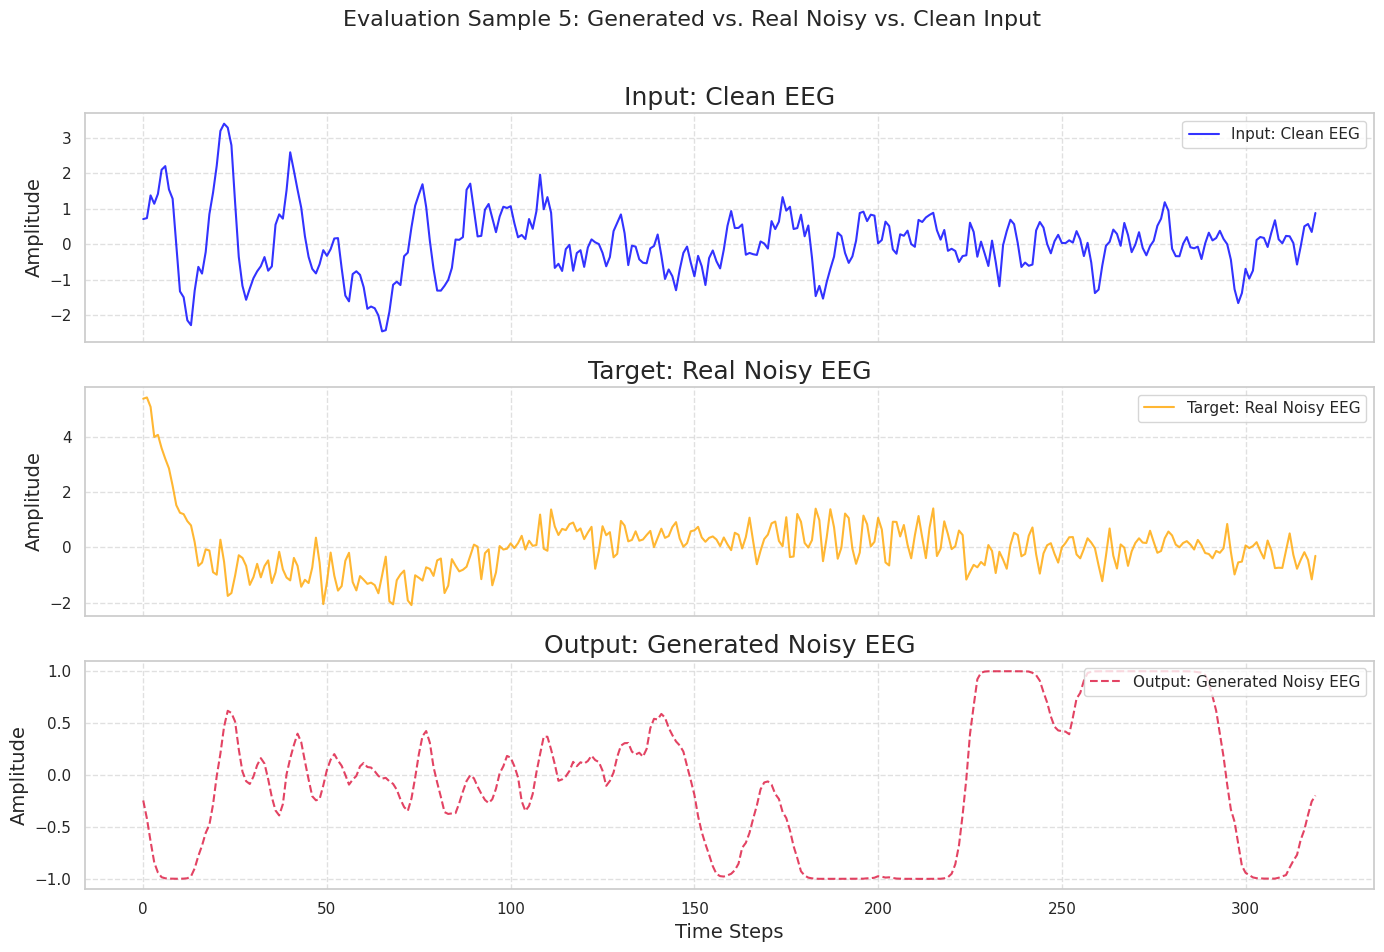


Evaluation visualization complete.


In [ ]:
# =============================================================================
# 1. EVALUATION CONFIGURATION (Re-copied for execution)
# =============================================================================

# --- Paths & Device ---
# Define the base directory in Google Drive (ensure this matches your setup)
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from tqdm.auto import tqdm
from scipy.signal import welch, correlate
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
import pandas as pd
# from sklearn.metrics import mean_squared_error # For MSE (PSD, ACF) - using np.mean((a-b)**2) instead

# --- Additional Imports for New Metrics ---
# For MMD
from sklearn.metrics.pairwise import rbf_kernel # Using RBF kernel for MMD

# For SSIM and PSNR
# Need to treat signals as 1D "images" or use appropriate signal comparison functions
# skimage's SSIM and PSNR are typically for 2D images, need to check 1D compatibility
# Alternatively, implement 1D versions or use signal-specific approaches.
# For simplicity, let's use NumPy/SciPy for calculations that mimic the concepts for 1D signals.
# SSIM requires a sliding window approach or a global calculation. A global approach might be simpler for now.
# PSNR requires a reference signal (real noisy) and a distorted signal (generated noisy).

# Note: Direct application of 2D image metrics (skimage.metrics) to 1D signals
# might not be directly appropriate or might require reshaping/padding.
# Let's implement simplified 1D versions or use signal-specific approaches.

# For SSIM: Simplified 1D version
# Formula involves means, variances, and covariance of the two signals.
def ssim_1d(x, y, max_val=None):
    """
    Simplified 1D SSIM calculation.
    Assumes x and y are 1D numpy arrays of the same length.
    max_val is the dynamic range of the data (e.g., max_amp - min_amp).
    Using constants C1 and C2 as per the original SSIM paper.
    """
    C1 = (0.01 * max_val)**2 if max_val is not None else 1e-6
    C2 = (0.03 * max_val)**2 if max_val is not None else 1e-5

    mu_x = np.mean(x)
    mu_y = np.mean(y)
    sigma_x2 = np.var(x)
    sigma_y2 = np.var(y)
    sigma_xy = np.cov(x, y)[0, 1] # Covariance

    numerator = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    denominator = (mu_x**2 + mu_y**2 + C1) * (sigma_x2 + sigma_y2 + C2)

    # Avoid division by zero or extremely small denominators
    if denominator == 0:
        return 1.0 # Perfect similarity if signals are identical and zero variance
    return numerator / denominator

# For PSNR: Simplified 1D version
# Formula is 10 * log10(MAX^2 / MSE)
def psnr_1d(real_signal, generated_signal, max_val=None):
    """
    Simplified 1D PSNR calculation.
    Assumes real_signal and generated_signal are 1D numpy arrays of the same length.
    max_val is the maximum possible pixel value (dynamic range).
    """
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((real_signal - generated_signal)**2)

    if mse == 0:
        return float('inf') # Perfect similarity
    # If max_val is not provided, use the max value of the real signal as an estimate
    # This might not be ideal if the real signal doesn't cover the full range
    # A better approach might be to use a known data range if available,
    # or the max absolute value across the entire dataset if normalized.
    # Let's use the max absolute value of the real signal as a simple approach
    if max_val is None:
        # Using the peak of the real signal as reference, common in image processing
        # For normalized data, maybe use 1.0 or 3.0 (e.g., +/- 3 std dev)
        # Let's use the max absolute value of the real signal as a simple approach
        max_val = np.max(np.abs(real_signal))
        if max_val == 0:
             return float('inf') # Should only happen if signal is all zeros


    # Ensure max_val is positive for log calculation
    if max_val <= 0:
         # print("Warning: max_val for PSNR is non-positive. Returning -inf.")
         return -float('inf')


    # PSNR formula: 10 * log10(MAX^2 / MSE)
    # For 1D signals, MAX is the maximum possible amplitude value.
    # Using MAX = max_val here.
    # Note: Some definitions use the maximum value of the *real* signal itself as MAX.
    # Let's use the max_val parameter as the reference maximum dynamic range.
    return 10 * np.log10((max_val**2) / mse)


GOOGLE_DRIVE_BASE_DIR = "/content/drive/My Drive/FYP/"

# Path to the BEST model checkpoint saved during training
# We will load 'best_model.pth' which stores the state from the epoch with the lowest validation loss
CHECKPOINT_PATH = os.path.join(GOOGLE_DRIVE_BASE_DIR, "checkpoints", "best_model.pth")

# Directory to save evaluation visualizations
OUTPUT_EVAL_VIZ_DIR = os.path.join(GOOGLE_DRIVE_BASE_DIR, "evaluation_visualizations")

# Define the path for the evaluation metrics CSV file
EVALUATION_LOG_FILE = os.path.join(GOOGLE_DRIVE_BASE_DIR, "evaluation_metrics_log.csv")


# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Evaluation Parameters ---
# These should match the parameters used during training and data loading
EVAL_BATCH_SIZE = 32 # Use the same batch size or adjust if needed for evaluation
LATENT_DIM = 100     # Must match the latent_dim used by the generator
INPUT_LENGTH = 320   # Must match the sequence length
FS = 160             # Must match the sampling frequency

# Max amplitude value for PSNR and SSIM calculations (if data is normalized to a known range)
# If data is normalized to mean 0, std 1, a range like [-3, 3] or based on the max absolute value of the dataset might be appropriate.
# Let's use a placeholder and calculate based on actual data range if needed.
# MAX_AMP_VALUE = 3.0 # Example if normalized to roughly +/- 3 std dev. Adjust based on your normalization.
# A safer approach is to calculate the max absolute value from the collected data during evaluation.
MAX_ABS_AMPLITUDE_REAL = 0.0 # To be updated during evaluation loop


# --- Create Output Directory ---
# Ensure the directory exists before saving plots
os.makedirs(OUTPUT_EVAL_VIZ_DIR, exist_ok=True)
print(f"Evaluation visualizations will be saved to the '{OUTPUT_EVAL_VIZ_DIR}/' directory.")
print(f"Evaluation metrics log will be saved to '{EVALUATION_LOG_FILE}'.")
print(f"Using device for evaluation: {DEVICE}")


# --- Dataloaders (Using actual names from your notebook) ---
# Ensure the 'test' splits of your dataloaders are available
try:
    # Access the test loaders assuming they were created and stored in dictionaries
    # 'p_dataloaders' should contain the PhysioNet (real noisy) loaders
    # 'dataloaders' should contain the EEGdenoiseNet (condition) loaders
    # These need to be defined in previous cells and accessible in the global scope
    real_noisy_loader_eval = p_dataloaders['test']
    cond_loader_eval = dataloaders["test"]

    print(f"Successfully assigned evaluation dataloaders.")
    print(f"Real Noisy Test Loader has {len(real_noisy_loader_eval)} batches.")
    print(f"Condition Test Loader has {len(cond_loader_eval)} batches.")

except NameError as e:
    print(f"--- FATAL ERROR: Dataloader not found: {e} ---")
    print("Please ensure 'p_dataloaders' and 'dataloaders' are defined and contain a 'test' split in previous cells.")
    # You should stop execution if dataloaders are missing
    raise

except KeyError as e:
     print(f"--- FATAL ERROR: Test split not found in dataloaders: {e} ---")
     print("Please ensure 'p_dataloaders' and 'dataloaders' dictionaries contain the key 'test'.")
     raise

# Check if dataloaders are empty
if len(real_noisy_loader_eval) == 0 or len(cond_loader_eval) == 0:
     print("--- WARNING: One or both evaluation dataloaders are empty! ---")
     print("Cannot proceed with evaluation. Please check your data splitting.")
     # It's better to raise an error or exit here in a script context
     # For a notebook, you might just print the warning and stop the cell


# =============================================================================
# 2. LOAD TRAINED MODEL
# =============================================================================

# --- Initialize Models ---
# Ensure the model architectures match the ones used during training.
# The UNet1DGenerator and RobustCritic classes should be defined in a previous cell.
try:
    # We only need the generator for generating samples during evaluation.
    # Ensure UNet1DGenerator class is defined
    if 'UNet1DGenerator' not in globals():
        raise NameError("UNet1DGenerator class not found. Please ensure it is defined in a previous cell.")

    generator = UNet1DGenerator(input_length=INPUT_LENGTH, num_channels=3, latent_dim=LATENT_DIM).to(DEVICE)
    # The critic is not strictly needed for generating samples, but you might
    # initialize it if you wanted to evaluate critic scores on the test set as well.
    # Ensure RobustCritic class is defined if you need it
    # if 'RobustCritic' not in globals():
    #      print("Warning: RobustCritic class not found. Cannot initialize critic.")
    # critic = RobustCritic(n_channels_in=1).to(DEVICE)
    print("Model architectures initialized.")

except NameError as e:
     print(f"--- FATAL ERROR: Model architecture not found: {e} ---")
     print("Please ensure the UNet1DGenerator and RobustCritic classes are defined in a previous cell.")
     raise


# --- Load State Dictionary ---
if os.path.exists(CHECKPOINT_PATH):
    print(f"\n=> Loading generator state from checkpoint: '{CHECKPOINT_PATH}'")
    try:
        # Load the checkpoint onto the specified device.
        # Use weights_only=False if you saved optimizers or other non-weight tensors
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)

        # Load the generator's state dictionary
        generator.load_state_dict(checkpoint['generator_state_dict'])

        print("=> Generator model loaded successfully.")

        # You can optionally load critic state if you initialized it
        # if 'critic_state_dict' in checkpoint and 'critic' in locals() and critic is not None:
        #      critic.load_state_dict(checkpoint['critic_state_dict'])
        #      print("=> Critic model loaded successfully.")

    except Exception as e:
        print(f"--- ERROR loading checkpoint or model state: {e} ---")
        print(f"Please verify the checkpoint path: {CHECKPOINT_PATH}")
        print("Ensure the model architecture matches the saved state dictionary.")
        raise # Re-raise the exception to stop execution

else:
    print(f"\n--- FATAL ERROR ---")
    print(f"Checkpoint file not found at '{CHECKPOINT_PATH}'.")
    print("Please ensure the path is correct and the training script saved the 'best_model.pth' checkpoint.")
    raise FileNotFoundError(f"Checkpoint file not found at {CHECKPOINT_PATH}")


# Set generator to evaluation mode
# This is important for layers like BatchNorm and Dropout
generator.eval()
print("Generator set to evaluation mode (eval()).")


# =============================================================================
# 3. DEFINE EVALUATION METRICS AND RUN EVALUATION LOOP (INTEGRATED)
# =============================================================================

# Re-define FeatureMatchingLoss class to ensure it's available in this cell's scope
# Assuming feature_out and feature_cond functions are defined in a previous cell
class FeatureMatchingLoss(nn.Module):
    def __init__(self, fs=160):
        super().__init__()
        self.fs = fs
        # Using L1Loss as defined in the training script
        self.loss_fn = nn.L1Loss()

    def forward(self, generated_batch, condition_batch):
        # Ensure feature extraction functions (feature_out, feature_cond) are available
        # and handle tensors on the correct device.
        # These functions should have been defined in a previous cell.
        # Check if feature_out and feature_cond are defined
        if 'feature_out' not in globals() or 'feature_cond' not in globals():
             raise NameError("feature_out or feature_cond functions not found. Please ensure they are defined in a previous cell.")

        gen_features = feature_out(generated_batch, self.fs)
        target_features = feature_cond(condition_batch, self.fs)
        return self.loss_fn(gen_features, target_features)

# Initialize the evaluation metric(s)
evaluation_feature_loss = FeatureMatchingLoss(fs=FS).to(DEVICE)

# Lists to store metrics per batch
batch_feature_losses = [] # For plotting individual batch losses

# --- Initialize lists/arrays for new metrics ---
batch_psd_mses = [] # For plotting individual batch MSEs of log PSDs
batch_ssim_scores = [] # For storing batch-wise SSIM scores
batch_psnr_scores = [] # For storing batch-wise PSNR scores

# For Amplitude Distribution Similarity: Collect histograms per batch
num_amplitude_bins = 100 # Number of bins for amplitude histograms
# Need to determine the global amplitude range or estimate it from data.
# For simplicity, let's estimate min/max amplitude from the first few batches or use a fixed range if data is normalized.
# Let's collect min/max amplitude across all batches to define bins later.
global_min_amp = float('inf')
global_max_amp = float('-inf')
sum_real_hist = np.zeros(num_amplitude_bins)
sum_fake_hist = np.zeros(num_amplitude_bins)
total_hist_samples = 0


# For ACF Similarity: Accumulate ACFs for averaging
max_lag = int(0.5 * FS) # e.g., 0.5 seconds of lag
sum_real_acfs = np.zeros(max_lag + 1)
sum_fake_acfs = np.zeros(max_lag + 1)
total_samples_acf = 0 # Counter for samples processed for ACF

# For MMD: Calculate MMD on a subset of batches
# REDUCED NUMBER OF BATCHES FOR MMD TO SAVE MEMORY
num_mmd_batches = 3
mmd_real_samples_subset = []
mmd_fake_samples_subset = []
mmd_batches_sampled = 0
import random # Import random for sampling batches
random.seed(42) # Set a seed for reproducibility


# Store batch indices for plotting
batch_indices = []


print("\n--- Starting Evaluation Loop ---")

# Ensure the smaller dataloader is iterated fully, cycling the larger one if necessary
# This uses itertools.cycle to handle dataloaders of different lengths gracefully.
if len(real_noisy_loader_eval) > len(cond_loader_eval):
    main_loader_eval = real_noisy_loader_eval
    secondary_loader_eval_iter = itertools.cycle(iter(cond_loader_eval))
    is_main_real = True # Flag to indicate which loader is the 'real noisy' one
else:
    main_loader_eval = cond_loader_eval
    secondary_loader_eval_iter = itertools.cycle(iter(real_noisy_loader_eval))
    is_main_real = False # Flag to indicate which loader is the 'condition' one


# Set the generator to evaluation mode (assuming 'generator' is defined in a previous cell)
if 'generator' not in globals() or not isinstance(generator, torch.nn.Module):
     raise NameError("Generator model not found. Please ensure it is initialized and loaded in a previous cell.")

generator.eval()

# Use torch.no_grad() to disable gradient calculation during evaluation
with torch.no_grad():
    prog_bar_eval = tqdm(main_loader_eval, desc="Evaluating Test Set")

    # Create iterators for sampling MMD batches
    real_noisy_mmd_iter = iter(real_noisy_loader_eval)
    cond_mmd_iter = iter(cond_loader_eval)


    for i, main_batch_eval in enumerate(prog_bar_eval):
        # Fetch the corresponding batch from the other dataloader
        secondary_batch_eval = next(secondary_loader_eval_iter)

        # Assign batches correctly based on which loader is iterated as main
        if is_main_real:
            real_noisy_eval_batch = main_batch_eval
            conditions_eval_batch = secondary_batch_eval
        else:
            real_noisy_eval_batch = secondary_batch_eval
            conditions_eval_batch = main_batch_eval

        # --- Correctly handle batch content (tensor vs. list/tuple from DataLoader) ---
        # Dataloaders might return a tuple/list if they yield multiple items per index.
        # Assuming the first element is the data tensor.
        real_noisy_eval = real_noisy_eval_batch[0] if isinstance(real_noisy_eval_batch, (list, tuple)) else real_noisy_eval_batch
        conditions_eval = conditions_eval_batch[0] if isinstance(conditions_eval_batch, (list, tuple)) else conditions_eval_batch


        # --- Align batch sizes and move to device ---
        # This handles cases where the last batch might be smaller
        current_batch_size_eval = min(real_noisy_eval.size(0), conditions_eval.size(0))
        real_noisy_eval = real_noisy_eval[:current_batch_size_eval].to(DEVICE)
        conditions_eval = conditions_eval[:current_batch_size_eval].to(DEVICE)


        # --- Final safeguard for real_noisy shape ---
        # Ensure real_noisy has a channel dimension [batch, 1, seq_len] if needed
        if real_noisy_eval.dim() == 2:
            real_noisy_eval = real_noisy_eval.unsqueeze(1)

        # Check condition input shape (should be [batch, 3, seq_len])
        if conditions_eval.dim() != 3 or conditions_eval.shape[1] != 3:
             print(f"Warning: Unexpected condition batch shape: {conditions_eval.shape}. Skipping batch {i}.")
             # Append NaN for skipped batches to keep lists aligned with batch index
             batch_feature_losses.append(np.nan)
             batch_psd_mses.append(np.nan)
             batch_ssim_scores.append(np.nan)
             batch_psnr_scores.append(np.nan)
             batch_indices.append(i)
             continue # Skip this batch if shape is wrong


        # Generate fake noisy data using the loaded generator
        # Generator takes condition input and noise input
        noise_eval = torch.randn(current_batch_size_eval, LATENT_DIM, device=DEVICE)
        fake_noisy_eval = generator(conditions_eval, noise_eval)


        # Calculate evaluation metrics for the current batch
        # Ensure the generated output is 1 channel for the feature_loss calculation
        if fake_noisy_eval.dim() == 3 and fake_noisy_eval.shape[1] == 1:
            # --- Feature Matching Loss ---
            loss_feat_eval = evaluation_feature_loss(fake_noisy_eval, conditions_eval)
            batch_feature_losses.append(loss_feat_eval.item()) # Append to batch list for plotting

            # --- New Metrics Calculation ---

            # Convert batches to NumPy arrays on CPU and remove channel dim
            real_noisy_np = real_noisy_eval.cpu().numpy().squeeze(1) # Shape: [batch_size, seq_len]
            fake_noisy_np = fake_noisy_eval.cpu().numpy().squeeze(1) # Shape: [batch_size, seq_len]

            # Check if squeeze resulted in 1D array if batch size is 1
            if real_noisy_np.ndim == 1:
                 real_noisy_np = real_noisy_np[np.newaxis, :] # Add batch dimension back
                 fake_noisy_np = fake_noisy_np[np.newaxis, :] # Add batch dimension back

            # Update max absolute amplitude for PSNR/SSIM reference
            MAX_ABS_AMPLITUDE_REAL = max(MAX_ABS_AMPLITUDE_REAL, np.max(np.abs(real_noisy_np)))


            # 1. PSD Similarity (MSE of log-transformed PSDs) - Batch-wise
            batch_real_psds = []
            batch_fake_psds = []
            nperseg = 2 * FS # e.g., 2 seconds segment length for Welch
            if nperseg > real_noisy_np.shape[1]:
                 nperseg = real_noisy_np.shape[1] # Use signal length as nperseg if shorter

            current_batch_psd_mse = np.nan # Initialize to NaN for this batch

            if nperseg > 0 and real_noisy_np.shape[1] >= nperseg:
                 for j in range(current_batch_size_eval):
                     if real_noisy_np.shape[1] < nperseg: continue

                     freqs_real, psd_real = welch(real_noisy_np[j], fs=FS, nperseg=nperseg)
                     freqs_fake, psd_fake = welch(fake_noisy_np[j], fs=FS, nperseg=nperseg)
                     batch_real_psds.append(psd_real)
                     batch_fake_psds.append(psd_fake)

                 if batch_real_psds:
                     avg_psd_real = np.mean(np.stack(batch_real_psds), axis=0)
                     avg_psd_fake = np.mean(np.stack(batch_fake_psds), axis=0)

                     log_psd_real = np.log10(avg_psd_real + 1e-9)
                     log_psd_fake = np.log10(avg_psd_fake + 1e-9)

                     current_batch_psd_mse = np.mean((log_psd_real - log_psd_fake)**2)

            batch_psd_mses.append(current_batch_psd_mse)


            # 2. Amplitude Distribution Similarity (Collecting histograms per batch)
            # Update global min/max amplitude
            global_min_amp = min(global_min_amp, np.min(real_noisy_np), np.min(fake_noisy_np))
            global_max_amp = max(global_max_amp, np.max(real_noisy_np), np.max(fake_noisy_np))

            # Compute histogram for the current batch
            if global_max_amp > global_min_amp: # Only compute if range is valid
                 hist_real_batch, _ = np.histogram(real_noisy_np.flatten(), bins=num_amplitude_bins, range=(global_min_amp, global_max_amp), density=True)
                 hist_fake_batch, _ = np.histogram(fake_noisy_np.flatten(), bins=num_amplitude_bins, range=(global_min_amp, global_max_amp), density=True)

                 # Accumulate histograms (sum up counts) - need to handle density=True carefully, better to sum counts and normalize later
                 # Let's switch to summing counts and normalizing at the end
                 hist_real_batch_counts, _ = np.histogram(real_noisy_np.flatten(), bins=num_amplitude_bins, range=(global_min_amp, global_max_amp), density=False)
                 hist_fake_batch_counts, _ = np.histogram(fake_noisy_np.flatten(), bins=num_amplitude_bins, range=(global_min_amp, global_max_amp), density=False)

                 sum_real_hist += hist_real_batch_counts
                 sum_fake_hist += hist_fake_batch_counts
                 total_hist_samples += real_noisy_np.size # Add total elements in the batch


            # 3. Autocorrelation Function (ACF) Similarity (Accumulating ACFs)
            if real_noisy_np.shape[1] >= max_lag + 1:
                batch_sum_real_acfs = np.zeros(max_lag + 1)
                batch_sum_fake_acfs = np.zeros(max_lag + 1)
                batch_sample_count = 0

                for j in range(current_batch_size_eval):
                    acf_real_full = correlate(real_noisy_np[j], real_noisy_np[j], mode='full')
                    acf_real = acf_real_full[len(real_noisy_np[j])-1 : len(real_noisy_np[j])+max_lag]
                    var_real = np.var(real_noisy_np[j])
                    if var_real > 1e-9: acf_real = acf_real / (var_real * len(real_noisy_np[j]))
                    else: acf_real = np.zeros_like(acf_real)

                    acf_fake_full = correlate(fake_noisy_np[j], fake_noisy_np[j], mode='full')
                    acf_fake = acf_fake_full[len(fake_noisy_np[j])-1 : len(fake_noisy_np[j])+max_lag]
                    var_fake = np.var(fake_noisy_np[j])
                    if var_fake > 1e-9: acf_fake = acf_fake / (var_fake * len(fake_noisy_np[j]))
                    else: acf_fake = np.zeros_like(acf_fake)

                    batch_sum_real_acfs += acf_real
                    batch_sum_fake_acfs += acf_fake
                    batch_sample_count += 1

                sum_real_acfs += batch_sum_real_acfs
                sum_fake_acfs += batch_sum_fake_acfs
                total_samples_acf += batch_sample_count

            # 4. MMD (Calculating on a subset of batches)
            # Randomly sample batches to add to the MMD subset
            # Only sample if we haven't reached the desired number of MMD batches yet
            if mmd_batches_sampled < num_mmd_batches:
                 # Calculate the probability of sampling this batch
                 # prob_sample = num_mmd_batches / len(main_loader_eval) # This is not the correct way to sample batches
                 # A simpler approach is to just take the first N batches that are successfully processed
                 mmd_real_samples_subset.extend(real_noisy_np.flatten())
                 mmd_fake_samples_subset.extend(fake_noisy_np.flatten())
                 mmd_batches_sampled += 1
                 # print(f"Sampled batch {i} for MMD subset. Total MMD batches sampled: {mmd_batches_sampled}") # Optional log


            # 5. SSIM (Batch-wise Average)
            batch_ssim_sum = 0.0
            valid_ssim_count = 0
            for j in range(current_batch_size_eval):
                 # Pass MAX_ABS_AMPLITUDE_REAL as max_val if it's calculated globally,
                 # or calculate max_val per sample/batch if preferred.
                 # Using the global max absolute value from real data as reference.
                 # Make sure MAX_ABS_AMPLITUDE_REAL is updated across all batches.
                 if MAX_ABS_AMPLITUDE_REAL > 1e-9: # Only calculate if there's non-zero range
                    try:
                         current_ssim = ssim_1d(real_noisy_np[j], fake_noisy_np[j], max_val=MAX_ABS_AMPLITUDE_REAL)
                         batch_ssim_sum += current_ssim
                         valid_ssim_count += 1
                    except Exception as e:
                         # print(f"Warning: Error calculating SSIM for sample {j} in batch {i}: {e}") # Comment out verbose warning
                         pass # Skip if SSIM calculation fails for a sample

            current_batch_ssim = batch_ssim_sum / valid_ssim_count if valid_ssim_count > 0 else np.nan
            batch_ssim_scores.append(current_batch_ssim)


            # 6. PSNR (Batch-wise Average)
            batch_psnr_sum = 0.0
            valid_psnr_count = 0
            for j in range(current_batch_size_eval):
                 # Pass MAX_ABS_AMPLITUDE_REAL as max_val
                 if MAX_ABS_AMPLITUDE_REAL > 1e-9: # Only calculate if there's non-zero range
                    try:
                         current_psnr = psnr_1d(real_noisy_np[j], fake_noisy_np[j], max_val=MAX_ABS_AMPLITUDE_REAL)
                         batch_psnr_sum += current_psnr
                         valid_psnr_count += 1
                    except Exception as e:
                         # print(f"Warning: Error calculating PSNR for sample {j} in batch {i}: {e}") # Comment out verbose warning
                         pass # Skip if PSNR calculation fails for a sample

            current_batch_psnr = batch_psnr_sum / valid_psnr_count if valid_psnr_count > 0 else np.nan
            batch_psnr_scores.append(current_batch_psnr)


        else:
            print(f"Warning: Generated batch shape is unexpected: {fake_noisy_eval.shape}. Skipping all metric calculations for this batch {i}.")
            # Append NaN for skipped batches to keep lists aligned with batch index
            batch_feature_losses.append(np.nan)
            batch_psd_mses.append(np.nan)
            batch_ssim_scores.append(np.nan)
            batch_psnr_scores.append(np.nan)
            # Amplitude, ACF, MMD accumulation will automatically skip if batch is skipped

        # Append batch index regardless of whether metrics were calculated
        batch_indices.append(i)

        # Optional: Clear CUDA cache after each batch
        # torch.cuda.empty_cache()


        # Update the progress bar with current batch metrics (optional)
        # Display the last calculated batch metrics if available
        postfix_dict = {}
        if batch_feature_losses and not np.isnan(batch_feature_losses[-1]):
            postfix_dict['Batch Feat Loss'] = f'{batch_feature_losses[-1]:.4f}'
        if batch_psd_mses and not np.isnan(batch_psd_mses[-1]):
             postfix_dict['Batch PSD MSE'] = f'{batch_psd_mses[-1]:.4f}'
        if batch_ssim_scores and not np.isnan(batch_ssim_scores[-1]):
             postfix_dict['Batch SSIM'] = f'{batch_ssim_scores[-1]:.4f}'
        if batch_psnr_scores and not np.isnan(batch_psnr_scores[-1]):
             postfix_dict['Batch PSNR'] = f'{batch_psnr_scores[-1]:.2f}' # PSNR often reported with fewer decimal places
        prog_bar_eval.set_postfix(postfix_dict)


    # Final clear of CUDA cache after the loop
    # torch.cuda.empty_cache()


print("\n--- Evaluation Loop Finished ---")

# =============================================================================
# 4. CALCULATE AND REPORT FINAL METRICS (INTEGRATED)
# =============================================================================

print("\n--- Calculating and Reporting Final Evaluation Metrics ---")

# --- 1. Feature Matching Loss (Overall Average) ---
# Filter out NaNs if any batches were skipped
valid_feature_losses = [loss for loss in batch_feature_losses if not np.isnan(loss)]
if valid_feature_losses:
    avg_feature_loss = np.mean(valid_feature_losses)
    print(f"Overall Average Feature Matching Loss: {avg_feature_loss:.4f}")
else:
    avg_feature_loss = np.nan
    print("No valid Feature Matching Loss calculated.")


# --- 2. PSD Similarity (Overall Average MSE of log PSDs) ---
# Filter out NaNs if any batches were skipped for PSD
valid_psd_mses = [mse for mse in batch_psd_mses if not np.isnan(mse)]
if valid_psd_mses:
    avg_psd_mse = np.mean(valid_psd_mses)
    print(f"Overall Average Log-PSD MSE: {avg_psd_mse:.4f}")
else:
    avg_psd_mse = np.nan
    print("No valid PSD MSE calculated.")


# --- 3. Amplitude Distribution Similarity (JSD and Wasserstein) ---
if total_hist_samples > 0 and global_max_amp > global_min_amp:
    print("\nCalculating Amplitude Distribution Similarity...")
    # Normalize accumulated histograms to get probability distributions
    hist_real_prob = sum_real_hist / total_hist_samples
    hist_fake_prob = sum_fake_hist / total_hist_samples

    # Calculate Wasserstein Distance (Earth Mover's Distance) on the full collected amplitudes (if memory allows)
    # OR calculate on the normalized histograms if preferred/necessary
    # Let's calculate on the normalized histograms for memory efficiency
    # Note: Wasserstein distance on histograms requires defining bin centers/edges.
    # A simpler approach is to use the wasserstein_distance function directly on the raw samples if possible,
    # but we removed that for memory. Calculating on histograms is an approximation.

    # To calculate Wasserstein on histograms, we need the bin edges or centers
    bin_edges = np.linspace(global_min_amp, global_max_amp, num_amplitude_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    # Create discrete probability distributions from the normalized histograms and bin centers
    # This requires pairing bin centers with probabilities.
    # However, the scipy wasserstein_distance function works directly on 1D arrays of sample values.
    # Since we are not collecting all samples, let's stick to JSD which is well-defined for probability arrays.

    # Calculate Jensen-Shannon Divergence (JSD)
    try:
        # Ensure histograms sum to 1 (should be true after normalizing by total_hist_samples)
        hist_real_prob = hist_real_prob / (hist_real_prob.sum() + 1e-9)
        hist_fake_prob = hist_fake_prob / (hist_fake_prob.sum() + 1e-9)

        jsd_amp = jensenshannon(hist_real_prob, hist_fake_prob, base=2.0) # base=2.0 for result in bits

        print(f"Amplitude Distribution Jensen-Shannon Divergence (JSD): {jsd_amp:.4f}")

        # Note: Wasserstein distance calculation on the full dataset is removed for memory.
        wasserstein_amp = np.nan # Set to NaN as it's not calculated globally

    except Exception as e:
         jsd_amp = np.nan
         wasserstein_amp = np.nan
         print(f"Error calculating JSD for amplitude distribution: {e}")

    # Optional: Visualize the accumulated and normalized amplitude distributions
    plt.figure(figsize=(12, 6))
    bin_edges = np.linspace(global_min_amp, global_max_amp, num_amplitude_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    plt.bar(bin_centers, hist_real_prob, width=(bin_edges[1]-bin_edges[0])*0.9, alpha=0.7, label='Real Noisy EEG', color='blue')
    plt.bar(bin_centers, hist_fake_prob, width=(bin_edges[1]-bin_edges[0])*0.9, alpha=0.7, label='Generated Noisy EEG', color='crimson')
    plt.xlabel('Amplitude')
    plt.ylabel('Probability Density')
    plt.title('Amplitude Distribution Comparison')
    plt.legend()
    plt.grid(True, axis='y')
    amp_dist_plot_filename = os.path.join(OUTPUT_EVAL_VIZ_DIR, "amplitude_distribution.png")
    try:
        plt.savefig(amp_dist_plot_filename)
        print(f"Saved amplitude distribution plot: {amp_dist_plot_filename}")
    except Exception as e:
        print(f"Error saving amplitude distribution plot {amp_dist_plot_filename}: {e}")
    plt.show()
    plt.close()


else:
    wasserstein_amp = np.nan
    jsd_amp = np.nan
    print("No valid amplitude data collected for histogram calculation.")


# --- 4. ACF Similarity (MSE or Correlation of Average ACFs) ---
if total_samples_acf > 0:
    print("\nCalculating ACF Similarity...")
    # Calculate the average ACF curves
    avg_acf_real = sum_real_acfs / total_samples_acf
    avg_acf_fake = sum_fake_acfs / total_samples_acf

    # Calculate MSE between average ACFs
    mse_acf = np.mean((avg_acf_real - avg_acf_fake)**2)
    print(f"Average ACF MSE: {mse_acf:.4f}")

    # Calculate Correlation Coefficient between average ACFs
    # Need to handle cases where ACF is constant (std dev is 0)
    if np.std(avg_acf_real) > 1e-9 and np.std(avg_acf_fake) > 1e-9:
        corr_acf = np.corrcoef(avg_acf_real, avg_acf_fake)[0, 1]
        print(f"Average ACF Correlation Coefficient: {corr_acf:.4f}")
    else:
        corr_acf = np.nan
        print("Warning: Standard deviation of average ACF is zero, cannot calculate correlation coefficient.")

    # Optional: Plot average ACFs
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(max_lag + 1), avg_acf_real, label='Real Noisy EEG ACF', color='blue', alpha=0.8)
    plt.plot(np.arange(max_lag + 1), avg_acf_fake, label='Generated Noisy EEG ACF', color='crimson', linestyle='--', alpha=0.8)
    plt.xlabel('Lag (samples)')
    plt.ylabel('Autocorrelation')
    plt.title('Average Autocorrelation Function (ACF)')
    plt.legend()
    plt.grid(True)
    acf_plot_filename = os.path.join(OUTPUT_EVAL_VIZ_DIR, "average_acf.png")
    try:
        plt.savefig(acf_plot_filename)
        print(f"Saved average ACF plot: {acf_plot_filename}")
    except Exception as e:
        print(f"Error saving average ACF plot {acf_plot_filename}: {e}")

    plt.show()
    plt.close()

else:
    mse_acf = np.nan
    corr_acf = np.nan
    print("No ACF data collected.")

# --- 5. MMD (Maximum Mean Discrepancy) - Calculated on Subset ---
if mmd_real_samples_subset and mmd_fake_samples_subset:
    print("\nCalculating MMD on subset...")
    mmd_real_samples_subset_arr = np.array(mmd_real_samples_subset).reshape(-1, 1) # Reshape to (num_samples, 1) for kernel function
    mmd_fake_samples_subset_arr = np.array(mmd_fake_samples_subset).reshape(-1, 1) # Reshape to (num_samples, 1) for kernel function

    # Calculate the RBF kernel matrix for the subset
    # Choosing a gamma parameter for the RBF kernel is important.
    # A common heuristic is 1 / (2 * sigma^2), where sigma is the median distance
    # between samples or the average standard deviation.
    # Let's use the standard deviation of the combined real and fake data subset as a simple heuristic.
    combined_subset_std = np.std(np.concatenate([mmd_real_samples_subset_arr.flatten(), mmd_fake_samples_subset_arr.flatten()]))
    gamma_heuristic = 1.0 / (2.0 * combined_subset_std**2) if combined_subset_std > 1e-9 else 1.0
    # print(f"Using MMD RBF kernel gamma (subset): {gamma_heuristic:.6f}") # Optional: report gamma

    try:
        k_rr = rbf_kernel(mmd_real_samples_subset_arr, gamma=gamma_heuristic)
        k_ff = rbf_kernel(mmd_fake_samples_subset_arr, gamma=gamma_heuristic)
        k_rf = rbf_kernel(mmd_real_samples_subset_arr, mmd_fake_samples_subset_arr, gamma=gamma_heuristic)

        mmd_value = np.mean(k_rr) + np.mean(k_ff) - 2 * np.mean(k_rf)

        # MMD can sometimes be slightly negative due to finite sample effects.
        # Often, max(0, mmd_value) or sqrt(max(0, mmd_value)) is reported.
        # Let's report the value directly as calculated.
        print(f"Maximum Mean Discrepancy (MMD) (Subset): {mmd_value:.4f}")

    except Exception as e:
        mmd_value = np.nan
        print(f"Error calculating MMD on subset: {e}")
else:
    mmd_value = np.nan
    print("MMD calculation skipped due to empty sample subset.")


# --- 6. SSIM (Overall Average) ---
# Filter out NaNs if any batches were skipped for SSIM
valid_ssim_scores = [score for score in batch_ssim_scores if not np.isnan(score)]
if valid_ssim_scores:
    avg_ssim_score = np.mean(valid_ssim_scores)
    print(f"Overall Average SSIM: {avg_ssim_score:.4f}")
else:
    avg_ssim_score = np.nan
    print("No valid SSIM scores calculated.")

# --- 7. PSNR (Overall Average) ---
# Filter out NaNs if any batches were skipped for PSNR
valid_psnr_scores = [score for score in batch_psnr_scores if not np.isnan(score)]
if valid_psnr_scores:
    # Handle potential infinite PSNR values gracefully (e.g., if MSE is exactly zero for a batch)
    # In practice with floating point, exact zero MSE is unlikely.
    # If there are infinite values, the mean will be infinite.
    # You might want to report the number of infinite values or use median.
    # For simplicity, np.mean handles inf values.
    avg_psnr_score = np.mean(valid_psnr_scores)
    print(f"Overall Average PSNR: {avg_psnr_score:.4f}")
else:
    avg_psnr_score = np.nan
    print("No valid PSNR scores calculated.")


print("\n--- Evaluation Metrics Calculation Complete ---")

# Optional: Store all metrics in a dictionary or DataFrame
evaluation_metrics = {
    'Avg_Feature_Matching_Loss': avg_feature_loss,
    'Avg_Log_PSD_MSE': avg_psd_mse,
    'Amplitude_Wasserstein_Distance': wasserstein_amp, # This will be NaN now
    'Amplitude_JSD': jsd_amp,
    'Avg_ACF_MSE': mse_acf,
    'Avg_ACF_Correlation': corr_acf,
    'MMD_Subset': mmd_value, # Updated key to indicate subset calculation
    'Avg_SSIM': avg_ssim_score,
    'Avg_PSNR': avg_psnr_score
}

print("\nEvaluation Summary:")
for metric_name, value in evaluation_metrics.items():
    # Format float values, show 'NaN' or other types as is
    print(f"  {metric_name}: {value:.4f}" if isinstance(value, (float, np.float64)) and not np.isnan(value) and not np.isinf(value) else f"  {metric_name}: {value}")

# You could save this dictionary to a JSON or CSV file for record-keeping
import json
metrics_output_path = os.path.join(GOOGLE_DRIVE_BASE_DIR, "evaluation_metrics.json")
try:
    with open(metrics_output_path, 'w') as f:
        # Convert numpy NaNs and inf to None or string for JSON serialization
        json_compatible_metrics = {}
        for k, v in evaluation_metrics.items():
            if isinstance(v, float):
                if np.isnan(v):
                    json_compatible_metrics[k] = None # JSON null
                elif np.isinf(v):
                    json_compatible_metrics[k] = "Infinity" # Represent infinity as string
                else:
                    json_compatible_metrics[k] = float(v) # Standard float
            elif isinstance(v, np.number): # Handle other numpy numbers
                 json_compatible_metrics[k] = v.item() # Convert to Python scalar
            else:
                json_compatible_metrics[k] = v # Keep other types as is

        json.dump(json_compatible_metrics, f, indent=4)
    print(f"\nEvaluation metrics saved to {metrics_output_path}")
except Exception as e:
     print(f"\nError saving evaluation metrics to JSON: {e}")


# --- Save Evaluation Metrics to CSV ---
print("\n--- Saving Evaluation Metrics to CSV ---")
try:
    # Create a DataFrame from the evaluation metrics dictionary
    evaluation_metrics_df = pd.DataFrame([evaluation_metrics])

    # Check if the CSV file already exists
    if os.path.exists(EVALUATION_LOG_FILE):
        # If it exists, append the new data without writing the header
        # Ensure columns match if appending
        evaluation_metrics_df.to_csv(EVALUATION_LOG_FILE, mode='a', header=False, index=False)
        print(f"Appended evaluation metrics to '{EVALUATION_LOG_FILE}'")
    else:
        # If it doesn't exist, write the data with the header
        evaluation_metrics_df.to_csv(EVALUATION_LOG_FILE, mode='w', header=True, index=False)
        print(f"Saved new evaluation metrics log to '{EVALUATION_LOG_FILE}'")

except Exception as e:
    print(f"\nError saving evaluation metrics to CSV: {e}")


# =============================================================================
# 5. VISUALIZE EVALUATION METRICS ACROSS BATCHES
# =============================================================================
print("\n--- Visualizing Metrics Across Batches ---")

# Create a DataFrame for batch-wise metrics for easier plotting
batch_metrics_df = pd.DataFrame({
    'Batch Index': batch_indices,
    'Feature Matching Loss': batch_feature_losses,
    'Log-PSD MSE': batch_psd_mses,
    'SSIM': batch_ssim_scores, # Add SSIM to batch metrics
    'PSNR': batch_psnr_scores, # Add PSNR to batch metrics
    # Amplitude, ACF, MMD are aggregated globally or on subset, not per batch
})

# Remove rows where all batch metrics are NaN (if a whole batch was skipped)
batch_metrics_df.dropna(how='all', subset=['Feature Matching Loss', 'Log-PSD MSE', 'SSIM', 'PSNR'], inplace=True)

if not batch_metrics_df.empty:
    # Plot Feature Matching Loss per batch
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=batch_metrics_df, x='Batch Index', y='Feature Matching Loss', marker='o')
    plt.title('Feature Matching Loss Across Evaluation Batches')
    plt.xlabel('Batch Index')
    plt.ylabel('Feature Matching Loss')
    plt.grid(True)
    batch_feat_loss_plot_filename = os.path.join(OUTPUT_EVAL_VIZ_DIR, "batch_feature_matching_loss.png")
    try:
        plt.savefig(batch_feat_loss_plot_filename)
        print(f"Saved batch feature loss plot: {batch_feat_loss_plot_filename}")
    except Exception as e:
        print(f"Error saving batch feature loss plot {batch_feat_loss_plot_filename}: {e}")
    plt.show()
    plt.close()

    # Plot Log-PSD MSE per batch
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=batch_metrics_df, x='Batch Index', y='Log-PSD MSE', marker='o')
    plt.title('Log-PSD MSE Across Evaluation Batches')
    plt.xlabel('Batch Index')
    plt.ylabel('Log-PSD MSE')
    plt.grid(True)
    batch_psd_mse_plot_filename = os.path.join(OUTPUT_EVAL_VIZ_DIR, "batch_log_psd_mse.png")
    try:
        plt.savefig(batch_psd_mse_plot_filename)
        print(f"Saved batch log-PSD MSE plot: {batch_psd_mse_plot_filename}")
    except Exception as e:
        print(f"Error saving batch log-PSD MSE plot {batch_psd_mse_plot_filename}: {e}")
    plt.show()
    plt.close()

    # Plot SSIM per batch
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=batch_metrics_df, x='Batch Index', y='SSIM', marker='o')
    plt.title('SSIM Across Evaluation Batches')
    plt.xlabel('Batch Index')
    plt.ylabel('SSIM')
    plt.grid(True)
    batch_ssim_plot_filename = os.path.join(OUTPUT_EVAL_VIZ_DIR, "batch_ssim.png")
    try:
        plt.savefig(batch_ssim_plot_filename)
        print(f"Saved batch SSIM plot: {batch_ssim_plot_filename}")
    except Exception as e:
        print(f"Error saving batch SSIM plot {batch_ssim_plot_filename}: {e}")
    plt.show()
    plt.close()

    # Plot PSNR per batch
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=batch_metrics_df, x='Batch Index', y='PSNR', marker='o')
    plt.title('PSNR Across Evaluation Batches')
    plt.xlabel('Batch Index')
    plt.ylabel('PSNR')
    plt.grid(True)
    batch_psnr_plot_filename = os.path.join(OUTPUT_EVAL_VIZ_DIR, "batch_psnr.png")
    try:
        plt.savefig(batch_psnr_plot_filename)
        print(f"Saved batch PSNR plot: {batch_psnr_plot_filename}")
    except Exception as e:
        print(f"Error saving batch PSNR plot {batch_psnr_plot_filename}: {e}")
    plt.show()
    plt.close()


else:
    print("No valid batch-wise metrics to plot.")


# =============================================================================
# 7. Visualize MMD, SSIM, and PSNR distributions using Box Plots
# =============================================================================
print("\n--- Visualizing MMD, SSIM, and PSNR Distributions (Box Plots) ---")


# Create a DataFrame for box plots
# Include only the metrics that are calculated per batch and collected in lists
box_plot_data = {
    'SSIM': batch_ssim_scores,
    'PSNR': batch_psnr_scores
}

# If MMD were calculated per batch and stored in a list, add it like:
# box_plot_data['MMD'] = batch_mmd_scores # Assuming batch_mmd_scores list exists


box_plot_df = pd.DataFrame(box_plot_data)

# Melt the DataFrame for Seaborn boxplot
box_plot_df_melted = box_plot_df.melt(var_name='Metric', value_name='Score')

if not box_plot_df_melted.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=box_plot_df_melted, x='Metric', y='Score', palette='viridis')
    plt.title('Distribution of Evaluation Metrics Across Batches')
    plt.ylabel('Score')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    boxplot_filename = os.path.join(OUTPUT_EVAL_VIZ_DIR, "evaluation_metrics_boxplot.png")
    try:
        plt.savefig(boxplot_filename)
        print(f"Saved metrics box plot: {boxplot_filename}")
    except Exception as e:
        print(f"Error saving metrics box plot {boxplot_filename}: {e}")
    plt.show()
    plt.close()
else:
    print("No batch-wise metrics available for box plotting.")



--- Visualizing Evaluation Samples ---
Saved visualization: /content/drive/My Drive/FYP/evaluation_visualizations/eval_sample_01.png


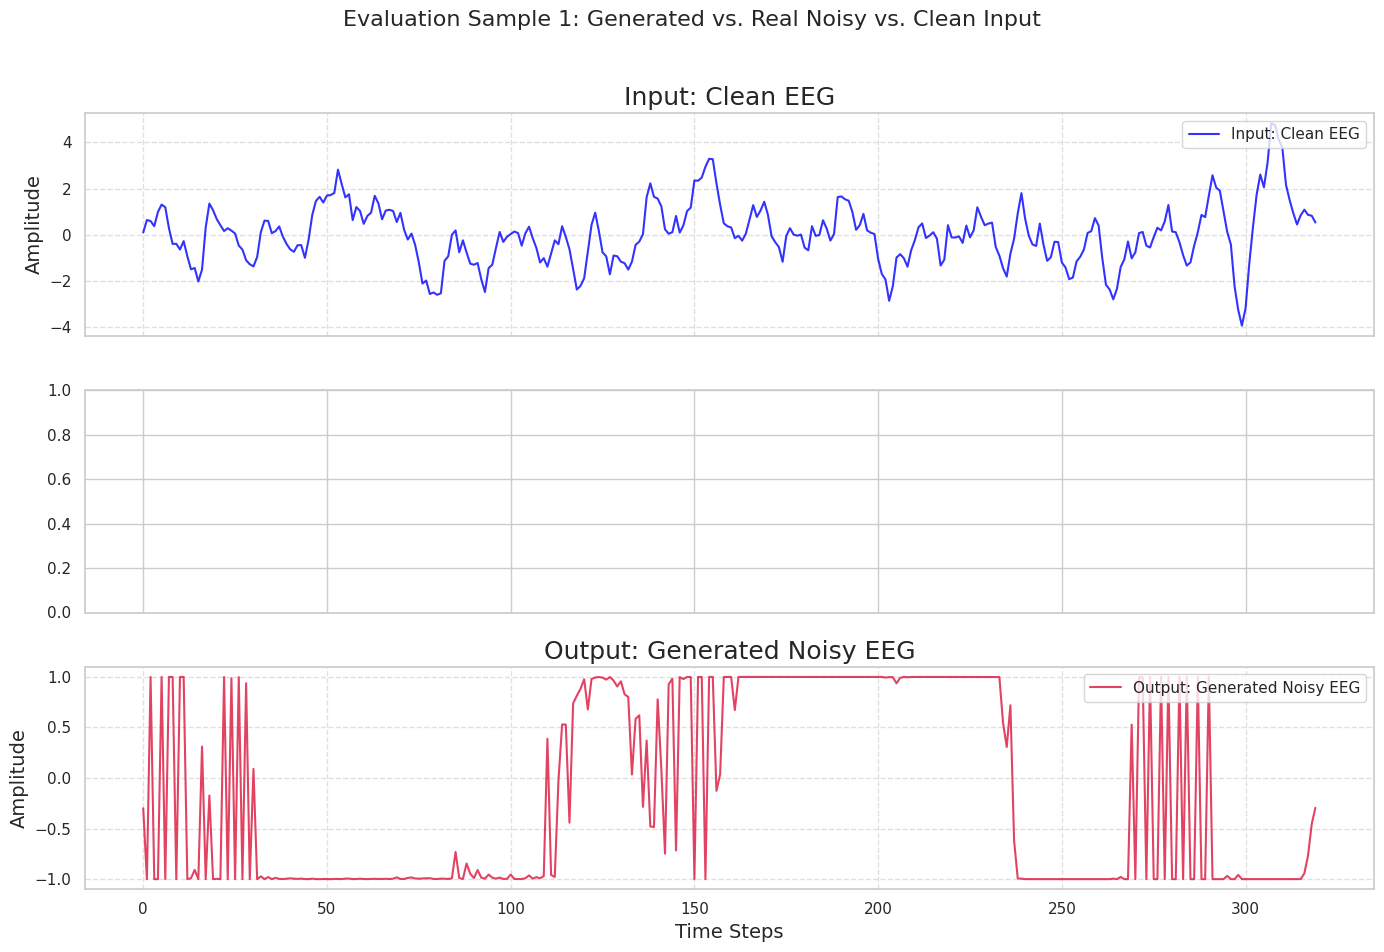

Saved visualization: /content/drive/My Drive/FYP/evaluation_visualizations/eval_sample_02.png


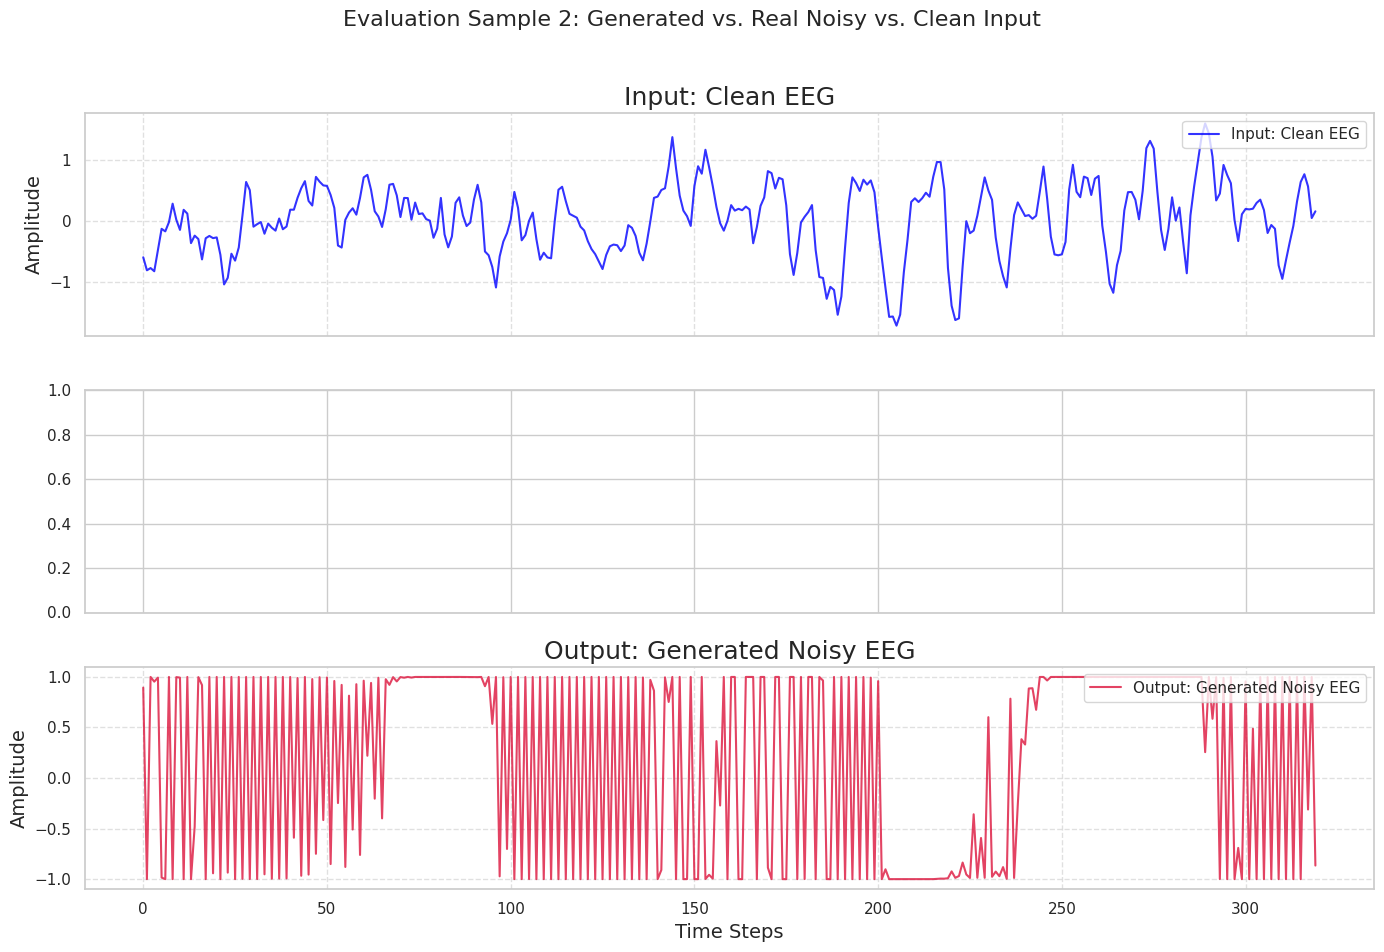

Saved visualization: /content/drive/My Drive/FYP/evaluation_visualizations/eval_sample_03.png


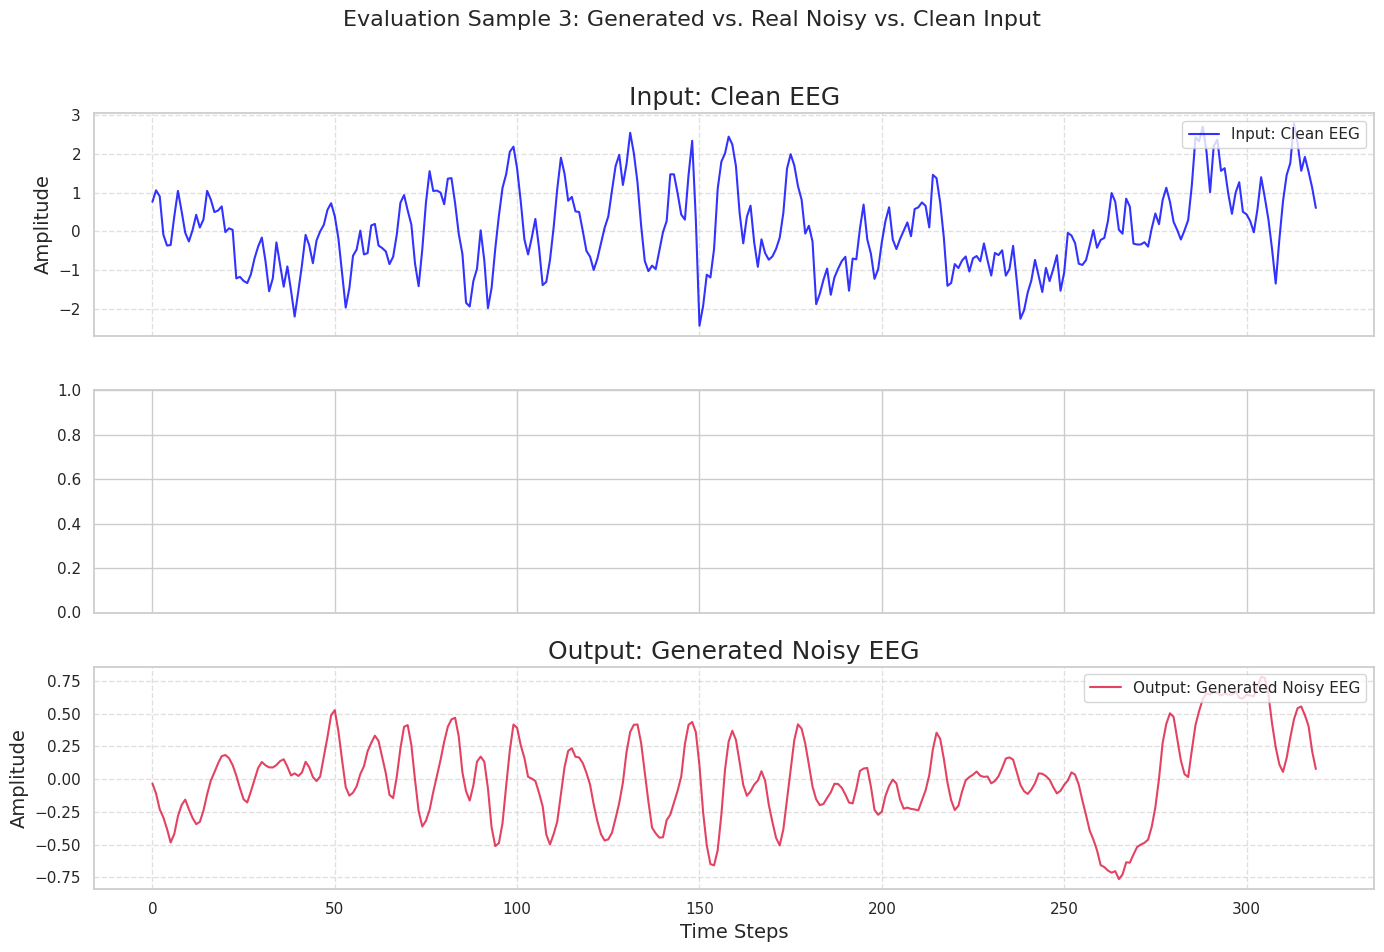

Saved visualization: /content/drive/My Drive/FYP/evaluation_visualizations/eval_sample_04.png


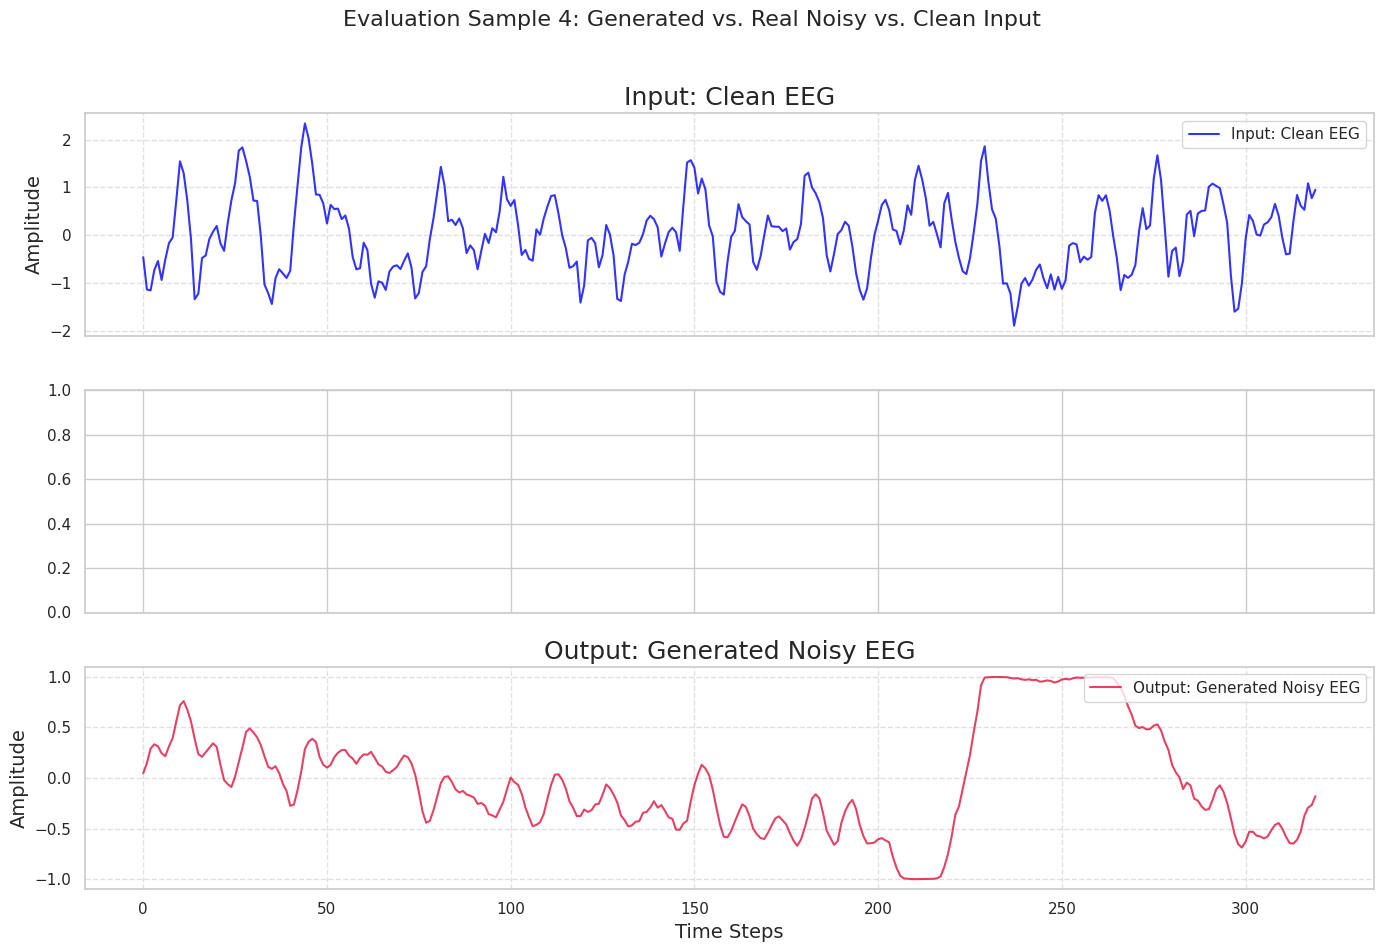

Saved visualization: /content/drive/My Drive/FYP/evaluation_visualizations/eval_sample_05.png


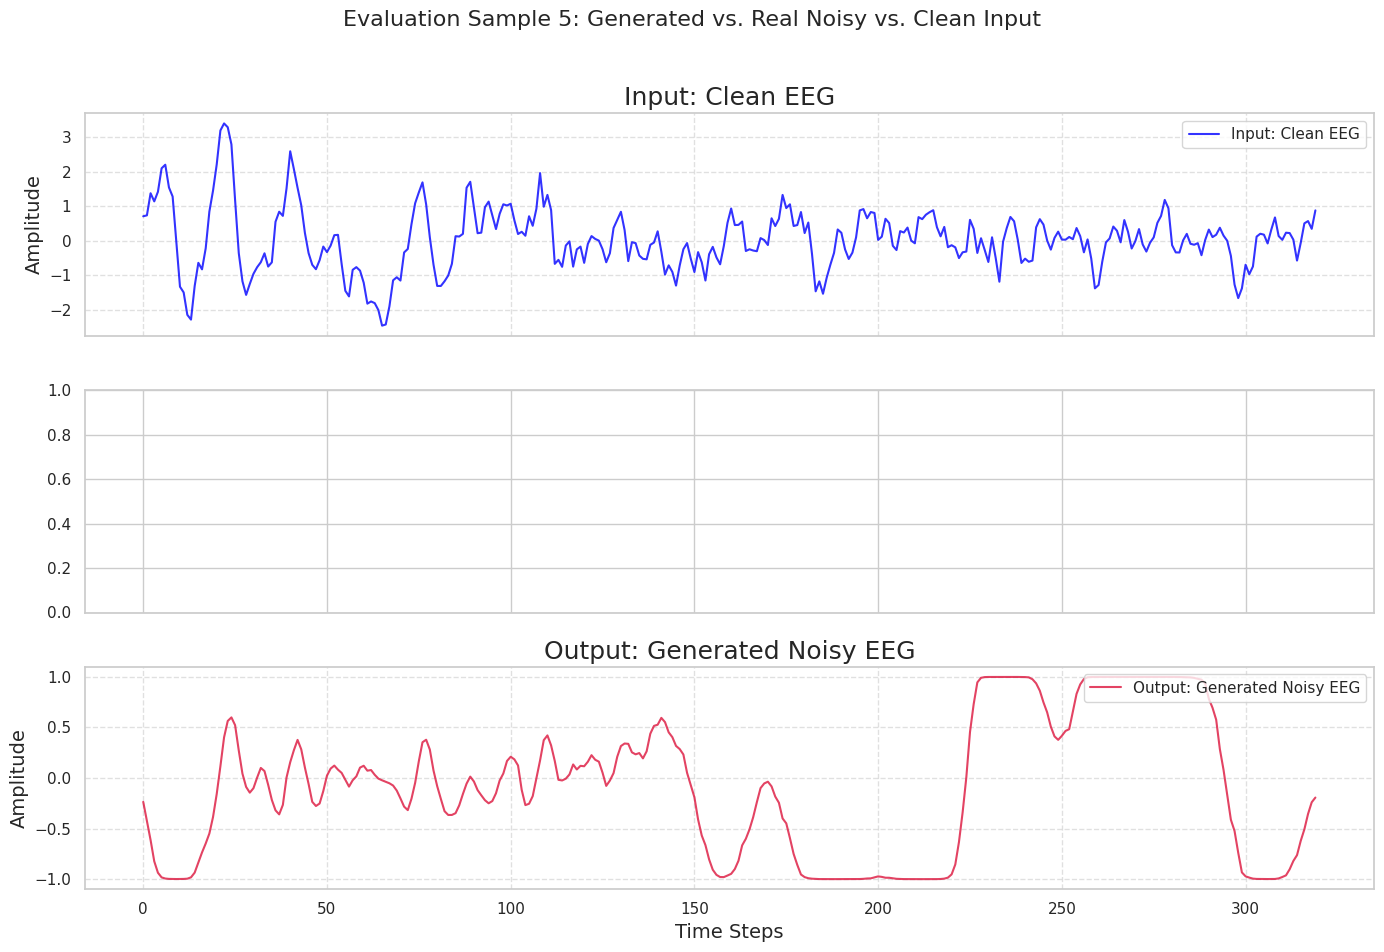


Evaluation visualization complete.


In [ ]:
# =============================================================================
# 7. VISUALIZE EVALUATION SAMPLES
# =============================================================================

print("\n--- Visualizing Evaluation Samples ---")

# Fetch a batch from the test dataloader for visualization
try:
    # Get a batch from the test set conditions loader
    # Ensure 'dataloaders' is defined and has a 'test' key
    if 'dataloaders' not in globals() or 'test' not in dataloaders:
         raise NameError("Condition dataloaders ('dataloaders') not found or missing 'test' key.")

    viz_conditions_batch = next(iter(dataloaders['test']))
    viz_conditions = (viz_conditions_batch[0] if isinstance(viz_conditions_batch, (list, tuple)) else viz_conditions_batch).to(DEVICE)

    # Get a corresponding batch from the test set real noisy loader (for comparison)
    # Ensure 'real_noisy_loaders' is defined and has a 'test' key
    if 'real_noisy_loaders' not in globals() or 'test' not in real_noisy_loaders:
         raise NameError("Real noisy dataloaders ('real_noisy_loaders') not found or missing 'test' key.")

    viz_real_noisy_batch = next(iter(real_noisy_loaders['test'])) # Assuming real_noisy_loaders is available and has a 'test' split
    viz_real_noisy = (viz_real_noisy_batch[0] if isinstance(viz_real_noisy_batch, (list, tuple)) else viz_real_noisy_batch).to(DEVICE)

    # Ensure batch sizes match for visualization
    viz_batch_size = min(viz_conditions.size(0), viz_real_noisy.size(0))
    viz_conditions = viz_conditions[:viz_batch_size]
    viz_real_noisy = viz_real_noisy[:viz_batch_size]

    # Ensure real_noisy_eval has a channel dimension [batch, 1, seq_len] if needed
    if viz_real_noisy.dim() == 2:
        viz_real_noisy = viz_real_noisy.unsqueeze(1)


except (StopIteration, NameError) as e:
    print(f"--- ERROR: Could not fetch batch for visualization: {e} ---")
    print("Please ensure dataloaders['test'] and real_noisy_loaders['test'] are properly defined and not empty.")
    viz_conditions = None # Set to None to skip plotting if batch fetching failed
    viz_real_noisy = None # Set to None to skip plotting if batch fetching failed


# Generate fake noisy data for visualization using the loaded generator
# Ensure 'generator' is defined and loaded in a previous cell
if 'generator' not in globals() or not isinstance(generator, torch.nn.Module):
     print("--- ERROR: Generator model not found. Skipping visualization. ---")
     viz_conditions = None # Ensure plotting is skipped
     viz_real_noisy = None # Ensure plotting is skipped


if viz_conditions is not None and viz_real_noisy is not None:
    generator.eval() # Ensure generator is in evaluation mode
    with torch.no_grad():
        # Generate fake noisy data for visualization using the loaded generator
        viz_noise = torch.randn(viz_conditions.size(0), LATENT_DIM, device=DEVICE) # Ensure LATENT_DIM and DEVICE are defined
        viz_fake_noisy = generator(viz_conditions, viz_noise)

    # --- Plotting Samples ---
    num_viz_samples = min(5, viz_batch_size) # Visualize up to 5 samples

    # Check if the necessary data shapes are correct for plotting
    if viz_conditions.shape[1] >= 1 and viz_real_noisy.shape[1] == 1 and viz_fake_noisy.shape[1] == 1:

        for i in range(num_viz_samples):
            # Clean EEG is typically the first channel (index 0) in the 3-channel condition batch
            clean_eeg_sample = viz_conditions[i, 0, :].cpu().numpy()
            # Real noisy and generated are expected to be single channel
            real_noisy_sample = viz_real_noisy[i, 0, :].cpu().numpy()
            generated_sample = viz_fake_noisy[i, 0, :].cpu().numpy()

            fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
            fig.suptitle(f'Evaluation Sample {i+1}: Generated vs. Real Noisy vs. Clean Input', fontsize=16)

            axs[0].plot(clean_eeg_sample, label="Input: Clean EEG", color='blue', alpha=0.8)
            axs[0].set_title("Input: Clean EEG")
            axs[0].grid(True, linestyle='--', alpha=0.6)
            axs[0].legend(loc='upper right')
            axs[0].set_ylabel("Amplitude")

            # axs[1].plot(real_noisy_sample, label="Target: Real Noisy EEG", color='orange', alpha=0.8)
            # axs[1].set_title("Target: Real Noisy EEG")
            # axs[1].grid(True, linestyle='--', alpha=0.6)
            # axs[1].legend(loc='upper right')
            # axs[1].set_ylabel("Amplitude")

            axs[2].plot(generated_sample, label="Output: Generated Noisy EEG", color='crimson', alpha=0.8)
            axs[2].set_title("Output: Generated Noisy EEG")
            axs[2].grid(True, linestyle='--', alpha=0.6)
            axs[2].legend(loc='upper right')
            axs[2].set_xlabel("Time Steps")
            axs[2].set_ylabel("Amplitude")


            plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to make room for suptitle

            # Save the plot
            # Ensure OUTPUT_EVAL_VIZ_DIR is defined
            if 'OUTPUT_EVAL_VIZ_DIR' in globals():
                filename = os.path.join(OUTPUT_EVAL_VIZ_DIR, f"eval_sample_{i+1:02d}.png")
                try:
                    plt.savefig(filename)
                    print(f"Saved visualization: {filename}")
                except Exception as e:
                    print(f"Error saving visualization {filename}: {e}")
            else:
                 print("Warning: OUTPUT_EVAL_VIZ_DIR is not defined. Skipping saving visualization.")


            plt.show()
            plt.close(fig)

    else:
        print(f"Warning: Skipping sample visualization due to unexpected tensor shapes for plotting.")
        print(f" viz_conditions shape: {viz_conditions.shape}, viz_real_noisy shape: {viz_real_noisy.shape}, viz_fake_noisy shape: {viz_fake_noisy.shape}")


print("\nEvaluation visualization complete.")

In [ ]:
# =============================================================================
# 7. VISUALIZE EVALUATION SAMPLES
# =============================================================================

print("\n--- Visualizing Evaluation Samples ---")

# Fetch a batch from the test dataloader for visualization
try:
    # Get a batch from the test set conditions loader
    # Ensure 'dataloaders' is defined and has a 'test' key
    if 'dataloaders' not in globals() or 'test' not in dataloaders:
         raise NameError("Condition dataloaders ('dataloaders') not found or missing 'test' key.")

    viz_conditions_batch = next(iter(dataloaders['test']))
    viz_conditions = (viz_conditions_batch[0] if isinstance(viz_conditions_batch, (list, tuple)) else viz_conditions_batch).to(DEVICE)

    # Get a corresponding batch from the test set real noisy loader (for comparison)
    # Ensure 'real_noisy_loaders' is defined and has a 'test' key
    # This part is kept to ensure viz_batch_size calculation is correct if needed,
    # although the real_noisy_sample plot is being removed.
    if 'real_noisy_loaders' not in globals() or 'test' not in real_noisy_loaders:
         # If real_noisy_loaders is not available, calculate batch size based on conditions only
         print("Warning: 'real_noisy_loaders' not found or missing 'test' key. Calculating batch size based on conditions only.")
         viz_batch_size = viz_conditions.size(0)
         viz_real_noisy = None # Set to None as it won't be plotted
    else:
        viz_real_noisy_batch = next(iter(real_noisy_loaders['test'])) # Assuming real_noisy_loaders is available and has a 'test' split
        viz_real_noisy = (viz_real_noisy_batch[0] if isinstance(viz_real_noisy_batch, (list, tuple)) else viz_real_noisy_batch).to(DEVICE)

        # Ensure batch sizes match for visualization
        viz_batch_size = min(viz_conditions.size(0), viz_real_noisy.size(0))
        viz_conditions = viz_conditions[:viz_batch_size]
        viz_real_noisy = viz_real_noisy[:viz_batch_size]

        # Ensure real_noisy_eval has a channel dimension [batch, 1, seq_len] if needed
        if viz_real_noisy is not None and viz_real_noisy.dim() == 2:
            viz_real_noisy = viz_real_noisy.unsqueeze(1)


except (StopIteration, NameError) as e:
    print(f"--- ERROR: Could not fetch batch for visualization: {e} ---")
    print("Please ensure dataloaders['test'] is properly defined and not empty.")
    print("Also ensure real_noisy_loaders['test'] is properly defined if you intend to use it for batch size alignment.")
    viz_conditions = None # Set to None to skip plotting if batch fetching failed
    viz_real_noisy = None # Set to None as it won't be plotted


# Generate fake noisy data for visualization using the loaded generator
# Ensure 'generator' is defined and loaded in a previous cell
if 'generator' not in globals() or not isinstance(generator, torch.nn.Module):
     print("--- ERROR: Generator model not found. Skipping visualization. ---")
     viz_conditions = None # Ensure plotting is skipped


if viz_conditions is not None: # Only proceed if conditional data was fetched
    generator.eval() # Ensure generator is in evaluation mode
    with torch.no_grad():
        # Generate fake noisy data for visualization using the loaded generator
        viz_noise = torch.randn(viz_conditions.size(0), LATENT_DIM, device=DEVICE) # Ensure LATENT_DIM and DEVICE are defined
        viz_fake_noisy = generator(viz_conditions, viz_noise)

    # --- Plotting Samples ---
    num_viz_samples = min(5, viz_conditions.size(0)) # Visualize up to 5 samples from the fetched conditional batch

    # Check if the necessary data shapes are correct for plotting
    # We need at least 1 channel in conditions (for Clean EEG) and 1 channel in generated_noisy
    if viz_conditions.shape[1] >= 1 and viz_fake_noisy.shape[1] == 1:

        for i in range(num_viz_samples):
            # Clean EEG is typically the first channel (index 0) in the 3-channel condition batch
            clean_eeg_sample = viz_conditions[i, 0, :].cpu().numpy()
            # Generated is expected to be single channel
            generated_sample = viz_fake_noisy[i, 0, :].cpu().numpy()

            # --- MODIFIED: Create 2 subplots instead of 3 ---
            fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True) # Adjusted figsize for 2 plots
            fig.suptitle(f'Evaluation Sample {i+1}: Generated Noisy vs. Clean Input', fontsize=16) # Adjusted title

            # Plot 1: Clean Input
            axs[0].plot(clean_eeg_sample, label="Input: Clean EEG", color='blue', alpha=0.8)
            axs[0].set_title("Input: Clean EEG")
            axs[0].grid(True, linestyle='--', alpha=0.6)
            axs[0].legend(loc='upper right')
            axs[0].set_ylabel("Amplitude")

            # Plot 2 (was Plot 3): Generated Noisy
            axs[1].plot(generated_sample, label="Output: Generated Noisy EEG", color='crimson', alpha=0.8, linestyle='--')
            axs[1].set_title("Output: Generated Noisy EEG")
            axs[1].grid(True, linestyle='--', alpha=0.6)
            axs[1].legend(loc='upper right')
            axs[1].set_xlabel("Time Steps")
            axs[1].set_ylabel("Amplitude")


            plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to make room for suptitle

            # Save the plot
            # Ensure OUTPUT_EVAL_VIZ_DIR is defined
            if 'OUTPUT_EVAL_VIZ_DIR' in globals():
                filename = os.path.join(OUTPUT_EVAL_VIZ_DIR, f"eval_sample_{i+1:02d}_clean_gen.png") # Modified filename
                try:
                    plt.savefig(filename)
                    print(f"Saved visualization: {filename}")
                except Exception as e:
                    print(f"Error saving visualization {filename}: {e}")
            else:
                 print("Warning: OUTPUT_EVAL_VIZ_DIR is not defined. Skipping saving visualization.")


            plt.show()
            plt.close(fig)

    else:
        print(f"Warning: Skipping sample visualization due to unexpected tensor shapes for plotting.")
        print(f" viz_conditions shape: {viz_conditions.shape}, viz_fake_noisy shape: {viz_fake_noisy.shape}")


else:
    print("\nSkipping visualization because conditional data could not be fetched.")


print("\nEvaluation visualization complete.")

### FEATURE EXTRATION VISUALIZATION

Next, we will get a few batches of conditional data from the test set and generate corresponding noisy samples using the loaded generator.

We have now visualized the feature distributions and compared the time series and PSDs of a few samples from the conditional input and the generated noisy output.

This completes the task of researching and proposing additional evaluation metrics, outlining their implementation, integrating them into the evaluation code, and visualizing the results, including feature comparisons and sample-wise PSDs.

The evaluation metrics provide quantitative measures of the GAN's performance beyond feature matching loss, while the visualizations offer qualitative insights into the generated signal characteristics.

Feature comparison visualizations will be saved to: /content/drive/My Drive/FYP/feature_comparison_visualizations_detailed
Saving of generated samples is currently disabled.
Using device: cuda


--- Starting DETAILED Feature Extraction Analysis and Visualization ---

=> Loading generator state from checkpoint: '/content/drive/My Drive/FYP/checkpoints/best_model.pth'
=> Generator model loaded successfully.
Generator set to evaluation mode (eval()).




Total conditional samples collected: 100
Total generated samples collected: 100

Saving of generated samples is disabled by configuration.

Extracting features...
Feature extraction complete.
Conditional features shape (linear): (100, 2)
Generated features shape (linear): (100, 2)

Creating detailed feature table...
✅ Successfully saved detailed feature table to 'eegdenoisenet_feature_comparison_detailed.csv'

Visualizing feature distributions with box plots...


/tmp/ipython-input-516786806.py:358: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_df_melted[feature_df_melted['Feature Type'].isin(['Conditional EOG Low', 'Generated Low'])],


Saved low power box plot: /content/drive/My Drive/FYP/feature_comparison_visualizations_detailed/boxplot_low_power.png


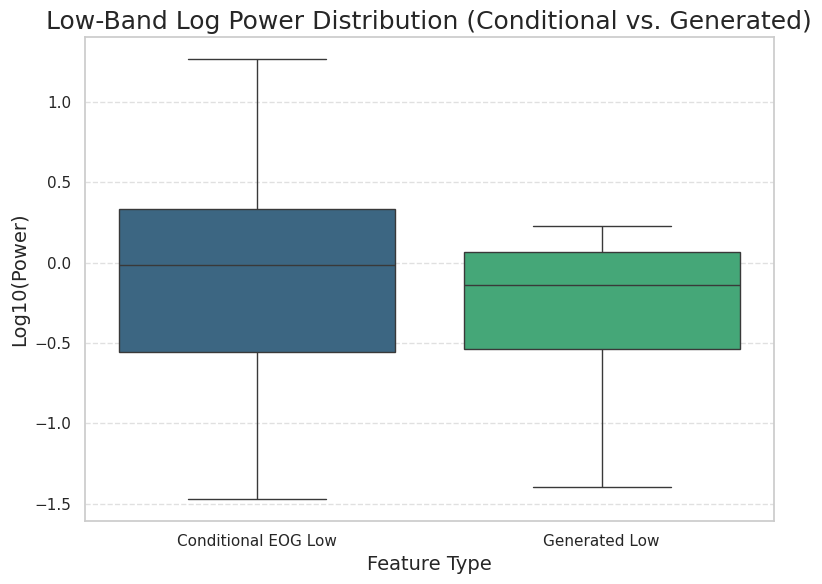

/tmp/ipython-input-516786806.py:375: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_df_melted[feature_df_melted['Feature Type'].isin(['Conditional EMG High', 'Generated High'])],


Saved high power box plot: /content/drive/My Drive/FYP/feature_comparison_visualizations_detailed/boxplot_high_power.png


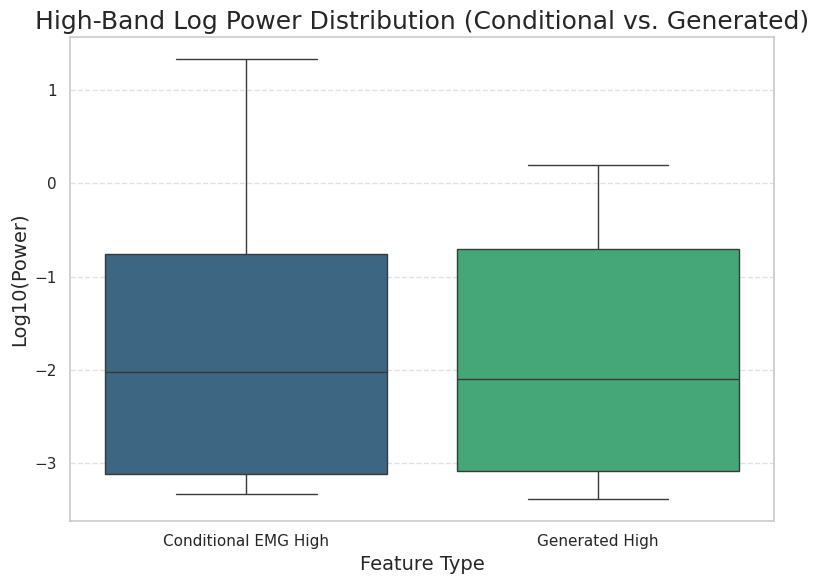


Calculating and visualizing average PSD...
Saved average PSD plot: /content/drive/My Drive/FYP/feature_comparison_visualizations_detailed/average_psd_comparison.png


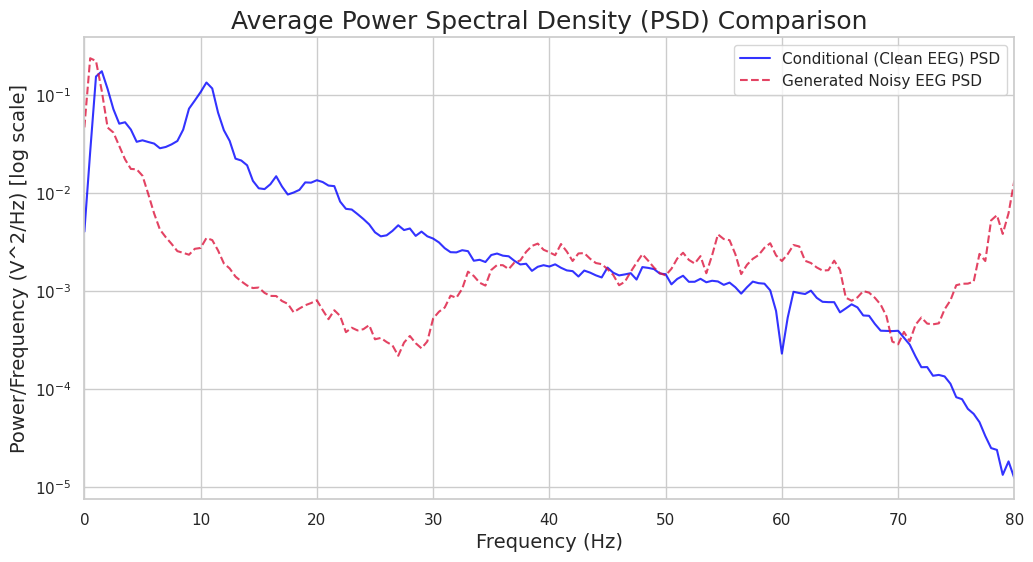


--- Detailed Feature Analysis Complete ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import torch
from tqdm.auto import tqdm

# Assuming necessary functions/classes are defined in previous cells:
# - bandpower_torch
# - UNet1DGenerator (model architecture)
# - dataloaders (dictionary with 'test' key)
# - LATENT_DIM (dimension of generator's latent space)
# - INPUT_LENGTH (sequence length)
# - FS (sampling frequency)
# - GOOGLE_DRIVE_BASE_DIR (base directory in Google Drive)


# --- Analysis Configuration ---
FS = 160  # sampling rate (Hz) - Ensure this matches the project
SEQ_LEN = 320 # samples per epoch - Ensure this matches the project
NUM_SAMPLES_TO_ANALYZE = 100 # Number of samples to use for detailed analysis

OUTPUT_CSV_FILE = "eegdenoisenet_feature_comparison_detailed.csv"
OUTPUT_VIZ_DIR_FEATURES = os.path.join(GOOGLE_DRIVE_BASE_DIR, "feature_comparison_visualizations_detailed")
CHECKPOINT_PATH = os.path.join(GOOGLE_DRIVE_BASE_DIR, "checkpoints", "best_model.pth")

# New directory to save generated samples
GENERATED_SAMPLES_DIR = os.path.join(GOOGLE_DRIVE_BASE_DIR, "generated_noisy_samples")

# --- Control Variable for Saving Samples ---
SAVE_GENERATED_SAMPLES = "not_save" # Set to "save" to save the .npy files


# Create output directory for visualizations and generated samples
os.makedirs(OUTPUT_VIZ_DIR_FEATURES, exist_ok=True)
# Only create the generated samples directory if saving is enabled
if SAVE_GENERATED_SAMPLES == "save":
    os.makedirs(GENERATED_SAMPLES_DIR, exist_ok=True)


print(f"Feature comparison visualizations will be saved to: {OUTPUT_VIZ_DIR_FEATURES}")
if SAVE_GENERATED_SAMPLES == "save":
    print(f"Generated samples will be saved to: {GENERATED_SAMPLES_DIR}")
else:
    print("Saving of generated samples is currently disabled.")


# Define the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# --- MODIFIED Feature Extraction Wrappers ---
# This version returns both the raw linear power and the log-transformed power.
# CONFIRMED: This function uses the correct, explicit logic.
def feature_cond_detailed(batch, fs=160):
    """
    Extracts specific features from the 3-channel condition batch.
    Returns two tensors: one with linear power, one with log10 power.
    """
    # Isolate the EOG and EMG signals from the 3-channel condition
    # Ensure batch has at least 3 channels before slicing
    if batch.shape[1] < 3:
        raise ValueError(f"Conditional batch must have at least 3 channels, but got shape {batch.shape}")

    eog_signal = batch[:, 1, :] # Assuming EOG is channel 1 (index 1)
    emg_signal = batch[:, 2, :] # Assuming EMG is channel 2 (index 2)


    # 1. Calculate the raw linear power for each artifact
    # Use consistent frequency bands
    eog_low_band = (0.5, 8)
    emg_high_band = (30, 80)

    eog_low_power_linear = bandpower_torch(eog_signal, fs, band=eog_low_band)
    emg_high_power_linear = bandpower_torch(emg_signal, fs, band=emg_high_band)


    # 2. Apply the log10 transform to get the final features
    # Add a small epsilon before log to avoid -inf
    eog_low_power_log = torch.log10(eog_low_power_linear + 1e-9)
    emg_high_power_log = torch.log10(emg_high_power_linear + 1e-9)

    # 3. Stack them into separate tensors
    linear_features = torch.stack([eog_low_power_linear, emg_high_power_linear], dim=1)
    log_features = torch.stack([eog_low_power_log, emg_high_power_log], dim=1)

    return linear_features, log_features


# NEW: Detailed feature extraction for the 1-channel generated output
def feature_out_detailed(generated_batch, fs=160):
    """
    Extracts the corresponding features from the 1-channel generated output.
    - Feature 1: Low-band power from the generated signal
    - Feature 2: High-band power from the generated signal
    Returns two tensors: one with linear power, one with log10 power.
    """
    # Ensure input is in [batch, 1, seq_len] format and has at least 1 channel
    if generated_batch.ndim == 2:
        generated_signal = generated_batch # Assume [batch_size, seq_len]
    elif generated_batch.ndim == 3 and generated_batch.shape[1] == 1:
        generated_signal = generated_batch[:, 0, :] # Assume [batch_size, 1, seq_len] -> [batch_size, seq_len]
    else:
        raise ValueError(f"Generated batch must have shape [batch, seq_len] or [batch, 1, seq_len], but got shape {generated_batch.shape}")


    # Use the same consistent frequency bands as feature_cond_detailed
    low_band = (0.5, 8)
    high_band = (30, 80)

    # 1. Calculate the raw linear power for the generated signal
    gen_low_power_linear = bandpower_torch(generated_signal, fs, band=low_band)
    gen_high_power_linear = bandpower_torch(generated_signal, fs, band=high_band)


    # 2. Apply the log10 transform
    # Add a small epsilon before log to avoid -inf
    gen_low_power_log = torch.log10(gen_low_power_linear + 1e-9)
    gen_high_power_log = torch.log10(gen_high_power_linear + 1e-9)

    # 3. Stack them into separate tensors
    linear_features = torch.stack([gen_low_power_linear, gen_high_power_linear], dim=1)
    log_features = torch.stack([gen_low_power_log, gen_high_power_log], dim=1)

    return linear_features, log_features


# --- Main Analysis Logic ---
if __name__ == '__main__':
    print("\n\n--- Starting DETAILED Feature Extraction Analysis and Visualization ---")

    # --- Load the trained Generator Model ---
    try:
        # Ensure UNet1DGenerator class is defined
        if 'UNet1DGenerator' not in globals():
            raise NameError("UNet1DGenerator class not found. Please ensure it is defined in a previous cell.")

        generator = UNet1DGenerator(input_length=INPUT_LENGTH, num_channels=3, latent_dim=LATENT_DIM).to(DEVICE)

        if os.path.exists(CHECKPOINT_PATH):
            print(f"\n=> Loading generator state from checkpoint: '{CHECKPOINT_PATH}'")
            checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)
            generator.load_state_dict(checkpoint['generator_state_dict'])
            print("=> Generator model loaded successfully.")
        else:
            raise FileNotFoundError(f"Checkpoint file not found at {CHECKPOINT_PATH}")

    except (NameError, FileNotFoundError) as e:
        print(f"--- FATAL ERROR during model loading: {e} ---")
        print("Please ensure model architecture is defined and checkpoint path is correct.")
        # Set generator to None to skip subsequent steps
        generator = None


    # Set generator to evaluation mode
    if generator is not None:
        generator.eval()
        print("Generator set to evaluation mode (eval()).")
    else:
        print("Skipping data generation and feature extraction due to generator loading failure.")


    # --- Collect Conditional and Generate Samples ---
    all_conditions = []
    all_generated_noisy = []
    samples_collected = 0

    if generator is not None:
        try:
            # Assuming 'dataloaders' and 'dataloaders['test']' are defined and accessible
            if 'dataloaders' not in globals() or 'test' not in dataloaders:
                raise NameError("Conditional data dataloaders ('dataloaders') not found or missing 'test' key.")

            test_loader_conditional = dataloaders['test']

            print(f"\nCollecting up to {NUM_SAMPLES_TO_ANALYZE} samples from the test set and generating noisy data...")

            # Iterate through the test loader until enough samples are collected
            with torch.no_grad(): # No gradients needed for inference
                 prog_bar_collect = tqdm(test_loader_conditional, desc="Collecting Samples and Generating")
                 for i, batch_data in enumerate(prog_bar_collect):

                     # Assuming the first element of the batch is the data tensor
                     conditions = batch_data[0] if isinstance(batch_data, (list, tuple)) else batch_data

                     # Move conditions to the device
                     conditions = conditions.to(DEVICE)

                     # Generate corresponding noisy data using the generator
                     noise = torch.randn(conditions.size(0), LATENT_DIM, device=DEVICE) # Ensure LATENT_DIM and DEVICE are defined
                     generated_noisy = generator(conditions, noise)

                     # Move generated data back to CPU and detach
                     conditions_np = conditions.cpu().numpy()
                     generated_noisy_np = generated_noisy.cpu().numpy()

                     # Collect samples up to the desired number
                     num_samples_in_batch = conditions_np.shape[0]
                     samples_to_take = min(num_samples_in_batch, NUM_SAMPLES_TO_ANALYZE - samples_collected)

                     all_conditions.append(conditions_np[:samples_to_take])
                     all_generated_noisy.append(generated_noisy_np[:samples_to_take])

                     samples_collected += samples_to_take

                     prog_bar_collect.set_postfix({'Collected': samples_collected})

                     if samples_collected >= NUM_SAMPLES_TO_ANALYZE:
                         break

            if samples_collected < NUM_SAMPLES_TO_ANALYZE:
                 print(f"Warning: Could not collect {samples_collected} samples (less than requested {NUM_SAMPLES_TO_ANALYZE}).")


            # Concatenate collected samples
            all_conditions_arr = np.concatenate(all_conditions, axis=0) if all_conditions else np.array([])
            all_generated_noisy_arr = np.concatenate(all_generated_noisy, axis=0) if all_generated_noisy else np.array([])

            print(f"\nTotal conditional samples collected: {all_conditions_arr.shape[0]}")
            print(f"Total generated samples collected: {all_generated_noisy_arr.shape[0]}")

            # --- Save the 100 generated samples to .npy files (Conditional) ---
            if SAVE_GENERATED_SAMPLES == "save":
                print(f"\nSaving {all_generated_noisy_arr.shape[0]} generated samples to '{GENERATED_SAMPLES_DIR}'...")
                if all_generated_noisy_arr.shape[0] > 0:
                     # Ensure the generated data is in the correct shape for saving (e.g., [seq_len] per sample)
                     # It's currently [num_samples, 1, seq_len]. Squeeze the channel dimension.
                     generated_samples_to_save = all_generated_noisy_arr.squeeze(1) # Shape: [num_samples, seq_len]

                     # Verify the shape before saving
                     if generated_samples_to_save.shape[1] != SEQ_LEN:
                          print(f"Error: Generated sample shape ({generated_samples_to_save.shape}) does not match expected sequence length ({SEQ_LEN}). Skipping save.")
                     else:
                         for k in tqdm(range(generated_samples_to_save.shape[0]), desc="Saving Generated Samples"):
                             sample_filename = os.path.join(GENERATED_SAMPLES_DIR, f"generated_sample_{k:03d}.npy")
                             np.save(sample_filename, generated_samples_to_save[k])
                         print("Successfully saved generated samples.")
                else:
                    print("No generated samples to save.")
            else:
                print("\nSaving of generated samples is disabled by configuration.")


        except (NameError, StopIteration) as e:
            print(f"--- ERROR getting batches or generating data: {e} ---")
            print("Please ensure dataloaders['test'] is defined, not empty, and accessible.")
            all_conditions_arr = np.array([])
            all_generated_noisy_arr = np.array([])


    # --- Extract Features ---
    conditional_features_linear = None
    conditional_features_log = None
    generated_features_linear = None
    generated_features_log = None

    if all_conditions_arr.shape[0] > 0 and all_generated_noisy_arr.shape[0] > 0:
        print("\nExtracting features...")
        try:
            # Convert NumPy arrays back to PyTorch tensors for feature extraction functions
            all_conditions_tensor = torch.tensor(all_conditions_arr, dtype=torch.float32).to(DEVICE)
            all_generated_noisy_tensor = torch.tensor(all_generated_noisy_arr, dtype=torch.float32).to(DEVICE)

            # Ensure generated_noisy_tensor has a channel dimension if needed by feature_out_detailed
            if all_generated_noisy_tensor.ndim == 2:
                 all_generated_noisy_tensor = all_generated_noisy_tensor.unsqueeze(1)


            with torch.no_grad(): # Ensure no gradients are calculated
                 # Extract features for conditional data
                 conditional_features_linear, conditional_features_log = feature_cond_detailed(all_conditions_tensor, fs=FS)
                 # Extract features for generated data
                 generated_features_linear, generated_features_log = feature_out_detailed(all_generated_noisy_tensor, fs=FS)

            # Move features back to CPU and convert to NumPy arrays for analysis/plotting
            conditional_features_linear_np = conditional_features_linear.cpu().numpy()
            conditional_features_log_np = conditional_features_log.cpu().numpy()
            generated_features_linear_np = generated_features_linear.cpu().numpy()
            generated_features_log_np = generated_features_log.cpu().numpy()

            print("Feature extraction complete.")
            print(f"Conditional features shape (linear): {conditional_features_linear_np.shape}")
            print(f"Generated features shape (linear): {generated_features_linear_np.shape}")

        except Exception as e:
            print(f"--- ERROR during feature extraction: {e} ---")
            # Set variables to None to skip subsequent steps
            conditional_features_linear_np = None
            conditional_features_log_np = None
            generated_features_linear_np = None
            generated_features_log_np = None


    # --- Create and Save Detailed Feature Table (CSV) ---
    if conditional_features_linear_np is not None and generated_features_linear_np is not None:
        print("\nCreating detailed feature table...")
        try:
            # Assuming 2 features: EOG Low-Band and EMG High-Band
            if conditional_features_linear_np.shape[1] == 2 and generated_features_linear_np.shape[1] == 2:
                feature_data = {
                    'Sample_Index': np.arange(conditional_features_linear_np.shape[0]),
                    'Conditional_EOG_Low_Linear': conditional_features_linear_np[:, 0],
                    'Conditional_EOG_Low_Log': conditional_features_log_np[:, 0],
                    'Conditional_EMG_High_Linear': conditional_features_linear_np[:, 1],
                    'Conditional_EMG_High_Log': conditional_features_log_np[:, 1],
                    'Generated_Low_Linear': generated_features_linear_np[:, 0],
                    'Generated_Low_Log': generated_features_log_np[:, 0],
                    'Generated_High_Linear': generated_features_linear_np[:, 1],
                    'Generated_High_Log': generated_features_log_np[:, 1],
                }
                features_df_detailed = pd.DataFrame(feature_data)

                # Save to CSV
                try:
                    features_df_detailed.to_csv(OUTPUT_CSV_FILE, index=False)
                    print(f"✅ Successfully saved detailed feature table to '{OUTPUT_CSV_FILE}'")
                except Exception as e:
                    print(f"❌ Error saving detailed feature table to CSV: {e}")

            else:
                 print("Warning: Unexpected number of features. Skipping detailed feature table creation.")
                 features_df_detailed = None

        except Exception as e:
            print(f"--- ERROR creating detailed feature table: {e} ---")
            features_df_detailed = None

    else:
        print("Skipping detailed feature table creation as features were not extracted.")
        features_df_detailed = None


    # --- Visualize Feature Distributions (Box Plots) ---
    if features_df_detailed is not None and not features_df_detailed.empty:
        print("\nVisualizing feature distributions with box plots...")
        try:
            # Melt the DataFrame for easier plotting with Seaborn
            # Select only the log-transformed features for box plots
            feature_df_melted = features_df_detailed[['Conditional_EOG_Low_Log', 'Generated_Low_Log',
                                                       'Conditional_EMG_High_Log', 'Generated_High_Log']].melt(
                var_name='Feature Type', value_name='Log Power'
            )

            # Map feature names to cleaner labels for the plot
            feature_map = {
                'Conditional_EOG_Low_Log': 'Conditional EOG Low',
                'Generated_Low_Log': 'Generated Low',
                'Conditional_EMG_High_Log': 'Conditional EMG High',
                'Generated_High_Log': 'Generated High'
            }
            feature_df_melted['Feature Type'] = feature_df_melted['Feature Type'].map(feature_map)


            # Create box plots for Low Power (Conditional vs. Generated)
            plt.figure(figsize=(8, 6))
            sns.boxplot(data=feature_df_melted[feature_df_melted['Feature Type'].isin(['Conditional EOG Low', 'Generated Low'])],
                        x='Feature Type', y='Log Power', palette='viridis')
            plt.title('Low-Band Log Power Distribution (Conditional vs. Generated)')
            plt.ylabel('Log10(Power)')
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout()
            filename_low_power = os.path.join(OUTPUT_VIZ_DIR_FEATURES, "boxplot_low_power.png")
            try:
                plt.savefig(filename_low_power)
                print(f"Saved low power box plot: {filename_low_power}")
            except Exception as e:
                print(f"Error saving low power box plot {filename_low_power}: {e}")
            plt.show()
            plt.close()

            # Create box plots for High Power (Conditional vs. Generated)
            plt.figure(figsize=(8, 6))
            sns.boxplot(data=feature_df_melted[feature_df_melted['Feature Type'].isin(['Conditional EMG High', 'Generated High'])],
                        x='Feature Type', y='Log Power', palette='viridis')
            plt.title('High-Band Log Power Distribution (Conditional vs. Generated)')
            plt.ylabel('Log10(Power)')
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout()
            filename_high_power = os.path.join(OUTPUT_VIZ_DIR_FEATURES, "boxplot_high_power.png")
            try:
                plt.savefig(filename_high_power)
                print(f"Saved high power box plot: {filename_high_power}")
            except Exception as e:
                print(f"Error saving high power box plot {filename_high_power}: {e}")
            plt.show()
            plt.close()

        except Exception as e:
            print(f"--- ERROR visualizing feature box plots: {e} ---")
            import traceback
            traceback.print_exc()


    # --- Visualize Average PSD ---
    if all_conditions_arr.shape[0] > 0 and all_generated_noisy_arr.shape[0] > 0:
         print("\nCalculating and visualizing average PSD...")
         try:
             # Ensure data is in correct shape [num_samples, seq_len] for PSD calculation
             # all_conditions_arr is [num_samples, num_channels, seq_len]
             # all_generated_noisy_arr is [num_samples, 1, seq_len] or [num_samples, seq_len]

             # Extract clean EEG from conditional data (assuming channel 0)
             # Ensure there is at least one channel before slicing
             if all_conditions_arr.shape[1] > 0:
                 clean_eeg_samples_np = all_conditions_arr[:, 0, :] # Shape: [num_samples, seq_len]
             else:
                  print("Warning: Conditional data has no channels for clean EEG. Skipping PSD calculation.")
                  clean_eeg_samples_np = None


             # Ensure generated data is [num_samples, seq_len]
             if all_generated_noisy_arr.ndim == 3 and all_generated_noisy_arr.shape[1] == 1:
                  generated_noisy_samples_np = all_generated_noisy_arr.squeeze(1) # Shape: [num_samples, seq_len]
             elif all_generated_noisy_arr.ndim == 2:
                  generated_noisy_samples_np = all_generated_noisy_arr # Shape: [num_samples, seq_len]
             else:
                  print(f"Warning: Unexpected generated data shape for PSD: {all_generated_noisy_arr.shape}. Skipping PSD calculation.")
                  generated_noisy_samples_np = None


             if clean_eeg_samples_np is not None and generated_noisy_samples_np is not None:
                 # PSD calculation parameters
                 nperseg_psd = 2 * FS # e.g., 2 seconds segment length for Welch
                 if nperseg_psd > clean_eeg_samples_np.shape[1]:
                      nperseg_psd = clean_eeg_samples_np.shape[1] # Use signal length as nperseg if shorter
                      print(f"Warning: nperseg ({2*FS}) is larger than signal length ({clean_eeg_samples_np.shape[1]}). Using signal length for PSD.")

                 if nperseg_psd > 0 and clean_eeg_samples_np.shape[1] >= nperseg_psd:
                      noverlap_psd = nperseg_psd // 2 # 50% overlap

                      # Calculate PSD for each sample and then average
                      all_real_psds = []
                      all_fake_psds = []

                      for j in range(clean_eeg_samples_np.shape[0]):
                          freqs_real, psd_real = welch(clean_eeg_samples_np[j], fs=FS, nperseg=nperseg_psd, noverlap=noverlap_psd)
                          freqs_fake, psd_fake = welch(generated_noisy_samples_np[j], fs=FS, nperseg=nperseg_psd, noverlap=noverlap_psd)
                          all_real_psds.append(psd_real)
                          all_fake_psds.append(psd_fake)

                      if all_real_psds: # Check if any PSDs were calculated
                           avg_psd_real = np.mean(np.stack(all_real_psds), axis=0)
                           avg_psd_fake = np.mean(np.stack(all_fake_psds), axis=0)

                           # Plot average PSDs
                           plt.figure(figsize=(12, 6))
                           # Add a small value before log to avoid -inf, then convert to dB
                           plt.semilogy(freqs_real, avg_psd_real + 1e-9, label="Conditional (Clean EEG) PSD", color='blue', alpha=0.8)
                           plt.semilogy(freqs_fake, avg_psd_fake + 1e-9, label="Generated Noisy EEG PSD", color='crimson', linestyle='--', alpha=0.8)

                           plt.xlabel("Frequency (Hz)")
                           plt.ylabel("Power/Frequency (V^2/Hz) [log scale]") # Or "Power Spectral Density (dB/Hz)" if using 10*log10
                           plt.title("Average Power Spectral Density (PSD) Comparison")
                           plt.legend()
                           plt.grid(True)
                           plt.xlim([0, FS/2]) # Limit x-axis to Nyquist frequency

                           filename_psd = os.path.join(OUTPUT_VIZ_DIR_FEATURES, "average_psd_comparison.png")
                           try:
                               plt.savefig(filename_psd)
                               print(f"Saved average PSD plot: {filename_psd}")
                           except Exception as e:
                               print(f"Error saving average PSD plot {filename_psd}: {e}")

                           plt.show()
                           plt.close()

                      else:
                          print("No PSDs calculated for averaging.")

                 else:
                     print("Warning: Cannot calculate PSD due to invalid nperseg or signal length.")


         except Exception as e:
             print(f"--- ERROR calculating or visualizing average PSD: {e} ---")
             import traceback
             traceback.print_exc()


    print("\n--- Detailed Feature Analysis Complete ---")

## Generate Augmented Signals for Downstream Analysis

To generate augmented (noisy) signals using the trained GAN generator, we will perform the following steps:

1.  **Load the Trained Generator Model:** We will use the best generator model saved during training (e.g., `best_model.pth`). This model has learned to map a clean EEG signal (as part of the condition) and a random noise vector to a realistic noisy EEG signal.

2.  **Select Input Data:** We will need the conditional data (clean EEG, EOG, and EMG signals) for which we want to generate corresponding noisy EEG. This will typically be the training dataset or a separate dataset of clean signals if you aim to augment data not used in training. Each sample of the conditional data should be a 3-channel tensor/array ([Clean EEG, EOG, EMG]) of the defined sequence length.

3.  **Generate Random Noise:** For each conditional input sample, we need to generate a corresponding random noise vector from a latent space (e.g., a standard normal distribution). The dimension of this noise vector (`LATENT_DIM`) must match the input dimension expected by the generator's noise projection layers.

4.  **Pass Inputs to the Generator:** Feed the conditional data and the random noise vectors into the trained generator model. The generator will process these inputs and produce a single-channel output tensor representing the generated noisy EEG signal.

5.  **Set Generator to Evaluation Mode:** Before generating samples, ensure the generator model is set to evaluation mode (`generator.eval()`). This is crucial to ensure that layers like BatchNorm and Dropout behave correctly during inference, providing consistent output.

6.  **Disable Gradient Calculation:** Wrap the generation process within a `torch.no_grad()` block. This disables gradient calculations, which is unnecessary during inference and saves memory and computation.

7.  **Collect and Store Generated Signals:** Collect the generated noisy EEG output tensors. These can be stored in memory, converted to NumPy arrays, and saved to files (e.g., `.npy` files) for later use in downstream analysis tasks. It's important to store them in a format that retains their structure (e.g., a collection of individual sample arrays or a single large array).

**Expected Output:**

The output of this process will be a collection of generated noisy EEG signal samples, each matching the sequence length of the input data. These signals are intended to be realistic examples of noisy EEG, incorporating artifacts based on the provided EOG and EMG conditions and the learned noise distribution.

**Implementation Details:**

We can implement this by iterating through a DataLoader of the conditional data, generating noise for each batch, passing the batch through the generator, and saving the generated output.

In [ ]:
import os
import torch
import numpy as np
from tqdm.auto import tqdm

# Assuming necessary components are defined in previous cells:
# - UNet1DGenerator (model architecture)
# - dataloaders (dictionary with 'train' and 'test' keys for conditional data)
# - LATENT_DIM (dimension of generator's latent space)
# - INPUT_LENGTH (sequence length)
# - GOOGLE_DRIVE_BASE_DIR (base directory in Google Drive)
# - DEVICE (torch.device, e.g., "cuda" or "cpu")

# --- Configuration ---
# Path to the BEST model checkpoint saved during training
CHECKPOINT_PATH = os.path.join(GOOGLE_DRIVE_BASE_DIR, "checkpoints", "best_model.pth")

# Directory to save the generated augmented samples
GENERATED_SAMPLES_DIR = os.path.join(GOOGLE_DRIVE_BASE_DIR, "augmented_generated_samples")

# Number of conditional samples to use for generating augmented data
# We should generate augmented data for the training set of the downstream task.
# This typically means using the entire training set of the conditional data.
# Adjust this number to match the size of your conditional training set if you want to augment all of it.
# For demonstration, let's keep a limit, but for real training, you'd use the full train set size.
NUM_SAMPLES_TO_GENERATE = len(dataloaders['train'].dataset) # Use the size of the training dataset

# Create the directory to save generated samples
os.makedirs(GENERATED_SAMPLES_DIR, exist_ok=True)
print(f"Generated augmented samples will be saved to: {GENERATED_SAMPLES_DIR}")
print(f"Using device: {DEVICE}")
print(f"Attempting to generate {NUM_SAMPLES_TO_GENERATE} augmented samples using the training set.")


# --- Load the Trained Generator Model ---
generator = None # Initialize generator to None

try:
    # Ensure UNet1DGenerator class is defined
    if 'UNet1DGenerator' not in globals():
        raise NameError("UNet1DGenerator class not found. Please ensure it is defined in a previous cell.")

    generator = UNet1DGenerator(input_length=INPUT_LENGTH, num_channels=3, latent_dim=LATENT_DIM).to(DEVICE)

    if os.path.exists(CHECKPOINT_PATH):
        print(f"\n=> Loading generator state from checkpoint: '{CHECKPOINT_PATH}'")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        print("=> Generator model loaded successfully.")
    else:
        raise FileNotFoundError(f"Checkpoint file not found at {CHECKPOINT_PATH}")

except (NameError, FileNotFoundError) as e:
    print(f"--- FATAL ERROR during model loading: {e} ---")
    print("Please ensure model architecture is defined and checkpoint path is correct.")


# --- Generate and Save Augmented Samples ---
if generator is not None:
    generator.eval() # Set generator to evaluation mode
    print("Generator set to evaluation mode (eval()).")

    all_generated_samples = []
    samples_generated = 0

    try:
        # *** CORRECTED: Use the training set conditional data for augmentation ***
        if 'dataloaders' not in globals() or 'train' not in dataloaders:
            raise NameError("Conditional data dataloaders ('dataloaders') not found or missing 'train' key.")

        conditional_train_loader = dataloaders['train']

        print(f"\nGenerating augmented samples using conditional data from the training set...")

        # Use torch.no_grad() to disable gradient calculation
        with torch.no_grad():
             # Iterate through the training loader
             prog_bar_generate = tqdm(conditional_train_loader, desc="Generating Samples")

             for i, batch_data in enumerate(prog_bar_generate):
                 # Check if we have generated enough samples (in case NUM_SAMPLES_TO_GENERATE is less than total train size)
                 if samples_generated >= NUM_SAMPLES_TO_GENERATE:
                     break

                 # Assuming the first element of the batch is the data tensor
                 conditions = batch_data[0] if isinstance(batch_data, (list, tuple)) else batch_data

                 # Move conditions to the device
                 conditions = conditions.to(DEVICE)

                 # Determine how many samples to generate from this batch
                 num_samples_in_batch = conditions.size(0)
                 samples_to_generate_in_batch = min(num_samples_in_batch, NUM_SAMPLES_TO_GENERATE - samples_generated)

                 if samples_to_generate_in_batch <= 0:
                      break # Stop if no more samples are needed from this batch

                 # Generate random noise for the current batch size
                 noise = torch.randn(samples_to_generate_in_batch, LATENT_DIM, device=DEVICE) # Ensure LATENT_DIM and DEVICE are defined

                 # Pass conditions and noise to the generator
                 generated_noisy = generator(conditions[:samples_to_generate_in_batch], noise)

                 # Move generated data back to CPU and convert to NumPy
                 generated_noisy_np = generated_noisy.cpu().numpy()

                 # Store the generated samples
                 all_generated_samples.append(generated_noisy_np)

                 samples_generated += samples_to_generate_in_batch

                 prog_bar_generate.set_postfix({'Generated': samples_generated})


        # Concatenate all generated samples
        if all_generated_samples:
            all_generated_samples_arr = np.concatenate(all_generated_samples, axis=0)
        else:
            all_generated_samples_arr = np.array([]) # Empty array if no samples generated

        print(f"\nFinished generating samples. Total generated: {all_generated_samples_arr.shape[0]}")

        # --- Save the generated samples to .npy files ---
        if all_generated_samples_arr.shape[0] > 0:
             print(f"\nSaving {all_generated_samples_arr.shape[0]} generated samples to '{GENERATED_SAMPLES_DIR}'...")
             # Ensure the generated data is in the correct shape for saving (e.g., [seq_len] per sample)
             # It's currently [num_samples, 1, seq_len]. Squeeze the channel dimension.
             generated_samples_to_save = all_generated_samples_arr.squeeze(1) # Shape: [num_samples, seq_len]

             # Verify the shape before saving
             if generated_samples_to_save.shape[1] != INPUT_LENGTH: # Ensure INPUT_LENGTH is defined
                  print(f"Error: Generated sample shape ({generated_samples_to_save.shape}) does not match expected sequence length ({INPUT_LENGTH}). Skipping save.")
             else:
                 for k in tqdm(range(generated_samples_to_save.shape[0]), desc="Saving Generated Samples"):
                     sample_filename = os.path.join(GENERATED_SAMPLES_DIR, f"augmented_sample_{k:05d}.npy") # Use 5 digits for indexing
                     np.save(sample_filename, generated_samples_to_save[k])
                 print("Successfully saved generated augmented samples.")
        else:
            print("No generated samples to save.")


    except (NameError, StopIteration) as e:
        print(f"--- ERROR during sample generation or saving: {e} ---")
        print("Please ensure dataloaders['train'] is defined, not empty, and accessible.")

else:
    print("Generated augmented samples could not be created because the generator model was not loaded successfully.")

print("\nAugmented signal generation process complete.")

# Task
Research and implement multiple neural network models for EEG denoising, train them with and without GAN-augmented data, and compare their performance on an independent test set.

## Research denoising models

### Subtask:
Research denoising models


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List

# --- Utility Function (Already defined, re-included for clarity) ---
def center_crop_to(x: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Center-crops or pads tensor `x` along its last dimension to match the size
    of the `target` tensor's last dimension.
    """
    diff = x.shape[-1] - target.shape[-1]
    if diff == 0:
        return x
    elif diff > 0:
        start = diff // 2
        end = start + target.shape[-1]
        return x[..., start:end]
    else:
        pad_left = (-diff) // 2
        pad_right = (-diff) - pad_left
        return F.pad(x, (pad_left, pad_right))

# =============================================================================
# 1. CNN-based Denoising Autoencoder
# =============================================================================
class CNNDenoisingAutoencoder(nn.Module):
    """
    A 1D CNN-based Denoising Autoencoder.
    Takes noisy EEG (1 channel) and outputs denoised EEG (1 channel).
    """
    def __init__(self, input_channels: int = 1, base_channels: int = 32, kernel_size: int = 16, padding: int = 8):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, base_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(True),
            nn.MaxPool1d(2), # Downsampling
            nn.Conv1d(base_channels, base_channels * 2, kernel_size=kernel_size, padding=padding),
            nn.ReLU(True),
            nn.MaxPool1d(2), # Downsampling
            nn.Conv1d(base_channels * 2, base_channels * 4, kernel_size=kernel_size, padding=padding),
            nn.ReLU(True),
            nn.MaxPool1d(2)  # Downsampling
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2), # Upsampling
            nn.ReLU(True),
            nn.Conv1d(base_channels * 2, base_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(True),
            nn.ConvTranspose1d(base_channels, base_channels, kernel_size=2, stride=2), # Upsampling
            nn.ReLU(True),
            nn.Conv1d(base_channels, input_channels, kernel_size=kernel_size, padding=padding),
            # No activation or Sigmoid/Tanh here, as output should be linear range
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Ensure the output length matches the input length
        return center_crop_to(decoded, x)

print("✅ CNNDenoisingAutoencoder architecture defined.")

# =============================================================================
# 2. LSTM-based Sequence-to-Sequence Model
# =============================================================================
class LSTMSeq2Seq(nn.Module):
    """
    An LSTM-based Sequence-to-Sequence model for denoising.
    Takes noisy EEG (1 channel) and outputs denoised EEG (1 channel).
    """
    def __init__(self, input_dim: int = 1, hidden_dim: int = 64, num_layers: int = 2, output_dim: int = 1, seq_len: int = 320):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_len = seq_len

        # LSTM processes the input sequence
        # batch_first=True means input/output shape is (batch, seq, feature)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Linear layer to map LSTM output to the desired output dimension (denoised signal)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input shape: [batch_size, channels, seq_len]
        # LSTM expects [batch_size, seq_len, features]
        x = x.transpose(1, 2) # Change shape to [batch_size, seq_len, channels]

        # Initialize hidden state and cell state
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Pass through LSTM
        # lstm_out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        lstm_out, _ = self.lstm(x) # Let PyTorch handle initial states

        # Apply linear layer to the LSTM output
        # lstm_out shape: [batch_size, seq_len, hidden_dim]
        output = self.linear(lstm_out) # output shape: [batch_size, seq_len, output_dim]

        # Change shape back to [batch_size, channels, seq_len]
        output = output.transpose(1, 2) # output shape: [batch_size, output_dim, seq_len]

        # Ensure the output length matches the input length (should be handled by LSTM)
        # return center_crop_to(output, x.transpose(1, 2)).transpose(1, 2) # Need to be careful with transpose
        # The LSTM output length should match input length if seq_len is fixed.
        return output # Assuming output length is implicitly same as input length

print("✅ LSTMSeq2Seq architecture defined.")

# =============================================================================
# 3. 1D U-Net for Denoising
# =============================================================================
# This is a simplified version of the UNet1DGenerator without the noise injection
# and designed specifically for denoising (input 1 channel, output 1 channel).

class DoubleConv1D_Denoise(nn.Module):
    """A block containing two 1D convolutions, each followed by BatchNorm and LeakyReLU."""
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 7):
        super().__init__()
        padding = kernel_size // 2
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv(x)

class Down1D_Denoise(nn.Module):
    """A downsampling block using MaxPool followed by a DoubleConv1D_Denoise block."""
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 7):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv1D_Denoise(in_channels, out_channels, kernel_size)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool_conv(x)

class Up1D_Denoise(nn.Module):
    """An upsampling block using Transposed Convolution, skip connection, and DoubleConv1D_Denoise."""
    def __init__(self, in_ch_below: int, in_ch_skip: int, out_channels: int, kernel_size: int = 7):
        super().__init__()
        # Upsample the feature map from the layer below
        self.up = nn.ConvTranspose1d(in_ch_below, in_ch_below // 2, kernel_size=2, stride=2)
        # The convolutional block that processes the concatenated feature maps
        self.conv = DoubleConv1D_Denoise(in_ch_skip + (in_ch_below // 2), out_channels, kernel_size)

    def forward(self, x_below: torch.Tensor, x_skip: torch.Tensor) -> torch.Tensor:
        # 1. Upsample the tensor from the deeper layer
        x_below = self.up(x_below)
        # 2. Crop/pad it to match the skip connection tensor size
        x_below = center_crop_to(x_below, x_skip)
        # 3. Concatenate with the skip connection
        x = torch.cat([x_skip, x_below], dim=1)
        # 4. Pass through the double convolution block
        return self.conv(x)


class UNet1DDenoising(nn.Module):
    """
    A 1D U-Net model for denoising EEG signals.
    Takes noisy EEG (1 channel) and outputs denoised EEG (1 channel).
    """
    def __init__(self, input_length: int, input_channels: int = 1, output_channels: int = 1,
                 channel_sizes: List[int] = [32, 64, 128, 256, 512]):
        super().__init__()

        # --- Encoder (Downsampling Path) ---
        self.downs = nn.ModuleList()
        # Initial convolution block
        self.inc = DoubleConv1D_Denoise(input_channels, channel_sizes[0])

        in_ch = channel_sizes[0]
        for out_ch in channel_sizes[1:]:
            self.downs.append(Down1D_Denoise(in_ch, out_ch))
            in_ch = out_ch

        # --- Bottleneck ---
        self.bottleneck_conv = DoubleConv1D_Denoise(channel_sizes[-1], channel_sizes[-1])

        # --- Decoder (Upsampling Path) ---
        self.ups = nn.ModuleList()
        reversed_channels = channel_sizes[::-1]
        for i in range(len(reversed_channels) - 1):
            in_ch_below = reversed_channels[i]
            in_ch_skip = reversed_channels[i+1]
            self.ups.append(Up1D_Denoise(in_ch_below, in_ch_skip, in_ch_skip))

        # --- Output Layer ---
        self.outc = nn.Conv1d(channel_sizes[0], output_channels, kernel_size=1) # Output 1 channel
        # No final activation here for linear output range

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # --- Encoder path ---
        skip_connections = []
        x = self.inc(x)
        skip_connections.append(x)
        for down_layer in self.downs:
            x = down_layer(x)
            skip_connections.append(x)

        # The last element is the input to the bottleneck
        bottleneck_input = skip_connections.pop()

        # --- Bottleneck ---
        x = self.bottleneck_conv(bottleneck_input)

        # --- Decoder path ---
        # Iterate backwards through skip connections
        for up_layer in self.ups:
            skip_connection = skip_connections.pop()
            x = up_layer(x, skip_connection)

        # --- Final Output ---
        logits = self.outc(x)

        # Ensure final output size matches the original input size
        return center_crop_to(logits, x)


print("✅ UNet1DDenoising architecture defined.")

✅ CNNDenoisingAutoencoder architecture defined.
✅ LSTMSeq2Seq architecture defined.
✅ UNet1DDenoising architecture defined.
